In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import time
import json
import copy
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
data_dir = 'D:/Z-kobehsegu/Datasets/vggface_png'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [3]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

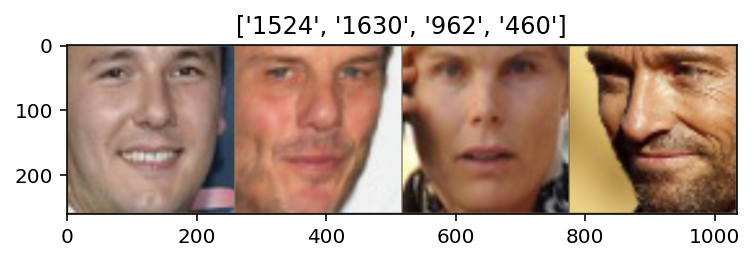

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
model_ft = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2354)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [7]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                # print(labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                print(best_acc)
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./vggface_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=200)

Epoch 0/199
----------
train Loss: 1.8728 Acc: 0.0017
tensor(0.0017, device='cuda:0')

Epoch 1/199
----------
train Loss: 1.7588 Acc: 0.0051
tensor(0.0051, device='cuda:0')

Epoch 2/199
----------
train Loss: 1.6494 Acc: 0.0121
tensor(0.0121, device='cuda:0')

Epoch 3/199
----------
train Loss: 1.5517 Acc: 0.0262
tensor(0.0262, device='cuda:0')

Epoch 4/199
----------
train Loss: 1.4592 Acc: 0.0484
tensor(0.0484, device='cuda:0')

Epoch 5/199
----------
train Loss: 1.3624 Acc: 0.0854
tensor(0.0854, device='cuda:0')

Epoch 6/199
----------
train Loss: 1.2560 Acc: 0.1380
tensor(0.1380, device='cuda:0')

Epoch 7/199
----------
train Loss: 1.1505 Acc: 0.2004
tensor(0.2004, device='cuda:0')

Epoch 8/199
----------
train Loss: 1.0477 Acc: 0.2705
tensor(0.2705, device='cuda:0')

Epoch 9/199
----------
train Loss: 0.9459 Acc: 0.3476
tensor(0.3476, device='cuda:0')

Epoch 10/199
----------
train Loss: 0.8492 Acc: 0.4244
tensor(0.4244, device='cuda:0')

Epoch 11/199
----------
train Loss: 0.7606

KeyboardInterrupt: 

In [9]:
model_ft_2 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, 2354)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/vggface_point_resnet_best.pth')
model_ft_2.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [11]:
data_dir = 'D:/Z-kobehsegu/Datasets/vggface_png/test'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [14]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
               # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./vggface_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
model_ft_2 = train_model(model_ft_2, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.5853 Acc: 0.0156
valid Loss: 1.4158 Acc: 0.0557

Epoch 1/29
----------
train Loss: 1.2961 Acc: 0.1039
valid Loss: 1.1978 Acc: 0.1793

Epoch 2/29
----------
train Loss: 0.9826 Acc: 0.2699
valid Loss: 1.0128 Acc: 0.3061

Epoch 3/29
----------
train Loss: 0.6841 Acc: 0.4600
valid Loss: 0.9191 Acc: 0.3793

Epoch 4/29
----------
train Loss: 0.4451 Acc: 0.6394
valid Loss: 0.8877 Acc: 0.4176

Epoch 5/29
----------
train Loss: 0.2728 Acc: 0.7732
valid Loss: 0.8947 Acc: 0.4332

Epoch 6/29
----------
train Loss: 0.1554 Acc: 0.8767
valid Loss: 0.9061 Acc: 0.4403

Epoch 7/29
----------
train Loss: 0.0886 Acc: 0.9378
valid Loss: 0.9057 Acc: 0.4550

Epoch 8/29
----------
train Loss: 0.0540 Acc: 0.9676
valid Loss: 0.9024 Acc: 0.4668

Epoch 9/29
----------
train Loss: 0.0358 Acc: 0.9841
valid Loss: 0.9061 Acc: 0.4695

Epoch 10/29
----------
train Loss: 0.0233 Acc: 0.9924
valid Loss: 0.8996 Acc: 0.4752

Epoch 11/29
----------
train Loss: 0.0187 Acc: 0.9938
valid Loss

In [16]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_2, 'test')

tensor([ 31, 220, 381,  57])
tensor([ 31,  22, 381,  57], device='cuda:0')
tensor([451,  19,  68, 395])
tensor([451, 106, 157, 283], device='cuda:0')
tensor([197,  94, 340, 339])
tensor([ 84,  94, 125, 339], device='cuda:0')
tensor([500, 126, 448, 163])
tensor([500, 303, 448, 163], device='cuda:0')
tensor([ 31, 291,   1, 412])
tensor([ 31, 291,   1, 204], device='cuda:0')
tensor([138, 258,  68,  53])
tensor([ 20, 258, 121,  53], device='cuda:0')
tensor([215, 469, 311, 517])
tensor([215, 469, 311, 517], device='cuda:0')
tensor([ 62, 445, 330, 201])
tensor([ 62, 441, 330, 214], device='cuda:0')
tensor([394, 106, 506, 349])
tensor([448, 243, 543, 276], device='cuda:0')
tensor([507, 268, 257, 198])
tensor([502, 268, 257, 198], device='cuda:0')
tensor([ 54, 101, 135,  71])
tensor([ 54, 101, 135, 419], device='cuda:0')
tensor([252, 128, 227, 386])
tensor([402, 128, 227, 386], device='cuda:0')
tensor([ 95, 301,  59, 198])
tensor([ 95, 301, 282,  10], device='cuda:0')
tensor([326,  25,  99, 35

tensor([ 14, 204, 515, 427])
tensor([411, 163, 515, 427], device='cuda:0')
tensor([ 82,  29, 500, 539])
tensor([ 82,  29, 339, 539], device='cuda:0')
tensor([ 44, 472, 100, 433])
tensor([421, 493, 429, 433], device='cuda:0')
tensor([ 42, 157, 453,  70])
tensor([364, 174, 453, 408], device='cuda:0')
tensor([155, 250, 490, 478])
tensor([155, 250, 284, 478], device='cuda:0')
tensor([293, 192,   7, 293])
tensor([293, 217,   7, 293], device='cuda:0')
tensor([ 20, 362, 106, 231])
tensor([334, 443, 100, 539], device='cuda:0')
tensor([308, 502,  45, 100])
tensor([551, 137,  45, 117], device='cuda:0')
tensor([354, 347, 521, 251])
tensor([354, 490, 521,  47], device='cuda:0')
tensor([198, 521, 488, 506])
tensor([ 65, 521, 320, 506], device='cuda:0')
tensor([215,  11, 541, 485])
tensor([296,  11, 541, 485], device='cuda:0')
tensor([549, 382, 266, 332])
tensor([549,  17, 266, 482], device='cuda:0')
tensor([209,  73, 102, 194])
tensor([209,  73, 102,  62], device='cuda:0')
tensor([359, 461,  52, 34

tensor([152, 337, 408, 417])
tensor([216, 337, 191, 123], device='cuda:0')
tensor([108, 422, 228, 306])
tensor([108, 422, 228, 306], device='cuda:0')
tensor([343, 288, 111,  82])
tensor([364,  28, 111,  82], device='cuda:0')
tensor([241, 404, 452, 405])
tensor([241, 404, 210, 405], device='cuda:0')
tensor([128,  98, 301, 396])
tensor([247,  98, 129, 396], device='cuda:0')
tensor([537,  38,  35,  99])
tensor([537,  38,  35, 441], device='cuda:0')
tensor([456,  83, 305, 256])
tensor([456, 455,   6, 256], device='cuda:0')
tensor([521,  38, 279, 214])
tensor([177,  42, 279, 214], device='cuda:0')
tensor([424, 121, 137, 397])
tensor([287, 121, 137, 397], device='cuda:0')
tensor([496, 158, 198, 334])
tensor([496, 248, 198, 334], device='cuda:0')
tensor([538, 429,  30, 452])
tensor([339, 244,  89,  69], device='cuda:0')
tensor([ 12, 469, 411, 531])
tensor([ 12, 469, 411,  64], device='cuda:0')
tensor([279, 206, 202, 405])
tensor([378, 206, 202, 261], device='cuda:0')
tensor([302,  59, 341, 53

tensor([ 39, 397, 161, 264])
tensor([ 39, 295, 429, 264], device='cuda:0')
tensor([426, 180, 361,  65])
tensor([193, 281, 361, 425], device='cuda:0')
tensor([425, 461, 549, 396])
tensor([522, 461, 296, 421], device='cuda:0')
tensor([263, 297,  14, 544])
tensor([406, 297,  71, 283], device='cuda:0')
tensor([ 12, 471, 212, 307])
tensor([408, 494, 353, 307], device='cuda:0')
tensor([150, 504, 175, 450])
tensor([ 45, 112,  41, 450], device='cuda:0')
tensor([ 32, 266, 224, 276])
tensor([290, 387, 358, 276], device='cuda:0')
tensor([ 96, 110, 523, 191])
tensor([ 96, 157, 523, 123], device='cuda:0')
tensor([161, 382, 210, 265])
tensor([161,  77, 210, 447], device='cuda:0')
tensor([531, 174, 230, 170])
tensor([355, 174, 107, 507], device='cuda:0')
tensor([406, 331, 372, 430])
tensor([406, 168, 372, 395], device='cuda:0')
tensor([269, 260, 539, 267])
tensor([382, 260, 167, 267], device='cuda:0')
tensor([154, 391, 129, 142])
tensor([154, 391, 323, 142], device='cuda:0')
tensor([153,   5, 462, 39

tensor([ 67, 222, 512, 309])
tensor([184, 191, 512, 309], device='cuda:0')
tensor([ 26, 135, 346, 330])
tensor([291, 135, 346, 474], device='cuda:0')
tensor([ 19, 398,  98, 473])
tensor([488, 524, 506, 473], device='cuda:0')
tensor([ 77, 298, 352, 304])
tensor([ 77, 138, 352, 304], device='cuda:0')
tensor([532, 330, 512, 406])
tensor([190, 330, 341, 289], device='cuda:0')
tensor([360, 354,  95, 196])
tensor([181, 354, 335, 196], device='cuda:0')
tensor([505, 174,  28, 131])
tensor([505, 174, 224, 131], device='cuda:0')
tensor([ 28,  19,  98, 292])
tensor([130, 307, 271, 292], device='cuda:0')
tensor([185, 391, 207, 389])
tensor([323, 175, 207, 389], device='cuda:0')
tensor([218, 109, 367, 381])
tensor([218, 109, 537, 381], device='cuda:0')
tensor([298, 386, 140, 518])
tensor([298, 148, 240, 481], device='cuda:0')
tensor([383, 104, 519,  56])
tensor([383, 104,  15,  56], device='cuda:0')
tensor([  3, 397, 369, 159])
tensor([  3, 397, 473, 159], device='cuda:0')
tensor([137,   9, 382, 20

tensor([ 80, 164, 172, 296])
tensor([ 80, 149, 333, 296], device='cuda:0')
tensor([ 96, 204, 455, 326])
tensor([ 96, 204, 455, 463], device='cuda:0')
tensor([419, 232, 333, 127])
tensor([419, 213, 365, 127], device='cuda:0')
tensor([ 67, 347,  54,  76])
tensor([ 67, 347, 314, 365], device='cuda:0')
tensor([319,  41, 307, 489])
tensor([319,  41, 307, 489], device='cuda:0')
tensor([193, 236, 110, 483])
tensor([ 61, 236,  69, 483], device='cuda:0')
tensor([ 62,  32, 515,  61])
tensor([ 62,  64, 284,  61], device='cuda:0')
tensor([129, 130, 200, 150])
tensor([129, 265, 122, 441], device='cuda:0')
tensor([494, 224, 300,  91])
tensor([494, 224, 412, 200], device='cuda:0')
tensor([ 19, 333, 291, 285])
tensor([104, 333, 291, 114], device='cuda:0')
tensor([404, 209, 111, 516])
tensor([404, 470, 111, 332], device='cuda:0')
tensor([499, 335, 110, 327])
tensor([499, 162, 110, 287], device='cuda:0')
tensor([421, 444, 459, 262])
tensor([182, 281, 459, 262], device='cuda:0')
tensor([237, 527, 449, 11

tensor([135, 219, 514, 233])
tensor([135, 219, 247, 233], device='cuda:0')
tensor([441, 317, 533, 173])
tensor([441, 121, 533, 173], device='cuda:0')
tensor([ 76, 438, 343, 357])
tensor([215, 438,  57, 412], device='cuda:0')
tensor([310, 375, 130, 197])
tensor([ 77, 375, 407, 213], device='cuda:0')
tensor([503, 275, 278, 288])
tensor([125, 104, 278, 110], device='cuda:0')
tensor([ 15, 440, 382,   7])
tensor([261, 434, 382, 491], device='cuda:0')
tensor([164, 195,  38, 209])
tensor([271, 111,  38, 209], device='cuda:0')
tensor([230, 435,  88, 384])
tensor([301, 239,  88, 300], device='cuda:0')
tensor([347, 300, 211, 370])
tensor([347, 300, 211, 449], device='cuda:0')
tensor([118, 508, 352, 487])
tensor([179, 396, 289, 487], device='cuda:0')
tensor([137, 328, 509, 294])
tensor([137, 175, 509, 294], device='cuda:0')
tensor([159, 223, 214,  89])
tensor([551, 436, 276, 389], device='cuda:0')
tensor([ 61, 389, 465, 403])
tensor([ 61, 153, 145, 364], device='cuda:0')
tensor([133, 367,  99, 25

tensor([ 69, 356, 232, 442])
tensor([168, 449, 526, 308], device='cuda:0')
tensor([ 28, 155, 152, 209])
tensor([198,  47, 152, 175], device='cuda:0')
tensor([456, 430, 342, 409])
tensor([456, 430,  15, 492], device='cuda:0')
tensor([218, 288, 531, 445])
tensor([530, 522, 531,  27], device='cuda:0')
tensor([537, 450, 119, 199])
tensor([537, 369, 436, 199], device='cuda:0')
tensor([476, 250, 401, 200])
tensor([476, 250, 209, 200], device='cuda:0')
tensor([ 59,  19, 232, 380])
tensor([111, 366, 232, 511], device='cuda:0')
tensor([547, 531, 358, 174])
tensor([547, 531, 408, 174], device='cuda:0')
tensor([459, 107,  79, 346])
tensor([459, 107,  79, 346], device='cuda:0')
tensor([ 93, 413, 256, 375])
tensor([102, 413, 217, 375], device='cuda:0')
tensor([125, 534, 377, 431])
tensor([359, 534, 377,  99], device='cuda:0')
tensor([387, 119,  70, 513])
tensor([387, 119, 252, 332], device='cuda:0')
tensor([ 76, 110, 538, 390])
tensor([ 76, 511,   4, 276], device='cuda:0')
tensor([548, 166, 373, 27

tensor([126,   5, 502, 402], device='cuda:0')
tensor([251, 474,  55, 453])
tensor([251, 474,  55, 319], device='cuda:0')
tensor([132, 286, 398,  42])
tensor([132, 286, 398,  42], device='cuda:0')
tensor([548,  25, 207, 427])
tensor([548,  25, 207, 427], device='cuda:0')
tensor([130, 210, 430,  48])
tensor([144, 210, 430,  95], device='cuda:0')
tensor([377, 221, 204, 128])
tensor([377, 221, 204, 175], device='cuda:0')
tensor([ 47, 486, 392, 350])
tensor([211, 486,  41, 367], device='cuda:0')
tensor([372, 235,  59,   8])
tensor([372, 235,  59,  50], device='cuda:0')
tensor([192, 346, 383, 367])
tensor([389, 469, 264,  66], device='cuda:0')
tensor([203, 530, 458, 539])
tensor([232, 132, 458, 265], device='cuda:0')
tensor([478, 376, 297,  81])
tensor([301, 526, 297,  81], device='cuda:0')
tensor([ 97, 347, 515,  19])
tensor([162, 347, 515, 130], device='cuda:0')
tensor([159, 458, 451, 150])
tensor([534, 518, 161,  29], device='cuda:0')
tensor([190, 535, 435, 235])
tensor([473, 535, 154, 23

tensor([198, 540, 242, 160])
tensor([498, 216, 363, 160], device='cuda:0')
tensor([194, 326, 173, 548])
tensor([ 49, 326, 173, 221], device='cuda:0')
tensor([141, 316, 386, 529])
tensor([209, 472, 437, 351], device='cuda:0')
tensor([300,  30, 483,  71])
tensor([445,  38, 483,  71], device='cuda:0')
tensor([413, 475, 105, 163])
tensor([413, 475, 105, 163], device='cuda:0')
tensor([ 30, 129, 130, 489])
tensor([ 30,  83, 130, 351], device='cuda:0')
tensor([134, 545,  39, 206])
tensor([134, 179,  39, 256], device='cuda:0')
tensor([262, 168, 421, 196])
tensor([ 59, 168, 320, 196], device='cuda:0')
tensor([144, 241, 312, 415])
tensor([107,  94, 312, 541], device='cuda:0')
tensor([236, 190, 159, 374])
tensor([236, 401,  30, 378], device='cuda:0')
tensor([463,  47, 369, 143])
tensor([150,   3, 369, 143], device='cuda:0')
tensor([181, 530, 168, 149])
tensor([260, 317, 262, 256], device='cuda:0')
tensor([440, 303, 280, 414])
tensor([ 99, 303, 134, 260], device='cuda:0')
tensor([358,  55, 261, 54

tensor([437, 237, 332, 426], device='cuda:0')
tensor([540, 457, 353,  41])
tensor([540, 457, 353, 318], device='cuda:0')
tensor([327, 422, 314, 318])
tensor([421, 366, 314, 318], device='cuda:0')
tensor([117, 313, 480, 335])
tensor([ 78, 169, 480,  79], device='cuda:0')
tensor([379,  92, 466, 174])
tensor([379, 248, 466,  23], device='cuda:0')
tensor([495,  10,  47, 384])
tensor([469,  10, 219, 402], device='cuda:0')
tensor([ 84, 376, 139, 112])
tensor([161, 170,  52, 112], device='cuda:0')
tensor([108,  90, 379, 292])
tensor([191,  90, 379, 292], device='cuda:0')
tensor([289, 308, 408, 458])
tensor([289, 317, 408, 458], device='cuda:0')
tensor([171, 329, 214, 462])
tensor([171, 388,  25, 533], device='cuda:0')
tensor([365, 304, 309, 320])
tensor([120, 533, 309, 219], device='cuda:0')
tensor([491,  90, 368, 325])
tensor([404, 268, 368, 315], device='cuda:0')
tensor([289, 182,  59, 281])
tensor([323, 182, 344, 420], device='cuda:0')
tensor([464,  48, 335, 229])
tensor([308, 356, 381, 22

tensor([266, 182, 443,  44])
tensor([266, 235, 447, 265], device='cuda:0')
tensor([345, 381, 309, 396])
tensor([345, 381,  24, 396], device='cuda:0')
tensor([392, 310, 525, 115])
tensor([392, 272, 505,  18], device='cuda:0')
tensor([158, 290, 450, 518])
tensor([269, 290, 450, 489], device='cuda:0')
tensor([241, 415,  40, 446])
tensor([241, 415, 306, 520], device='cuda:0')
tensor([174, 203, 551,  65])
tensor([355, 426, 551,  65], device='cuda:0')
tensor([236, 452,  83, 247])
tensor([236, 452,  83, 403], device='cuda:0')
tensor([373,  25, 282, 231])
tensor([439, 351, 282, 125], device='cuda:0')
tensor([485,  23, 122,  36])
tensor([485, 324, 222, 420], device='cuda:0')
tensor([442, 322, 435, 159])
tensor([171, 322, 435, 159], device='cuda:0')
tensor([ 14,  13, 350, 412])
tensor([425,  13, 247, 498], device='cuda:0')
tensor([186, 302, 227, 263])
tensor([186, 474, 227, 263], device='cuda:0')
tensor([324,  85, 517, 173])
tensor([414, 237, 517, 173], device='cuda:0')
tensor([517, 374, 491, 34

tensor([220, 316, 399,  61])
tensor([257, 100, 399,  61], device='cuda:0')
tensor([ 23, 418, 266, 487])
tensor([503, 436, 266, 487], device='cuda:0')
tensor([220, 380, 186,  54])
tensor([220, 393, 358,  54], device='cuda:0')
tensor([ 46, 292, 131, 474])
tensor([ 56, 292, 368, 474], device='cuda:0')
tensor([241, 366, 150, 219])
tensor([241, 164, 276, 441], device='cuda:0')
tensor([513, 507, 162, 186])
tensor([178, 507, 441, 186], device='cuda:0')
tensor([  9, 260, 434, 293])
tensor([454, 260, 434, 133], device='cuda:0')
tensor([141, 165, 500, 148])
tensor([ 37, 186, 500,  37], device='cuda:0')
tensor([309, 125, 112, 492])
tensor([534, 479, 443, 492], device='cuda:0')
tensor([509,  63, 161, 394])
tensor([323, 159, 161, 394], device='cuda:0')
tensor([374, 414, 309, 365])
tensor([428, 293, 309, 365], device='cuda:0')
tensor([275, 145,  57,  18])
tensor([275, 145, 130, 506], device='cuda:0')
tensor([483, 393, 107, 370])
tensor([483, 393, 107, 547], device='cuda:0')
tensor([128,  17, 191, 41

tensor([275, 256, 295, 235])
tensor([ 48, 256, 295, 162], device='cuda:0')
tensor([132, 333, 343, 417])
tensor([434,  57, 343, 340], device='cuda:0')
tensor([494, 523, 132, 214])
tensor([113, 105, 132, 214], device='cuda:0')
tensor([ 37, 356, 101, 512])
tensor([296, 356, 333, 257], device='cuda:0')
tensor([174, 134, 208, 303])
tensor([488, 134, 329, 303], device='cuda:0')
tensor([526, 473, 532, 470])
tensor([526, 473, 473, 366], device='cuda:0')
tensor([516, 129, 336, 130])
tensor([ 98, 129, 336,  14], device='cuda:0')
tensor([275,  13, 418, 458])
tensor([275, 256,  97, 458], device='cuda:0')
tensor([  2, 232, 270, 214])
tensor([  2, 420, 270, 123], device='cuda:0')
tensor([ 48, 511, 532,  33])
tensor([ 48, 511, 532, 149], device='cuda:0')
tensor([405, 395,   3, 467])
tensor([162, 352,  39, 134], device='cuda:0')
tensor([160,  62, 222,  66])
tensor([160,  62, 518,  66], device='cuda:0')
tensor([305,  18, 197, 412])
tensor([462, 474, 197, 371], device='cuda:0')
tensor([437, 147, 287, 23

tensor([ 98, 453, 317, 112])
tensor([179,  13,  64, 108], device='cuda:0')
tensor([397,  25, 350, 140])
tensor([366,  25, 423, 211], device='cuda:0')
tensor([150, 504, 152, 540])
tensor([316, 504, 152, 540], device='cuda:0')
tensor([312,  44, 272, 100])
tensor([312, 149, 272, 100], device='cuda:0')
tensor([498,  95,  44, 247])
tensor([253,  95,  44, 247], device='cuda:0')
tensor([544, 139, 477, 367])
tensor([132, 321, 477, 367], device='cuda:0')
tensor([531, 461, 547, 407])
tensor([531,  71, 547, 445], device='cuda:0')
tensor([404, 209, 156, 333])
tensor([214, 209,  16, 278], device='cuda:0')
tensor([420,   0, 193, 376])
tensor([420,   0, 356, 376], device='cuda:0')
tensor([ 34, 161, 416, 351])
tensor([405, 179, 416, 105], device='cuda:0')
tensor([ 16, 435, 456, 356])
tensor([ 16, 435, 456, 356], device='cuda:0')
tensor([445, 530,  29, 327])
tensor([  0, 530,  29, 327], device='cuda:0')
tensor([301, 432, 105,  66])
tensor([162, 408, 224,  66], device='cuda:0')
tensor([167,  57, 111, 17

tensor([244, 362, 371, 299])
tensor([486, 362, 371, 299], device='cuda:0')
tensor([298, 122,  76,  59])
tensor([298,  95,  76, 175], device='cuda:0')
tensor([  0, 399, 250, 134])
tensor([  0, 103, 250, 134], device='cuda:0')
tensor([212, 179, 106, 126])
tensor([ 76, 260, 406, 459], device='cuda:0')
tensor([430, 187, 202, 332])
tensor([430, 187, 202,  94], device='cuda:0')
tensor([ 67, 207, 541,  83])
tensor([211, 207, 541, 156], device='cuda:0')
tensor([332, 393,  62, 544])
tensor([324, 393,  62, 544], device='cuda:0')
tensor([168, 201, 495, 350])
tensor([168, 201, 495, 527], device='cuda:0')
tensor([171, 510,  47, 435])
tensor([171,  80, 302, 129], device='cuda:0')
tensor([476, 404, 477, 217])
tensor([476, 404, 477, 217], device='cuda:0')
tensor([321, 481, 304, 297])
tensor([321, 481, 530, 297], device='cuda:0')
tensor([373, 348, 513, 186])
tensor([  9, 348, 513,  91], device='cuda:0')
tensor([216, 147, 205, 292])
tensor([131,  73, 205, 157], device='cuda:0')
tensor([508, 442, 350, 20

tensor([198, 204, 239, 163])
tensor([198, 204, 239, 163], device='cuda:0')
tensor([ 32, 384,  26, 331])
tensor([ 32, 384, 255, 331], device='cuda:0')
tensor([ 66, 263, 182, 407])
tensor([ 66, 263, 258, 276], device='cuda:0')
tensor([370, 282, 444, 204])
tensor([477, 282, 444, 324], device='cuda:0')
tensor([272, 100, 397, 422])
tensor([272, 100, 397, 422], device='cuda:0')
tensor([346, 290,  17,  12])
tensor([346, 290, 242,  12], device='cuda:0')
tensor([416, 153, 295, 510])
tensor([416, 153, 389, 142], device='cuda:0')
tensor([267, 500, 233, 232])
tensor([267, 437, 233, 318], device='cuda:0')
tensor([530, 408, 114, 338])
tensor([238, 408, 114, 338], device='cuda:0')
tensor([467, 430, 528, 242])
tensor([467, 430, 528,  53], device='cuda:0')
tensor([534, 201, 197, 465])
tensor([534, 201, 360, 465], device='cuda:0')
tensor([387, 442, 318, 210])
tensor([387, 423, 353, 451], device='cuda:0')
tensor([273, 474, 344, 380])
tensor([273,  85, 546, 191], device='cuda:0')
tensor([328, 260, 509, 54

tensor([147, 169,  40, 342])
tensor([494, 169,  40, 342], device='cuda:0')
tensor([548, 402,   0, 481])
tensor([303, 281,   0, 309], device='cuda:0')
tensor([263, 291, 390, 427])
tensor([263, 248, 390, 219], device='cuda:0')
tensor([476,  31, 420, 376])
tensor([296, 392, 420,  90], device='cuda:0')
tensor([  7, 375, 435,  82])
tensor([  7, 375, 196,  82], device='cuda:0')
tensor([199,  59,  61, 405])
tensor([243, 515,  61, 213], device='cuda:0')
tensor([176, 469,   1,  10])
tensor([288, 399,   1, 308], device='cuda:0')
tensor([209, 405, 114, 241])
tensor([166, 405, 114, 241], device='cuda:0')
tensor([457, 376,  49, 187])
tensor([ 87, 390,  49, 187], device='cuda:0')
tensor([452, 503, 226, 256])
tensor([451, 503,  61, 274], device='cuda:0')
tensor([147,  67, 245, 303])
tensor([109,  67, 245, 303], device='cuda:0')
tensor([  2,  58, 415, 452])
tensor([  2, 375, 432, 479], device='cuda:0')
tensor([506, 500, 166, 463])
tensor([290, 500, 166,  40], device='cuda:0')
tensor([406, 319, 534, 20

tensor([338, 539, 406, 424])
tensor([484, 508, 406,  26], device='cuda:0')
tensor([271, 491, 219, 228])
tensor([271, 491, 320, 228], device='cuda:0')
tensor([ 22, 485, 256, 225])
tensor([ 22, 485,  12, 225], device='cuda:0')
tensor([ 34, 124, 422, 157])
tensor([ 34, 515, 422, 157], device='cuda:0')
tensor([344, 550, 224,  43])
tensor([344, 550, 224,  43], device='cuda:0')
tensor([ 22, 459, 133, 380])
tensor([551, 221, 133, 536], device='cuda:0')
tensor([139, 151, 228, 127])
tensor([ 86, 337, 228, 127], device='cuda:0')
tensor([505, 418, 107, 484])
tensor([336, 441, 226, 484], device='cuda:0')
tensor([124, 116, 399,  27])
tensor([124, 417,  45,  27], device='cuda:0')
tensor([354, 463, 206, 504])
tensor([354, 463, 206,  28], device='cuda:0')
tensor([322, 112,  74, 359])
tensor([ 23, 112,  87, 527], device='cuda:0')
tensor([304, 164, 254,  41])
tensor([187, 503, 395,  41], device='cuda:0')
tensor([258, 265, 529, 144])
tensor([169, 265, 447, 144], device='cuda:0')
tensor([199, 437,  70, 32

tensor([106,   3, 501, 345], device='cuda:0')
tensor([488, 417, 244,   3])
tensor([488, 387, 260,   3], device='cuda:0')
tensor([122, 106, 460, 221])
tensor([294, 133, 460, 221], device='cuda:0')
tensor([106, 539,  98, 167])
tensor([439, 134,  71, 151], device='cuda:0')
tensor([ 95, 477, 147, 529])
tensor([268, 477, 147, 529], device='cuda:0')
tensor([176, 327, 238, 265])
tensor([176, 273, 491, 539], device='cuda:0')
tensor([335, 288, 117, 475])
tensor([335, 288, 117, 235], device='cuda:0')
tensor([239, 387, 287, 327])
tensor([491, 469, 287, 327], device='cuda:0')
tensor([240, 241, 200, 141])
tensor([ 21, 413, 257, 224], device='cuda:0')
tensor([148, 423, 248, 416])
tensor([148, 423, 282, 416], device='cuda:0')
tensor([ 49, 379, 520, 370])
tensor([ 49, 421, 520,  47], device='cuda:0')
tensor([229, 112, 457, 219])
tensor([ 57, 110, 457, 219], device='cuda:0')
tensor([121, 208, 546, 466])
tensor([121, 208, 546, 466], device='cuda:0')
tensor([494, 486, 392, 520])
tensor([221, 486, 167, 52

tensor([ 41, 474, 359, 393])
tensor([542, 474, 145, 393], device='cuda:0')
tensor([  6, 141, 228, 248])
tensor([  6, 417, 228, 151], device='cuda:0')
tensor([464,   3, 309, 345])
tensor([464,   3, 309, 343], device='cuda:0')
tensor([372, 285, 145, 317])
tensor([200, 530, 453, 317], device='cuda:0')
tensor([112, 406, 352, 341])
tensor([260, 406, 352, 452], device='cuda:0')
tensor([290, 129,  48, 376])
tensor([290, 545,  48, 376], device='cuda:0')
tensor([206, 384, 136,  66])
tensor([206, 384, 222,  66], device='cuda:0')
tensor([439, 489, 181, 357])
tensor([439, 489, 369, 177], device='cuda:0')
tensor([360, 158, 343, 239])
tensor([144, 232,  90, 239], device='cuda:0')
tensor([253, 472, 451, 401])
tensor([385, 277, 451, 401], device='cuda:0')
tensor([374, 512, 449, 539])
tensor([374, 512, 449, 432], device='cuda:0')
tensor([185, 522, 222, 117])
tensor([185, 522,  51, 117], device='cuda:0')
tensor([363, 459, 342, 547])
tensor([363, 459, 342, 547], device='cuda:0')
tensor([  2, 339, 508, 23

tensor([544, 311, 159, 462])
tensor([170, 456, 159, 462], device='cuda:0')
tensor([287, 208, 446, 152])
tensor([287, 208, 133,  40], device='cuda:0')
tensor([392,  91, 468,  43])
tensor([242, 111, 468, 170], device='cuda:0')
tensor([196, 450, 426, 501])
tensor([196, 450, 141, 501], device='cuda:0')
tensor([159, 182, 213, 356])
tensor([225, 240, 213, 149], device='cuda:0')
tensor([514,  65, 331,  37])
tensor([514, 258, 331, 472], device='cuda:0')
tensor([158, 305, 102, 129])
tensor([158, 305, 102, 108], device='cuda:0')
tensor([ 48, 450, 141, 130])
tensor([113, 450, 141, 130], device='cuda:0')
tensor([113, 347, 193, 129])
tensor([ 37, 347, 336,  24], device='cuda:0')
tensor([176, 456, 353, 182])
tensor([102, 456, 353, 182], device='cuda:0')
tensor([474, 122, 268, 443])
tensor([406, 122, 288, 320], device='cuda:0')
tensor([486,  22, 138, 180])
tensor([486,  22, 189, 299], device='cuda:0')
tensor([  1, 415, 293, 157])
tensor([  1, 369, 293, 297], device='cuda:0')
tensor([270,   6,   8,  2

tensor([312,  10,  56,  83], device='cuda:0')
tensor([ 70, 487, 439, 476])
tensor([133, 448, 439, 476], device='cuda:0')
tensor([402, 140, 455, 350])
tensor([329, 488, 455, 220], device='cuda:0')
tensor([180, 177, 227, 144])
tensor([ 66, 177, 227, 144], device='cuda:0')
tensor([367, 517, 508, 227])
tensor([448, 517, 138,  55], device='cuda:0')
tensor([408, 301, 135, 249])
tensor([408, 494, 135, 249], device='cuda:0')
tensor([491, 460, 147,  99])
tensor([491, 460, 147,  99], device='cuda:0')
tensor([334,   0, 186, 543])
tensor([334, 418, 186, 543], device='cuda:0')
tensor([111,  99, 497, 485])
tensor([111,  96, 497, 485], device='cuda:0')
tensor([ 59, 365, 152, 277])
tensor([ 15,  80, 372, 471], device='cuda:0')
tensor([493, 200, 467, 332])
tensor([493, 200, 302, 332], device='cuda:0')
tensor([129, 113, 147,  36])
tensor([273, 113, 147,  36], device='cuda:0')
tensor([162,  52,  23, 540])
tensor([421, 279,  51, 540], device='cuda:0')
tensor([190, 316, 218, 378])
tensor([282, 316, 497, 14

tensor([444, 277, 391, 408], device='cuda:0')
tensor([340, 385, 109,  64])
tensor([130, 385, 109,  64], device='cuda:0')
tensor([373,  11,  34, 300])
tensor([ 99,  11,  34, 158], device='cuda:0')
tensor([336, 212, 464, 274])
tensor([336, 149, 464, 156], device='cuda:0')
tensor([337, 541, 319, 416])
tensor([337,  44, 319, 416], device='cuda:0')
tensor([168, 334,  60, 209])
tensor([168, 334, 447, 209], device='cuda:0')
tensor([236, 425, 475, 550])
tensor([165, 203,   7,  97], device='cuda:0')
tensor([385, 295, 228, 131])
tensor([284, 295, 450, 131], device='cuda:0')
tensor([279,  49,  14, 210])
tensor([279, 200, 407, 129], device='cuda:0')
tensor([368,  67, 102, 238])
tensor([137,  67, 102, 499], device='cuda:0')
tensor([294, 250, 279, 311])
tensor([330, 250, 279, 311], device='cuda:0')
tensor([ 60, 494, 156, 354])
tensor([ 60, 335, 156, 354], device='cuda:0')
tensor([484, 501, 421, 413])
tensor([481, 501, 347, 413], device='cuda:0')
tensor([30, 16, 27, 59])
tensor([ 30,  16, 232,  73], 

tensor([353,  86, 414, 159])
tensor([353, 539, 401, 159], device='cuda:0')
tensor([508, 200, 393, 423])
tensor([174, 537, 393, 326], device='cuda:0')
tensor([516,  45, 200, 425])
tensor([542, 273, 289, 124], device='cuda:0')
tensor([443, 152, 170, 440])
tensor([443, 152, 408,  28], device='cuda:0')
tensor([174, 518, 183, 451])
tensor([256,  32, 183, 307], device='cuda:0')
tensor([350, 282,  36, 474])
tensor([453, 282, 305, 474], device='cuda:0')
tensor([540, 154, 469, 119])
tensor([540, 183, 469, 119], device='cuda:0')
tensor([107, 216,  81, 526])
tensor([107, 216, 264, 526], device='cuda:0')
tensor([312, 405, 260, 524])
tensor([312, 403, 260, 524], device='cuda:0')
tensor([127, 538, 431, 426])
tensor([ 69, 392, 431, 289], device='cuda:0')
tensor([171,  51, 196, 355])
tensor([502,  51, 424, 355], device='cuda:0')
tensor([410, 219, 452,  29])
tensor([281,  91,  31, 170], device='cuda:0')
tensor([503, 318, 227, 234])
tensor([278, 327, 426, 234], device='cuda:0')
tensor([252, 419, 489, 43

tensor([316, 312,  95, 233], device='cuda:0')
tensor([227, 223,   3,  51])
tensor([294, 223,   3,  51], device='cuda:0')
tensor([475, 454, 180, 367])
tensor([475, 454, 242, 367], device='cuda:0')
tensor([281, 376, 198, 261])
tensor([521, 376,  88, 261], device='cuda:0')
tensor([  7, 145, 136, 178])
tensor([  7, 145,  46, 405], device='cuda:0')
tensor([111, 306,  62, 185])
tensor([ 38, 350, 266, 511], device='cuda:0')
tensor([165, 531, 411, 279])
tensor([165, 531, 411, 279], device='cuda:0')
tensor([ 89, 176, 317, 451])
tensor([ 89, 176, 317, 191], device='cuda:0')
tensor([527, 506, 340, 293])
tensor([441, 117, 525, 293], device='cuda:0')
tensor([371, 508,  58, 371])
tensor([410, 508, 235, 192], device='cuda:0')
tensor([330, 164, 400, 497])
tensor([330,  46, 202, 497], device='cuda:0')
tensor([237,  50, 167, 360])
tensor([117,  50, 437, 360], device='cuda:0')
tensor([476, 286, 361, 542])
tensor([476, 286, 484, 542], device='cuda:0')
tensor([228, 367, 502, 310])
tensor([228, 367, 502,  4

tensor([141, 163, 496, 501])
tensor([503, 163, 496,  34], device='cuda:0')
tensor([439,  36, 434, 142])
tensor([439,  36,  77, 290], device='cuda:0')
tensor([493, 551, 292,  97])
tensor([493, 526,  54, 321], device='cuda:0')
tensor([ 54, 487, 432, 407])
tensor([ 54, 167, 103, 407], device='cuda:0')
tensor([331,  61, 239, 513])
tensor([331,  61, 239, 513], device='cuda:0')
tensor([ 72, 133, 514, 384])
tensor([ 72, 264,  18, 492], device='cuda:0')
tensor([ 63, 246, 377, 422])
tensor([ 63, 246, 377, 434], device='cuda:0')
tensor([142, 139,  25, 449])
tensor([ 25, 135,  25,  18], device='cuda:0')
tensor([391, 266, 233, 414])
tensor([164, 266, 233,  23], device='cuda:0')
tensor([199, 323, 457, 336])
tensor([199, 323, 457,  76], device='cuda:0')
tensor([386, 130, 541,  35])
tensor([186, 352, 392, 293], device='cuda:0')
tensor([273, 535, 403, 531])
tensor([ 47, 177, 542, 434], device='cuda:0')
tensor([528, 409, 103, 247])
tensor([528, 409, 103, 247], device='cuda:0')
tensor([479, 231, 134, 10

tensor([492, 440, 366, 270])
tensor([341, 323, 366, 270], device='cuda:0')
tensor([161, 375,  82, 251])
tensor([161, 375,  82, 251], device='cuda:0')
tensor([534,  23, 183,   5])
tensor([239,  72, 535, 519], device='cuda:0')
tensor([431, 323, 321, 300])
tensor([431, 323, 366, 170], device='cuda:0')
tensor([ 31, 383, 258, 538])
tensor([342, 512, 258, 336], device='cuda:0')
tensor([467,  52,  87, 333])
tensor([467, 365,  87, 526], device='cuda:0')
tensor([455, 253,  12, 155])
tensor([455,  14, 160, 497], device='cuda:0')
tensor([126, 328, 427, 198])
tensor([126, 439, 427, 198], device='cuda:0')
tensor([ 92, 277, 495, 522])
tensor([ 92, 277, 239, 268], device='cuda:0')
tensor([ 14, 431, 209,  91])
tensor([251, 431, 209,  91], device='cuda:0')
tensor([ 40,  63, 505,  66])
tensor([128,  55, 319, 542], device='cuda:0')
tensor([320, 491, 123, 231])
tensor([499, 491,  95, 118], device='cuda:0')
tensor([454, 352, 302,  36])
tensor([454,  82, 302,  36], device='cuda:0')
tensor([327, 294, 358, 45

tensor([ 36, 401, 505, 519])
tensor([ 36, 401, 505, 519], device='cuda:0')
tensor([403, 399, 520,  15])
tensor([403,  45, 520,  15], device='cuda:0')
tensor([203,  91, 212,  63])
tensor([340,  91, 118,  63], device='cuda:0')
tensor([163, 504, 323, 131])
tensor([540,  75, 323, 131], device='cuda:0')
tensor([272, 502,  59, 302])
tensor([272, 502,  32, 179], device='cuda:0')
tensor([419, 488, 254, 405])
tensor([522, 488,  84, 405], device='cuda:0')
tensor([441, 164,  61, 308])
tensor([405, 164,  61, 217], device='cuda:0')
tensor([120, 532, 155,   5])
tensor([ 83, 532, 155,   5], device='cuda:0')
tensor([114, 229, 442, 203])
tensor([114, 229, 123, 203], device='cuda:0')
tensor([115, 206, 383, 158])
tensor([425, 206, 245, 542], device='cuda:0')
tensor([281, 119, 119, 437])
tensor([534, 119, 119, 244], device='cuda:0')
tensor([ 47, 183,   5, 290])
tensor([211, 183,   5, 214], device='cuda:0')
tensor([237, 320, 496, 310])
tensor([237, 420, 496, 310], device='cuda:0')
tensor([107,  28,  53, 53

tensor([378, 315, 336, 516], device='cuda:0')
tensor([289, 367,  54, 187])
tensor([300, 256,  54, 187], device='cuda:0')
tensor([  3, 380, 178, 240])
tensor([  3, 305, 463, 163], device='cuda:0')
tensor([  8, 474,  52, 326])
tensor([540, 365,  17, 249], device='cuda:0')
tensor([191,  34,  86, 447])
tensor([207, 252,  86, 447], device='cuda:0')
tensor([446, 201, 397, 199])
tensor([446, 448, 397,  30], device='cuda:0')
tensor([430,  93, 475, 349])
tensor([533,  93,  67, 540], device='cuda:0')
tensor([310, 298, 324, 147])
tensor([310, 269, 324, 179], device='cuda:0')
tensor([333, 103, 410,  50])
tensor([333, 243, 410,  50], device='cuda:0')
tensor([361, 238, 205, 519])
tensor([361, 238, 205, 519], device='cuda:0')
tensor([358, 408, 142,  95])
tensor([366, 408, 142,  95], device='cuda:0')
tensor([451, 481, 330, 235])
tensor([451, 542, 330, 235], device='cuda:0')
tensor([462, 430, 170, 242])
tensor([239, 430, 332, 242], device='cuda:0')
tensor([358, 495,  14, 241])
tensor([385, 495,  14, 24

tensor([130, 345, 461, 172])
tensor([377,  84, 122,  16], device='cuda:0')
tensor([521,   8,  21, 125])
tensor([521,   8,  21, 125], device='cuda:0')
tensor([462, 202, 498, 381])
tensor([462, 202,  96, 381], device='cuda:0')
tensor([542, 476, 215, 462])
tensor([542, 419, 215, 462], device='cuda:0')
tensor([530, 368, 545,  73])
tensor([322, 218, 436,  73], device='cuda:0')
tensor([421,  60,  35, 338])
tensor([421,  78, 287, 234], device='cuda:0')
tensor([122,  95, 162, 358])
tensor([391,  95, 347, 318], device='cuda:0')
tensor([156, 129,  80, 488])
tensor([156, 262, 493, 488], device='cuda:0')
tensor([420, 210, 486, 551])
tensor([420, 490, 486, 551], device='cuda:0')
tensor([372,  27, 261, 160])
tensor([235,  27, 320, 160], device='cuda:0')
tensor([260, 256, 464, 174])
tensor([221, 256, 464, 174], device='cuda:0')
tensor([487, 283, 188, 403])
tensor([350, 283,  32, 403], device='cuda:0')
tensor([501, 415, 427, 346])
tensor([501, 375, 427,  99], device='cuda:0')
tensor([435, 411, 492, 39

tensor([366, 443, 144, 370], device='cuda:0')
tensor([130, 447, 395, 237])
tensor([483, 434, 466, 237], device='cuda:0')
tensor([ 38,  26, 143,  76])
tensor([169, 498, 396,  76], device='cuda:0')
tensor([352, 472,  88, 186])
tensor([352, 472,  88, 371], device='cuda:0')
tensor([ 86, 438, 106, 507])
tensor([ 86,  50, 199, 189], device='cuda:0')
tensor([175, 336, 172, 297])
tensor([175, 336, 521, 450], device='cuda:0')
tensor([136, 229, 465, 149])
tensor([136, 161, 464, 149], device='cuda:0')
tensor([281, 308, 379, 218])
tensor([281, 394, 348, 218], device='cuda:0')
tensor([548, 433, 527, 467])
tensor([221, 120, 542, 467], device='cuda:0')
tensor([231, 506, 267, 271])
tensor([164, 255, 107, 271], device='cuda:0')
tensor([509, 382, 107, 329])
tensor([509, 382, 107, 329], device='cuda:0')
tensor([376,  84,  16, 154])
tensor([376,  84,  16, 322], device='cuda:0')
tensor([125,  39, 133, 532])
tensor([125,  39, 133, 300], device='cuda:0')
tensor([507,  16, 137, 361])
tensor([455,  16, 506, 36

tensor([517, 338, 442, 101])
tensor([494, 338,  61, 101], device='cuda:0')
tensor([201, 463, 302, 193])
tensor([201,  16, 302, 518], device='cuda:0')
tensor([ 69,  88, 235, 218])
tensor([ 69,  88, 235, 114], device='cuda:0')
tensor([540, 378, 535, 490])
tensor([339, 378, 350,  39], device='cuda:0')
tensor([ 14, 235,  85, 359])
tensor([ 14, 320,  28, 359], device='cuda:0')
tensor([146, 508, 259, 365])
tensor([146, 393, 259, 365], device='cuda:0')
tensor([287, 380, 356, 495])
tensor([ 47, 324, 356, 495], device='cuda:0')
tensor([161,  91, 454, 334])
tensor([161,  91, 454, 334], device='cuda:0')
tensor([265,  37, 167, 331])
tensor([525, 158,  94, 261], device='cuda:0')
tensor([262,  75, 102, 166])
tensor([262, 235, 351, 166], device='cuda:0')
tensor([ 85, 347, 468, 115])
tensor([ 85, 310, 468, 115], device='cuda:0')
tensor([503, 407, 196, 110])
tensor([503, 407, 196,  80], device='cuda:0')
tensor([239, 142, 229,  37])
tensor([153, 142, 345, 225], device='cuda:0')
tensor([190, 323, 519, 26

tensor([442,  83, 508,  98])
tensor([442,  83, 508,  98], device='cuda:0')
tensor([211, 174, 362, 317])
tensor([174, 352, 362, 232], device='cuda:0')
tensor([223, 108, 509, 190])
tensor([223, 171, 509, 190], device='cuda:0')
tensor([ 33, 523, 361, 550])
tensor([ 33, 462, 361, 550], device='cuda:0')
tensor([293, 130, 464,  78])
tensor([121, 130, 464, 439], device='cuda:0')
tensor([145, 429, 231, 456])
tensor([273, 530, 231, 456], device='cuda:0')
tensor([428, 158, 113,  97])
tensor([428, 158, 361,  97], device='cuda:0')
tensor([225,  98, 419,  14])
tensor([519,  98, 419,  14], device='cuda:0')
tensor([ 24,  19, 335, 504])
tensor([131, 234,  97, 504], device='cuda:0')
tensor([ 70, 155, 307, 464])
tensor([346, 155, 307, 472], device='cuda:0')
tensor([ 57, 384, 197, 244])
tensor([303, 384, 335, 265], device='cuda:0')
tensor([  9, 255, 402, 454])
tensor([418, 255, 516, 328], device='cuda:0')
tensor([313, 254, 481, 399])
tensor([385, 136, 481, 399], device='cuda:0')
tensor([ 32, 354, 476, 43

tensor([ 92, 527, 504, 450])
tensor([342,  74, 504, 450], device='cuda:0')
tensor([ 59, 309, 183,  45])
tensor([209, 309, 183,   0], device='cuda:0')
tensor([315, 148, 323, 345])
tensor([315,  64, 111, 345], device='cuda:0')
tensor([523,  48, 428, 266])
tensor([523,  48, 157, 266], device='cuda:0')
tensor([141, 361, 367,  25])
tensor([141, 344, 367,  25], device='cuda:0')
tensor([446,  32, 348, 441])
tensor([446, 221, 348, 436], device='cuda:0')
tensor([408, 376,  23,  71])
tensor([408, 376,  23, 338], device='cuda:0')
tensor([253, 188, 465, 356])
tensor([ 20, 216, 465, 356], device='cuda:0')
tensor([103, 230, 432, 507])
tensor([ 77, 372, 432, 151], device='cuda:0')
tensor([512, 463, 175, 391])
tensor([149, 463, 288, 168], device='cuda:0')
tensor([211, 153, 281, 456])
tensor([509, 153, 448, 447], device='cuda:0')
tensor([414,  16,  11, 260])
tensor([112,  73,  11, 260], device='cuda:0')
tensor([422,  24, 143,  66])
tensor([462,  47, 229,  66], device='cuda:0')
tensor([542, 550, 212, 38

tensor([175, 145, 138, 369])
tensor([175, 145,  77, 369], device='cuda:0')
tensor([413,  25, 357, 529])
tensor([413,  25, 485, 529], device='cuda:0')
tensor([ 22, 199,  18, 229])
tensor([353, 199, 424, 229], device='cuda:0')
tensor([422, 510, 297, 156])
tensor([422, 234, 297, 115], device='cuda:0')
tensor([302, 390, 466,  83])
tensor([302, 390, 466,  83], device='cuda:0')
tensor([ 62, 362, 103,  35])
tensor([ 62, 362, 103, 285], device='cuda:0')
tensor([323, 425, 370,  17])
tensor([323, 455, 534,  17], device='cuda:0')
tensor([413,  19, 181,   3])
tensor([413, 362, 181,   3], device='cuda:0')
tensor([154,  88, 212,  15])
tensor([132, 333, 395, 349], device='cuda:0')
tensor([117, 373, 207, 466])
tensor([117, 150, 207,  15], device='cuda:0')
tensor([238, 156, 331, 418])
tensor([238, 498, 331, 418], device='cuda:0')
tensor([ 91, 472, 414,   0])
tensor([ 91, 472, 362,   0], device='cuda:0')
tensor([482, 525, 499, 169])
tensor([482, 525, 524, 169], device='cuda:0')
tensor([469,  73,  10, 33

tensor([ 72, 250, 242,  42], device='cuda:0')
tensor([375, 429, 234, 461])
tensor([224, 413, 234, 461], device='cuda:0')
tensor([227,   4, 457, 528])
tensor([227, 369, 457, 528], device='cuda:0')
tensor([193, 309,  54,  94])
tensor([429, 309,  54, 402], device='cuda:0')
tensor([260, 250, 222,  21])
tensor([225, 250, 271, 104], device='cuda:0')
tensor([344, 512, 371, 222])
tensor([344, 512,  79,  15], device='cuda:0')
tensor([180,   9, 148,  56])
tensor([221, 268, 148,  56], device='cuda:0')
tensor([ 50,   5, 410, 436])
tensor([ 50,   5, 306, 296], device='cuda:0')
tensor([360, 533, 120, 511])
tensor([407, 533, 522, 509], device='cuda:0')
tensor([ 71, 314, 503, 450])
tensor([ 71, 314, 278, 450], device='cuda:0')
tensor([519, 169, 462, 405])
tensor([519, 117, 462, 466], device='cuda:0')
tensor([466, 152, 526, 259])
tensor([466, 179, 526, 259], device='cuda:0')
tensor([ 28, 183,  74, 152])
tensor([ 28, 252,  74, 506], device='cuda:0')
tensor([427, 273,  94, 406])
tensor([427, 273, 267, 40

tensor([472, 411, 206, 163])
tensor([472, 411, 209, 163], device='cuda:0')
tensor([ 91,  31, 324, 491])
tensor([ 65,  31, 324, 491], device='cuda:0')
tensor([498, 162, 181, 410])
tensor([498,  27, 438, 284], device='cuda:0')
tensor([369, 442, 457, 399])
tensor([171, 417, 457,  45], device='cuda:0')
tensor([ 82, 391, 541, 458])
tensor([ 82, 130, 541, 539], device='cuda:0')
tensor([524, 534,  42, 319])
tensor([524, 534,  42, 186], device='cuda:0')
tensor([251, 203, 112, 427])
tensor([436, 448, 324, 427], device='cuda:0')
tensor([271, 122, 168,  56])
tensor([271, 364, 168,  89], device='cuda:0')
tensor([395, 211, 153, 144])
tensor([ 40, 234, 153, 415], device='cuda:0')
tensor([104, 333, 278,  13])
tensor([104, 333, 424,  13], device='cuda:0')
tensor([322, 248, 122, 152])
tensor([322, 401, 122,  99], device='cuda:0')
tensor([450, 477, 336, 360])
tensor([450, 477, 336, 360], device='cuda:0')
tensor([251, 194, 286,  45])
tensor([ 81, 194, 286,  58], device='cuda:0')
tensor([438, 546, 329, 32

tensor([188, 474,  52,  44])
tensor([188, 474,  87,  66], device='cuda:0')
tensor([126, 336, 280,   1])
tensor([126, 467,  61,   1], device='cuda:0')
tensor([ 87, 366, 263, 426])
tensor([284, 444, 126, 213], device='cuda:0')
tensor([ 34, 254, 365, 185])
tensor([244, 456, 166, 268], device='cuda:0')
tensor([ 60, 545, 423,  90])
tensor([137, 551, 423, 505], device='cuda:0')
tensor([300, 214, 226,  78])
tensor([132, 214, 514, 242], device='cuda:0')
tensor([422, 533, 329, 277])
tensor([217, 533, 329, 156], device='cuda:0')
tensor([272, 234, 307, 441])
tensor([272, 131, 307, 373], device='cuda:0')
tensor([101,  82, 547, 455])
tensor([101, 269, 391, 455], device='cuda:0')
tensor([521, 186, 266, 222])
tensor([ 41, 186, 266, 222], device='cuda:0')
tensor([473, 336, 507, 125])
tensor([470, 542,  18, 125], device='cuda:0')
tensor([401, 403, 191,  49])
tensor([401, 218, 350,  49], device='cuda:0')
tensor([ 22, 484,  31, 177])
tensor([ 87, 156, 251, 177], device='cuda:0')
tensor([ 65, 479, 344,  1

tensor([392, 545, 185, 427])
tensor([392, 149, 185, 164], device='cuda:0')
tensor([117,  11, 235, 126])
tensor([117,  11, 339, 126], device='cuda:0')
tensor([ 94, 536, 300,  95])
tensor([ 94, 536, 300,  95], device='cuda:0')
tensor([ 94, 110,  91, 277])
tensor([ 94, 110, 162, 298], device='cuda:0')
tensor([528, 446, 122, 353])
tensor([469, 446, 122, 353], device='cuda:0')
tensor([ 32, 228, 503, 214])
tensor([507, 156, 503, 455], device='cuda:0')
tensor([296, 517, 255, 202])
tensor([437, 517, 255, 202], device='cuda:0')
tensor([178, 159, 419, 340])
tensor([136, 386, 438, 495], device='cuda:0')
tensor([306, 425, 214,  24])
tensor([306, 254, 137,  24], device='cuda:0')
tensor([ 44, 269, 246, 171])
tensor([401,  59, 295, 141], device='cuda:0')
tensor([219, 382, 535, 300])
tensor([440, 382,  86,  58], device='cuda:0')
tensor([ 64, 377,   5, 521])
tensor([ 64, 377,   5, 446], device='cuda:0')
tensor([330, 340, 232, 422])
tensor([330, 340, 232, 422], device='cuda:0')
tensor([311, 253, 194, 46

tensor([ 59, 405, 280, 335])
tensor([213,  46, 280,  48], device='cuda:0')
tensor([500, 248, 540, 350])
tensor([500,   9, 540, 317], device='cuda:0')
tensor([133,  69, 394, 424])
tensor([133,  69, 394, 368], device='cuda:0')
tensor([421, 409, 430, 127])
tensor([421, 409, 430, 449], device='cuda:0')
tensor([373,  72, 230, 268])
tensor([442, 547, 152,  74], device='cuda:0')
tensor([527, 291, 288, 160])
tensor([325, 291, 288, 160], device='cuda:0')
tensor([354, 333, 545, 459])
tensor([354, 333,  17, 459], device='cuda:0')
tensor([453, 225, 150, 309])
tensor([453, 225, 150, 481], device='cuda:0')
tensor([145,  46, 368, 231])
tensor([145,  45, 402, 231], device='cuda:0')
tensor([143, 471, 531, 373])
tensor([242,  83, 531, 197], device='cuda:0')
tensor([369, 317,  31, 332])
tensor([369, 258,  20,  95], device='cuda:0')
tensor([ 97, 524,  12, 287])
tensor([ 97, 524, 229, 287], device='cuda:0')
tensor([359, 488, 400, 288])
tensor([359, 296, 400, 288], device='cuda:0')
tensor([421, 331, 315, 47

tensor([ 77, 210, 459, 452], device='cuda:0')
tensor([ 53, 503, 181,  60])
tensor([ 53,  79, 203,  91], device='cuda:0')
tensor([267, 287, 433, 218])
tensor([ 51,  65, 254, 218], device='cuda:0')
tensor([ 40, 507, 476, 300])
tensor([ 40, 507, 476, 300], device='cuda:0')
tensor([499,  38, 544, 161])
tensor([499,  38, 544, 118], device='cuda:0')
tensor([182, 483, 240, 194])
tensor([182,  76,  31, 194], device='cuda:0')
tensor([419, 130,  78, 111])
tensor([419, 144,  78, 111], device='cuda:0')
tensor([ 21, 416, 244, 288])
tensor([ 14, 550, 260, 288], device='cuda:0')
tensor([244, 480,  27, 265])
tensor([244, 480,  27, 167], device='cuda:0')
tensor([128,  74, 466, 230])
tensor([128, 366, 386, 235], device='cuda:0')
tensor([125, 198, 212, 278])
tensor([125, 433, 212, 177], device='cuda:0')
tensor([204,  28, 475, 113])
tensor([204, 314, 475,  57], device='cuda:0')
tensor([ 79, 179, 395, 358])
tensor([ 79, 296, 395, 358], device='cuda:0')
tensor([154,  13, 220, 368])
tensor([471,  94, 419, 36

tensor([327, 197, 196, 292])
tensor([327, 192, 196, 292], device='cuda:0')
tensor([183,  89, 532,  92])
tensor([183, 473, 190,  92], device='cuda:0')
tensor([346, 290, 363, 479])
tensor([346,  29, 245, 479], device='cuda:0')
tensor([ 33, 453, 116, 140])
tensor([ 33, 453,  40, 140], device='cuda:0')
tensor([390, 194,   7, 515])
tensor([442, 194, 217, 515], device='cuda:0')
tensor([ 35, 538,  56,  69])
tensor([392, 314,  56,  69], device='cuda:0')
tensor([ 66, 429, 379,  94])
tensor([222, 540, 341, 402], device='cuda:0')
tensor([252, 437,  50, 337])
tensor([358, 437,  50, 337], device='cuda:0')
tensor([194, 252, 494, 515])
tensor([194, 241, 211, 509], device='cuda:0')
tensor([474, 137, 138,  92])
tensor([444, 137, 439, 252], device='cuda:0')
tensor([499, 456, 365, 136])
tensor([ 53, 456, 205, 136], device='cuda:0')
tensor([164, 216, 521, 255])
tensor([432, 414, 293, 433], device='cuda:0')
tensor([409,  63, 486, 528])
tensor([128,  51, 503,  24], device='cuda:0')
tensor([292, 258, 444, 18

tensor([ 75,  76, 524,  86], device='cuda:0')
tensor([244, 236, 168, 428])
tensor([449,  70,  99, 347], device='cuda:0')
tensor([250, 255, 292,  95])
tensor([255, 260, 292,  95], device='cuda:0')
tensor([480,  13, 523, 465])
tensor([304,  13, 523,  55], device='cuda:0')
tensor([432, 500,  44,  69])
tensor([431,  88, 228,  69], device='cuda:0')
tensor([167,  53, 189, 214])
tensor([151,  53, 328, 211], device='cuda:0')
tensor([334,  45, 161, 281])
tensor([334,  45, 161, 162], device='cuda:0')
tensor([344, 169, 344, 363])
tensor([344,  27,  72, 363], device='cuda:0')
tensor([  6, 342,  16, 461])
tensor([120, 342,  16, 123], device='cuda:0')
tensor([ 77,  50, 183, 531])
tensor([ 77, 261, 183, 353], device='cuda:0')
tensor([528, 397, 209, 123])
tensor([528, 397, 327, 123], device='cuda:0')
tensor([360, 203, 298, 506])
tensor([356, 203, 263, 506], device='cuda:0')
tensor([267, 373, 140, 523])
tensor([267, 366, 169, 523], device='cuda:0')
tensor([ 78, 138,  34, 547])
tensor([517, 243,  34, 27

In [17]:
data_dir = 'D:/Z-kobehsegu/Datasets/vggface_png/test_loFGAN'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [18]:
model_ft_3 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_3.fc.in_features
model_ft_3.fc = nn.Linear(num_ftrs, 2354)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/vggface_point_resnet_best.pth')
model_ft_3.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_3 = model_ft_3.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function

optimizer_ft = optim.SGD(model_ft_3.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [19]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./LofGAN_Augment_VGGFace_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
model_ft_3 = train_model(model_ft_3, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.5114 Acc: 0.0358
valid Loss: 1.2514 Acc: 0.1251

Epoch 1/29
----------
train Loss: 1.0572 Acc: 0.2188
valid Loss: 0.8623 Acc: 0.3602

Epoch 2/29
----------
train Loss: 0.7066 Acc: 0.4427
valid Loss: 0.6988 Acc: 0.4898

Epoch 3/29
----------
train Loss: 0.4961 Acc: 0.5998
valid Loss: 0.6319 Acc: 0.5514

Epoch 4/29
----------
train Loss: 0.3564 Acc: 0.7045
valid Loss: 0.5931 Acc: 0.5873

Epoch 5/29
----------
train Loss: 0.2536 Acc: 0.7878
valid Loss: 0.6060 Acc: 0.5920

Epoch 6/29
----------
train Loss: 0.1757 Acc: 0.8503
valid Loss: 0.6191 Acc: 0.5866

Epoch 7/29
----------
train Loss: 0.1192 Acc: 0.9013
valid Loss: 0.6216 Acc: 0.5951

Epoch 8/29
----------
train Loss: 0.0792 Acc: 0.9401
valid Loss: 0.6411 Acc: 0.5969

Epoch 9/29
----------
train Loss: 0.0517 Acc: 0.9654
valid Loss: 0.6421 Acc: 0.5973

Epoch 10/29
----------
train Loss: 0.0351 Acc: 0.9788
valid Loss: 0.6418 Acc: 0.6078

Epoch 11/29
----------
train Loss: 0.0258 Acc: 0.9871
valid Loss

In [21]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_3, 'test')

tensor([404,   1, 500, 263])
tensor([404,   1, 500, 263], device='cuda:0')
tensor([ 93,  92,  22, 388])
tensor([ 93,  92, 284, 388], device='cuda:0')
tensor([544, 544, 339, 464])
tensor([544, 366, 339, 464], device='cuda:0')
tensor([461, 275,  99, 509])
tensor([ 64, 275,  99, 509], device='cuda:0')
tensor([346,  98, 466, 329])
tensor([346,  98, 300, 329], device='cuda:0')
tensor([536, 353, 377,  36])
tensor([536, 353, 389,  36], device='cuda:0')
tensor([129, 301, 165,  56])
tensor([136, 189,  52,  56], device='cuda:0')
tensor([287, 383,  13, 333])
tensor([287, 383,  13, 333], device='cuda:0')
tensor([476, 336, 421, 357])
tensor([476, 182,  45, 357], device='cuda:0')
tensor([136, 202, 383, 361])
tensor([348, 202, 383, 361], device='cuda:0')
tensor([159, 192, 309, 258])
tensor([303, 320, 309, 258], device='cuda:0')
tensor([360, 197, 378, 302])
tensor([360, 197, 378, 502], device='cuda:0')
tensor([210,  98,  46, 461])
tensor([374,  98,  45, 461], device='cuda:0')
tensor([277, 447, 418, 33

tensor([343, 367,  26, 278], device='cuda:0')
tensor([ 53, 305,  86, 335])
tensor([ 53, 325,  86, 335], device='cuda:0')
tensor([458, 541,  96, 151])
tensor([458, 541, 230, 151], device='cuda:0')
tensor([211, 114, 170, 479])
tensor([206, 114, 170, 479], device='cuda:0')
tensor([431, 208, 190, 246])
tensor([227, 343, 190, 246], device='cuda:0')
tensor([173,  38, 108, 100])
tensor([288, 530, 108, 506], device='cuda:0')
tensor([ 77, 455, 374, 460])
tensor([ 77, 455, 374, 460], device='cuda:0')
tensor([419, 235, 481, 379])
tensor([419, 235, 378, 379], device='cuda:0')
tensor([515,   7, 396, 236])
tensor([515,   7, 396, 236], device='cuda:0')
tensor([522, 486,  10, 362])
tensor([522, 486,  10, 362], device='cuda:0')
tensor([289, 321, 345, 170])
tensor([511, 321, 345, 170], device='cuda:0')
tensor([338, 246, 191, 278])
tensor([437, 240, 158, 278], device='cuda:0')
tensor([175, 316, 340, 299])
tensor([175, 316,  14, 505], device='cuda:0')
tensor([367, 213, 150, 459])
tensor([367, 525, 240, 45

tensor([ 23, 440, 230, 535])
tensor([350,  27, 230, 535], device='cuda:0')
tensor([383,  23, 541,  51])
tensor([383, 191, 212, 147], device='cuda:0')
tensor([545, 442, 490,  81])
tensor([545, 442, 490, 284], device='cuda:0')
tensor([381, 496, 237, 441])
tensor([381, 496, 237, 269], device='cuda:0')
tensor([383, 515, 332, 294])
tensor([383, 515, 332, 253], device='cuda:0')
tensor([127, 351,  18, 551])
tensor([470, 351, 312, 551], device='cuda:0')
tensor([421,  75,  38, 226])
tensor([ 26,  75,  38, 226], device='cuda:0')
tensor([455, 499, 196,  82])
tensor([455,  53, 196,  82], device='cuda:0')
tensor([243, 480, 188, 189])
tensor([243, 168, 188, 189], device='cuda:0')
tensor([179, 126, 522, 248])
tensor([453, 276, 522, 248], device='cuda:0')
tensor([370, 153, 102, 399])
tensor([370,  13, 102,  45], device='cuda:0')
tensor([412, 247, 485, 334])
tensor([532, 247, 485, 334], device='cuda:0')
tensor([ 98, 421, 279, 133])
tensor([374, 421, 279, 133], device='cuda:0')
tensor([251,  46, 307, 38

tensor([ 31, 103,  75, 193])
tensor([ 31, 103,  75, 480], device='cuda:0')
tensor([416, 313, 383, 520])
tensor([416, 313, 383, 520], device='cuda:0')
tensor([456, 263, 317, 313])
tensor([ 77,  28, 313, 313], device='cuda:0')
tensor([507, 337, 525, 279])
tensor([177, 337, 525, 279], device='cuda:0')
tensor([199,   2, 505, 463])
tensor([335,   2, 505, 463], device='cuda:0')
tensor([337, 409, 142,  95])
tensor([529, 409,   8, 541], device='cuda:0')
tensor([196, 307, 291, 418])
tensor([174, 273, 291, 189], device='cuda:0')
tensor([192,  33, 151, 358])
tensor([514, 156,  42, 408], device='cuda:0')
tensor([515, 246,  40, 287])
tensor([502, 246,  40, 287], device='cuda:0')
tensor([479,  58, 324,  93])
tensor([113,  58, 324,  66], device='cuda:0')
tensor([ 60, 495,   5, 299])
tensor([541, 110,   5,  83], device='cuda:0')
tensor([355, 474,  85, 474])
tensor([355, 481,  85,  83], device='cuda:0')
tensor([ 54, 199, 198, 170])
tensor([ 54, 199, 198, 170], device='cuda:0')
tensor([234, 437, 354, 41

tensor([ 60, 458, 107, 250])
tensor([503, 458, 107, 250], device='cuda:0')
tensor([383,  34, 114,  41])
tensor([383,  34, 114,  41], device='cuda:0')
tensor([166, 428, 295, 252])
tensor([166, 406, 534, 252], device='cuda:0')
tensor([ 50, 135, 191, 538])
tensor([388, 135,  92, 181], device='cuda:0')
tensor([437, 146, 536, 143])
tensor([549, 146, 536,   6], device='cuda:0')
tensor([156, 461,  13,  81])
tensor([110, 461,  13,  81], device='cuda:0')
tensor([482, 370, 177, 548])
tensor([482, 370, 177, 548], device='cuda:0')
tensor([313, 109, 542, 213])
tensor([313, 460, 218, 176], device='cuda:0')
tensor([ 85,  79, 228, 264])
tensor([ 85,  79, 228, 226], device='cuda:0')
tensor([310, 358,  21,  66])
tensor([310, 358, 113,  66], device='cuda:0')
tensor([137, 479,  71, 336])
tensor([137, 479,  71, 336], device='cuda:0')
tensor([176, 305, 341, 384])
tensor([ 91, 129, 341, 384], device='cuda:0')
tensor([403, 365,  65, 414])
tensor([403, 192, 149, 114], device='cuda:0')
tensor([ 87, 302, 329, 40

tensor([258, 528, 518,   7])
tensor([258, 528, 266,   7], device='cuda:0')
tensor([ 63, 529,  67, 289])
tensor([ 63, 529,  67,  84], device='cuda:0')
tensor([125, 148,  45,  86])
tensor([125, 103,  45,  86], device='cuda:0')
tensor([221, 188,  78, 483])
tensor([338, 188,  78, 483], device='cuda:0')
tensor([ 13, 159, 377, 213])
tensor([ 13, 159,  77, 213], device='cuda:0')
tensor([172, 101, 101, 315])
tensor([172, 290,  53,  96], device='cuda:0')
tensor([399,  15, 355, 480])
tensor([129, 402, 334, 351], device='cuda:0')
tensor([534, 342, 196,  70])
tensor([295, 342, 269,  70], device='cuda:0')
tensor([202, 487,   9, 201])
tensor([202, 487, 162, 201], device='cuda:0')
tensor([322, 465, 372, 291])
tensor([322, 465, 372, 250], device='cuda:0')
tensor([204,   3, 178, 323])
tensor([550, 203,  30, 323], device='cuda:0')
tensor([213, 285, 136, 139])
tensor([213, 285, 136, 382], device='cuda:0')
tensor([354,  23, 431, 254])
tensor([354,  23, 242, 254], device='cuda:0')
tensor([304, 163, 100, 24

tensor([246,  68, 257, 288])
tensor([246,  68, 346, 105], device='cuda:0')
tensor([424, 161, 139, 173])
tensor([424, 517, 551, 351], device='cuda:0')
tensor([438,  68,  80, 479])
tensor([438,  68, 212, 479], device='cuda:0')
tensor([220, 441, 366,  85])
tensor([ 32, 276, 366,  85], device='cuda:0')
tensor([288, 361, 306, 538])
tensor([288,  70, 306, 538], device='cuda:0')
tensor([485, 253, 333,  87])
tensor([324, 253, 333, 282], device='cuda:0')
tensor([ 61, 231, 499,  51])
tensor([ 61, 206, 321,  54], device='cuda:0')
tensor([320, 483, 408, 287])
tensor([344, 483, 396, 287], device='cuda:0')
tensor([152,  98,  10, 368])
tensor([152, 469,  10, 368], device='cuda:0')
tensor([489, 424,  63, 257])
tensor([489, 424,  63, 257], device='cuda:0')
tensor([503, 311, 518, 291])
tensor([503, 311, 518, 291], device='cuda:0')
tensor([114, 329, 170, 421])
tensor([114, 329, 219, 139], device='cuda:0')
tensor([490, 468, 548, 204])
tensor([442,  92, 548, 204], device='cuda:0')
tensor([236,  72,  60, 35

tensor([ 92,  78, 508, 207], device='cuda:0')
tensor([517, 369, 266, 378])
tensor([517, 369, 266,  66], device='cuda:0')
tensor([219, 415, 217, 446])
tensor([116, 415, 532,  27], device='cuda:0')
tensor([143, 465, 217, 269])
tensor([331, 465, 217, 523], device='cuda:0')
tensor([123, 414, 544,  94])
tensor([123, 284, 458,  94], device='cuda:0')
tensor([ 45,  54, 411, 206])
tensor([ 45,  54, 411, 189], device='cuda:0')
tensor([123,  93, 169, 429])
tensor([123, 324, 169, 429], device='cuda:0')
tensor([180, 400, 381, 113])
tensor([180, 209, 113, 113], device='cuda:0')
tensor([ 68,  72, 263, 426])
tensor([ 68,  72, 251, 462], device='cuda:0')
tensor([211, 300, 494, 258])
tensor([211, 222, 494, 424], device='cuda:0')
tensor([501, 280, 171,  61])
tensor([ 38,   1, 171,  61], device='cuda:0')
tensor([450, 513,  53, 319])
tensor([450, 513, 286, 319], device='cuda:0')
tensor([ 47, 434,  66,  46])
tensor([265, 422,  66,  28], device='cuda:0')
tensor([ 80,  64, 263, 360])
tensor([442,  64, 263, 29

tensor([228, 213, 236,  88])
tensor([314, 119, 236, 524], device='cuda:0')
tensor([111, 466, 195, 151])
tensor([111, 281, 195, 151], device='cuda:0')
tensor([259, 365, 296, 100])
tensor([259, 178, 296, 280], device='cuda:0')
tensor([476, 129, 496, 359])
tensor([476, 129, 436, 359], device='cuda:0')
tensor([421, 328,  80, 402])
tensor([421, 328,  80, 402], device='cuda:0')
tensor([ 49, 416,  11, 161])
tensor([ 49, 416,  11, 161], device='cuda:0')
tensor([286,  83,  96, 422])
tensor([286, 451, 262, 422], device='cuda:0')
tensor([401, 534, 154, 231])
tensor([ 47, 534, 204, 231], device='cuda:0')
tensor([ 34, 396,  78, 400])
tensor([ 34, 396,  78, 400], device='cuda:0')
tensor([299, 306,  26, 403])
tensor([299, 452,  27, 403], device='cuda:0')
tensor([260, 454, 122, 171])
tensor([547, 371, 122, 171], device='cuda:0')
tensor([342, 346,   8, 192])
tensor([ 42, 346, 102, 192], device='cuda:0')
tensor([155, 281, 156,  22])
tensor([155, 281, 156,  22], device='cuda:0')
tensor([196, 276, 148, 15

tensor([217, 464, 102, 143])
tensor([217,  31, 102, 212], device='cuda:0')
tensor([ 87, 203, 171, 268])
tensor([312, 203, 171, 268], device='cuda:0')
tensor([  0, 494, 496, 168])
tensor([165, 494, 496, 393], device='cuda:0')
tensor([346,  79, 400, 288])
tensor([346, 165, 551, 288], device='cuda:0')
tensor([424, 334, 367, 219])
tensor([424, 334, 449, 548], device='cuda:0')
tensor([464, 174, 436, 447])
tensor([ 99, 174, 290, 447], device='cuda:0')
tensor([313, 162, 540, 528])
tensor([313, 162, 540, 528], device='cuda:0')
tensor([202,  10, 296,  90])
tensor([202,  10, 296,  90], device='cuda:0')
tensor([257, 284, 165, 298])
tensor([317, 174, 365, 298], device='cuda:0')
tensor([ 53,  50, 149, 124])
tensor([ 53, 140, 149, 207], device='cuda:0')
tensor([ 94, 300, 339, 376])
tensor([ 94, 300, 339, 376], device='cuda:0')
tensor([ 42, 419, 544, 377])
tensor([ 42, 393, 544, 377], device='cuda:0')
tensor([122,  75, 435, 201])
tensor([122,  75, 435, 201], device='cuda:0')
tensor([224, 473,  93, 11

tensor([372, 141, 398, 287])
tensor([372, 141,  52, 304], device='cuda:0')
tensor([111,   7, 245, 175])
tensor([286,   7, 245, 445], device='cuda:0')
tensor([357, 523, 279, 188])
tensor([357, 523, 279, 108], device='cuda:0')
tensor([ 43, 384, 376, 440])
tensor([ 43, 384, 437, 440], device='cuda:0')
tensor([357, 158, 353, 276])
tensor([357, 129, 353, 276], device='cuda:0')
tensor([459, 380, 232,  10])
tensor([459, 298, 232, 343], device='cuda:0')
tensor([317, 255, 308, 117])
tensor([ 87, 255, 308,  78], device='cuda:0')
tensor([124, 141,  74, 363])
tensor([457, 141,  74, 363], device='cuda:0')
tensor([ 83,   3, 516,  50])
tensor([407,   3, 471,  50], device='cuda:0')
tensor([238, 445, 382, 265])
tensor([408, 389, 139,  12], device='cuda:0')
tensor([  8,  42, 290, 472])
tensor([ 33, 111, 290, 472], device='cuda:0')
tensor([498, 320,  43, 433])
tensor([498, 320,  43, 433], device='cuda:0')
tensor([405, 416, 179, 173])
tensor([ 30, 435, 162, 173], device='cuda:0')
tensor([350, 452, 494, 10

tensor([339, 480, 295, 454], device='cuda:0')
tensor([486, 285, 265, 242])
tensor([486, 285, 265, 242], device='cuda:0')
tensor([107, 506, 405, 499])
tensor([185, 156, 129, 372], device='cuda:0')
tensor([ 21, 329, 257, 350])
tensor([ 21, 329, 257, 495], device='cuda:0')
tensor([202, 338, 351,   0])
tensor([202, 338, 351,   0], device='cuda:0')
tensor([376, 481, 358, 211])
tensor([376, 454, 358, 482], device='cuda:0')
tensor([490, 101, 193, 380])
tensor([490, 163,  45, 380], device='cuda:0')
tensor([156,   9,  87, 254])
tensor([156, 118,   4, 372], device='cuda:0')
tensor([493, 138, 114, 446])
tensor([493, 138, 114, 446], device='cuda:0')
tensor([ 17, 415,  92, 139])
tensor([ 17, 356,  92, 203], device='cuda:0')
tensor([319,  96, 172, 326])
tensor([319,  96, 172,  13], device='cuda:0')
tensor([ 37, 277, 194,  65])
tensor([368, 277, 194,  65], device='cuda:0')
tensor([201, 156, 244, 478])
tensor([201, 156,  14, 478], device='cuda:0')
tensor([550, 356, 443,  95])
tensor([550,  18, 443,  9

tensor([347, 371, 487, 322], device='cuda:0')
tensor([438, 233, 287, 206])
tensor([438, 233,  65, 206], device='cuda:0')
tensor([294, 210, 410, 104])
tensor([294, 210, 271, 117], device='cuda:0')
tensor([273, 362,  75,  79])
tensor([273, 362,  75, 231], device='cuda:0')
tensor([148,  79, 132, 294])
tensor([300,  79, 132, 223], device='cuda:0')
tensor([347,  23, 421, 151])
tensor([347,  23, 129, 174], device='cuda:0')
tensor([ 67,  95, 301, 197])
tensor([119,  71, 301, 360], device='cuda:0')
tensor([386, 301,  97, 187])
tensor([386, 301,  14, 187], device='cuda:0')
tensor([536, 406, 464, 283])
tensor([ 46, 406, 464,  72], device='cuda:0')
tensor([ 28, 331, 540, 187])
tensor([374, 331, 540, 187], device='cuda:0')
tensor([435, 140, 276, 305])
tensor([421, 140, 276, 305], device='cuda:0')
tensor([ 34, 486, 214, 388])
tensor([ 34, 530, 138, 388], device='cuda:0')
tensor([147, 481, 254,  96])
tensor([147, 481, 372,  96], device='cuda:0')
tensor([473, 333, 481,  86])
tensor([336, 333, 481,  8

tensor([533, 220,  89, 461])
tensor([533, 136, 273,  95], device='cuda:0')
tensor([158, 333, 242, 342])
tensor([158, 101, 242, 342], device='cuda:0')
tensor([248,  51, 156, 478])
tensor([367,  51, 156, 478], device='cuda:0')
tensor([ 23, 365, 536, 383])
tensor([ 66, 365, 536, 383], device='cuda:0')
tensor([113, 523, 200, 286])
tensor([ 95, 523, 260, 286], device='cuda:0')
tensor([ 93, 244, 542, 163])
tensor([ 93, 244, 542, 163], device='cuda:0')
tensor([370, 161, 163, 479])
tensor([231, 161, 163, 479], device='cuda:0')
tensor([516,  40, 293, 471])
tensor([516,  40, 293,   5], device='cuda:0')
tensor([245, 217, 243,  67])
tensor([245, 217, 243, 215], device='cuda:0')
tensor([316, 344, 175,  40])
tensor([316, 523, 410,  40], device='cuda:0')
tensor([179, 238, 486,  23])
tensor([345, 238, 486, 549], device='cuda:0')
tensor([203, 201, 291, 109])
tensor([203, 201, 291,  91], device='cuda:0')
tensor([ 41, 229, 266, 318])
tensor([ 41, 229, 266, 450], device='cuda:0')
tensor([523, 496,  76, 36

tensor([392, 221, 183, 485], device='cuda:0')
tensor([ 67, 471, 138,  93])
tensor([ 67, 471, 138,  93], device='cuda:0')
tensor([361, 352, 149, 292])
tensor([361, 192, 298, 292], device='cuda:0')
tensor([533, 136, 331, 196])
tensor([533, 136, 331, 196], device='cuda:0')
tensor([100, 546, 309, 214])
tensor([100, 283, 309, 214], device='cuda:0')
tensor([239,  79, 377,  99])
tensor([176,  79, 377, 500], device='cuda:0')
tensor([308,  17, 362, 486])
tensor([  7,  17, 326, 486], device='cuda:0')
tensor([173,  88, 427, 228])
tensor([173, 521, 427, 160], device='cuda:0')
tensor([346, 214, 185, 360])
tensor([346, 214, 185, 360], device='cuda:0')
tensor([466, 140, 235,   9])
tensor([466, 328, 235, 118], device='cuda:0')
tensor([233, 311, 252,   9])
tensor([233, 311, 252, 345], device='cuda:0')
tensor([317, 245, 369, 365])
tensor([317, 245, 139, 365], device='cuda:0')
tensor([116, 281, 431, 517])
tensor([116, 162, 431, 331], device='cuda:0')
tensor([454, 288, 316, 207])
tensor([454, 288, 316, 20

tensor([508,  88,   2, 528])
tensor([508, 325,   2, 528], device='cuda:0')
tensor([122, 378, 333, 271])
tensor([278, 378, 333, 271], device='cuda:0')
tensor([441, 423, 526, 314])
tensor([441, 423, 526, 314], device='cuda:0')
tensor([372, 264, 549,  85])
tensor([372, 264, 475,  85], device='cuda:0')
tensor([505, 316, 353, 392])
tensor([371,  89, 353, 392], device='cuda:0')
tensor([217, 371, 253,  15])
tensor([217, 371, 445, 342], device='cuda:0')
tensor([378, 231, 284, 541])
tensor([  4, 263, 284, 541], device='cuda:0')
tensor([535, 206,  93, 279])
tensor([535, 206,  93, 279], device='cuda:0')
tensor([158,  44, 541, 392])
tensor([297,  44, 551, 503], device='cuda:0')
tensor([156, 407, 309,   7])
tensor([156, 407, 309,   7], device='cuda:0')
tensor([458, 335, 462, 393])
tensor([458, 419, 462, 393], device='cuda:0')
tensor([ 16, 224, 430, 199])
tensor([191,  24, 508, 199], device='cuda:0')
tensor([ 34, 430, 475, 532])
tensor([ 34, 430, 475, 532], device='cuda:0')
tensor([516,  13,  81, 32

tensor([149, 317, 479, 294])
tensor([149, 287, 479, 294], device='cuda:0')
tensor([240, 190, 534, 265])
tensor([240, 190, 534, 385], device='cuda:0')
tensor([ 22, 205, 494,  84])
tensor([ 22, 205, 494, 230], device='cuda:0')
tensor([254,  74, 181,  64])
tensor([254, 294, 181,  64], device='cuda:0')
tensor([438, 168, 246, 395])
tensor([  5, 168, 246, 395], device='cuda:0')
tensor([297,  64, 423,  95])
tensor([297, 106, 427,  95], device='cuda:0')
tensor([229, 209, 208, 542])
tensor([229, 166, 208, 542], device='cuda:0')
tensor([ 85, 261, 490,  93])
tensor([331, 235,   0, 217], device='cuda:0')
tensor([317, 128, 410, 241])
tensor([ 46, 338, 410, 241], device='cuda:0')
tensor([ 52, 387, 440, 203])
tensor([ 52, 387, 440, 203], device='cuda:0')
tensor([105, 497, 533, 315])
tensor([105, 497, 533, 315], device='cuda:0')
tensor([330, 498, 520, 422])
tensor([330, 498, 520, 422], device='cuda:0')
tensor([245,  85, 420, 161])
tensor([245,  22, 420, 161], device='cuda:0')
tensor([425, 196, 259, 15

tensor([285, 433, 480, 325])
tensor([ 60, 229, 480, 436], device='cuda:0')
tensor([325, 337, 513, 391])
tensor([158, 337, 513, 387], device='cuda:0')
tensor([407, 421, 544, 221])
tensor([407, 421, 544, 221], device='cuda:0')
tensor([189, 277, 382, 397])
tensor([176, 277, 382, 397], device='cuda:0')
tensor([398,  82,  42, 183])
tensor([398,  82,  42, 183], device='cuda:0')
tensor([ 85, 243, 191, 111])
tensor([ 85, 243, 253, 209], device='cuda:0')
tensor([291,  31, 161, 322])
tensor([291,  31, 447, 322], device='cuda:0')
tensor([473, 451, 491, 307])
tensor([473, 451, 491, 376], device='cuda:0')
tensor([546, 131, 486, 118])
tensor([482, 171, 313, 118], device='cuda:0')
tensor([164, 398, 320, 454])
tensor([366, 228, 107, 454], device='cuda:0')
tensor([527, 268,  13,  46])
tensor([248, 268,  13, 493], device='cuda:0')
tensor([ 45, 435, 372, 111])
tensor([ 45, 435, 164, 111], device='cuda:0')
tensor([ 91, 100, 437, 543])
tensor([ 91, 280, 437, 543], device='cuda:0')
tensor([369, 160, 470, 39

tensor([514, 110, 522, 500], device='cuda:0')
tensor([ 33, 550,   1, 421])
tensor([ 33, 550,   1, 421], device='cuda:0')
tensor([445, 384, 268, 188])
tensor([ 27, 384, 268, 188], device='cuda:0')
tensor([422, 217, 274,  43])
tensor([422, 217, 274,  43], device='cuda:0')
tensor([527, 115,  12, 234])
tensor([113, 115,  12,   4], device='cuda:0')
tensor([113, 100, 528, 344])
tensor([ 56, 100,   4, 344], device='cuda:0')
tensor([358, 402, 489, 122])
tensor([358, 513, 489, 122], device='cuda:0')
tensor([551, 391, 413, 254])
tensor([551, 391, 413, 254], device='cuda:0')
tensor([504, 343,  97, 335])
tensor([504,  49,  97, 335], device='cuda:0')
tensor([ 17, 469, 409, 273])
tensor([274, 200, 409, 273], device='cuda:0')
tensor([409, 225,  42, 125])
tensor([398, 225,  42, 125], device='cuda:0')
tensor([454, 120, 358, 546])
tensor([188, 120, 358, 546], device='cuda:0')
tensor([ 65, 416, 500, 472])
tensor([ 65, 416, 500, 472], device='cuda:0')
tensor([132,  53, 298, 262])
tensor([132,  53, 298, 26

tensor([276, 283, 433, 208], device='cuda:0')
tensor([273, 389, 277,  63])
tensor([108, 389, 162, 258], device='cuda:0')
tensor([428, 407, 343,  19])
tensor([428, 407, 343,  19], device='cuda:0')
tensor([ 82, 134, 483, 382])
tensor([150, 134, 483,  48], device='cuda:0')
tensor([483, 305, 402, 168])
tensor([483, 305, 402, 168], device='cuda:0')
tensor([176, 312, 125, 242])
tensor([349, 312, 125, 242], device='cuda:0')
tensor([339, 253, 145, 400])
tensor([ 29, 356, 157, 400], device='cuda:0')
tensor([110, 446,  68, 219])
tensor([209, 446, 206, 219], device='cuda:0')
tensor([541, 249, 407, 237])
tensor([256, 445, 407, 237], device='cuda:0')
tensor([499, 382, 479,  74])
tensor([499, 382, 479,  74], device='cuda:0')
tensor([387, 243, 431, 277])
tensor([128, 243, 431, 277], device='cuda:0')
tensor([198, 130, 314, 247])
tensor([198, 219,  45, 247], device='cuda:0')
tensor([508, 526, 452, 226])
tensor([ 27,  52, 452, 410], device='cuda:0')
tensor([233, 423,  40, 370])
tensor([122, 423,  40, 37

tensor([182, 179, 467, 405])
tensor([412, 179, 467, 405], device='cuda:0')
tensor([176,  48, 205,  22])
tensor([176,  48, 184,  22], device='cuda:0')
tensor([253, 130, 338, 344])
tensor([333, 447, 338,  27], device='cuda:0')
tensor([ 62, 104,   6, 242])
tensor([ 62, 221,  78, 383], device='cuda:0')
tensor([395,  30, 540, 299])
tensor([118,  30, 540, 465], device='cuda:0')
tensor([ 51, 133, 248, 308])
tensor([ 51, 133, 179, 308], device='cuda:0')
tensor([495, 103, 432, 230])
tensor([154, 103, 149, 480], device='cuda:0')
tensor([349, 395, 370, 361])
tensor([349,  40, 370, 500], device='cuda:0')
tensor([545, 195, 544, 348])
tensor([545, 195,  38, 348], device='cuda:0')
tensor([158, 244, 272, 212])
tensor([158, 471, 272, 156], device='cuda:0')
tensor([384, 143, 242,  53])
tensor([ 93, 284, 242,  53], device='cuda:0')
tensor([163, 249, 447, 331])
tensor([163, 249, 128, 160], device='cuda:0')
tensor([185, 272, 331, 443])
tensor([  7, 272, 331, 393], device='cuda:0')
tensor([394,  63, 447, 46

tensor([ 74,  58, 128, 248])
tensor([ 74,  58, 128, 369], device='cuda:0')
tensor([178, 305,  37, 141])
tensor([335, 305, 527,  80], device='cuda:0')
tensor([ 55, 544, 397, 174])
tensor([ 55,  37, 198,  57], device='cuda:0')
tensor([392, 282, 382,  72])
tensor([392, 282, 382,  72], device='cuda:0')
tensor([483, 121, 474, 462])
tensor([483, 121, 474, 462], device='cuda:0')
tensor([367,  34, 458, 344])
tensor([367,  34, 458, 166], device='cuda:0')
tensor([296, 363, 130, 498])
tensor([296, 363, 130, 498], device='cuda:0')
tensor([209, 201, 546,  47])
tensor([209, 201,  88, 551], device='cuda:0')
tensor([353, 337, 320, 106])
tensor([353, 337, 320, 325], device='cuda:0')
tensor([ 96, 280, 299, 256])
tensor([ 96, 280, 299, 241], device='cuda:0')
tensor([ 37, 280, 378, 151])
tensor([ 37, 280, 378, 485], device='cuda:0')
tensor([153, 244, 233, 148])
tensor([442, 244, 233, 148], device='cuda:0')
tensor([ 70, 226, 131,  20])
tensor([110, 462, 131,  20], device='cuda:0')
tensor([ 11,   0, 518,  7

tensor([374, 172, 432, 461])
tensor([374, 137, 358, 461], device='cuda:0')
tensor([  5, 403,  26, 407])
tensor([  5, 403, 294, 407], device='cuda:0')
tensor([461, 531,  82, 414])
tensor([456, 531,  82, 385], device='cuda:0')
tensor([  2, 418, 215,  25])
tensor([  2, 161,  67,  25], device='cuda:0')
tensor([ 66, 360, 345,  66])
tensor([410, 400, 352,  66], device='cuda:0')
tensor([174, 122,  44, 198])
tensor([151, 122,  44, 198], device='cuda:0')
tensor([467, 463, 123, 346])
tensor([467, 140,  95, 346], device='cuda:0')
tensor([435, 161, 383,  48])
tensor([250, 219, 383, 518], device='cuda:0')
tensor([ 21, 197, 392, 423])
tensor([527, 127, 392, 117], device='cuda:0')
tensor([126, 377,  81, 507])
tensor([126, 377,  81, 382], device='cuda:0')
tensor([ 48, 461,   7, 220])
tensor([ 48, 138,   7, 220], device='cuda:0')
tensor([507, 364, 527, 351])
tensor([507, 364, 442, 351], device='cuda:0')
tensor([205, 544, 267, 438])
tensor([205, 440, 267, 438], device='cuda:0')
tensor([ 34, 531, 480, 36

tensor([236,  40, 350, 468], device='cuda:0')
tensor([400, 380, 266,  20])
tensor([482, 145, 266,  20], device='cuda:0')
tensor([313,  61, 495, 532])
tensor([313,  61, 495, 532], device='cuda:0')
tensor([325, 372,  84, 277])
tensor([325, 372,  84, 277], device='cuda:0')
tensor([240, 244, 135, 198])
tensor([480, 366, 300, 198], device='cuda:0')
tensor([443,  17, 422, 322])
tensor([443,  17, 422, 322], device='cuda:0')
tensor([252, 129, 271,  37])
tensor([157, 129, 334,  37], device='cuda:0')
tensor([279, 550, 118, 289])
tensor([279, 178, 118, 289], device='cuda:0')
tensor([ 90, 122, 279, 297])
tensor([269, 122, 279, 297], device='cuda:0')
tensor([300,  45, 396, 470])
tensor([300,  45, 396, 129], device='cuda:0')
tensor([167, 467,  30, 425])
tensor([442, 543,  30,   4], device='cuda:0')
tensor([242, 459, 246,   8])
tensor([465, 459,  92,   8], device='cuda:0')
tensor([491, 104, 373, 318])
tensor([491, 104, 373, 318], device='cuda:0')
tensor([379, 498, 378, 196])
tensor([547, 467, 378, 19

tensor([269, 365,  68, 216])
tensor([269,  75,  68, 216], device='cuda:0')
tensor([357, 443, 529, 305])
tensor([402, 443, 443, 462], device='cuda:0')
tensor([166, 522, 388, 207])
tensor([166, 522, 388, 207], device='cuda:0')
tensor([298, 368, 339, 501])
tensor([ 27, 497, 280, 501], device='cuda:0')
tensor([383, 349,  55, 245])
tensor([383, 479,  55, 311], device='cuda:0')
tensor([ 24, 518, 243, 249])
tensor([ 42, 345, 243, 249], device='cuda:0')
tensor([ 16, 394, 248, 318])
tensor([ 16, 394, 174, 318], device='cuda:0')
tensor([281,  85, 540, 453])
tensor([281, 152, 540, 310], device='cuda:0')
tensor([402, 267,  49,   9])
tensor([402, 267,  49, 116], device='cuda:0')
tensor([442,  88, 274, 347])
tensor([300,  88, 274, 347], device='cuda:0')
tensor([151, 121, 459, 378])
tensor([151, 121, 459, 378], device='cuda:0')
tensor([286, 414,  62, 331])
tensor([286, 414,  62, 496], device='cuda:0')
tensor([533, 324, 252,   4])
tensor([533, 324, 252,   4], device='cuda:0')
tensor([477, 507, 391, 10

tensor([516, 274,  18, 345], device='cuda:0')
tensor([225, 538, 277, 268])
tensor([471, 538, 394, 268], device='cuda:0')
tensor([ 24, 272, 225, 152])
tensor([ 24, 272, 213, 152], device='cuda:0')
tensor([551,  66, 422, 305])
tensor([551, 365, 422, 310], device='cuda:0')
tensor([400, 474, 177, 343])
tensor([400, 474, 177, 422], device='cuda:0')
tensor([266, 468, 200, 470])
tensor([266, 468, 299, 470], device='cuda:0')
tensor([356, 146,  41, 420])
tensor([356, 146,  41, 420], device='cuda:0')
tensor([ 11, 303, 525, 234])
tensor([ 11, 303, 525, 234], device='cuda:0')
tensor([485, 274, 288, 123])
tensor([485, 274, 405, 123], device='cuda:0')
tensor([442, 143, 232,  11])
tensor([442,  90, 232, 231], device='cuda:0')
tensor([546, 318, 467, 233])
tensor([324, 543, 467, 233], device='cuda:0')
tensor([521, 376, 547, 233])
tensor([521, 265, 323, 233], device='cuda:0')
tensor([488, 506,  80, 507])
tensor([100,  53, 335, 507], device='cuda:0')
tensor([296, 205, 380,  56])
tensor([296, 205, 105,  5

tensor([475, 324, 369, 468], device='cuda:0')
tensor([143, 361,  22, 475])
tensor([121, 361, 382, 475], device='cuda:0')
tensor([272, 444, 418, 234])
tensor([ 29, 444, 176, 234], device='cuda:0')
tensor([469, 405,   6,  61])
tensor([469, 405, 129,  61], device='cuda:0')
tensor([203, 455, 384, 488])
tensor([192, 542, 384, 488], device='cuda:0')
tensor([ 53, 538, 251, 341])
tensor([496, 538, 251, 335], device='cuda:0')
tensor([384, 293, 224,  10])
tensor([384, 293, 224,  10], device='cuda:0')
tensor([423,  35, 240, 230])
tensor([423, 257, 240, 366], device='cuda:0')
tensor([374,  32,  77,  14])
tensor([374,  32,  77,  14], device='cuda:0')
tensor([334, 373, 483,  54])
tensor([334, 151, 483,  54], device='cuda:0')
tensor([275, 137, 515, 308])
tensor([275, 137, 515, 495], device='cuda:0')
tensor([169, 294, 105, 316])
tensor([169, 294, 105, 316], device='cuda:0')
tensor([271, 387, 220, 229])
tensor([271, 387, 220, 550], device='cuda:0')
tensor([428, 145, 432, 448])
tensor([ 71, 362, 432,  7

tensor([379, 363, 133, 257])
tensor([379, 363, 258, 257], device='cuda:0')
tensor([ 58, 516, 211, 265])
tensor([ 58, 516, 211,   6], device='cuda:0')
tensor([256, 530, 390, 317])
tensor([256, 158, 129, 317], device='cuda:0')
tensor([ 16, 405, 151,  69])
tensor([ 16, 405, 151,  69], device='cuda:0')
tensor([ 36, 510, 132,  94])
tensor([423, 510, 132,  94], device='cuda:0')
tensor([480, 103,  13, 232])
tensor([480, 103,  13,  66], device='cuda:0')
tensor([443,  75,  77,  21])
tensor([443, 263,  77,  21], device='cuda:0')
tensor([182, 157,  63, 133])
tensor([182, 157,  63, 193], device='cuda:0')
tensor([105,  62,  60, 318])
tensor([105,  62,  70, 473], device='cuda:0')
tensor([ 34, 353, 277, 470])
tensor([ 34, 353, 282, 532], device='cuda:0')
tensor([530, 469, 182,  76])
tensor([530, 469, 182,  76], device='cuda:0')
tensor([383,   9,  37, 308])
tensor([383, 221,  37, 308], device='cuda:0')
tensor([115, 440,  91, 429])
tensor([139, 440,  91, 429], device='cuda:0')
tensor([107, 406, 465, 11

tensor([204, 504, 248, 483], device='cuda:0')
tensor([352, 240,  85, 485])
tensor([116, 411,  27, 485], device='cuda:0')
tensor([512,  78, 237,  97])
tensor([512,  78, 237, 268], device='cuda:0')
tensor([451, 382, 273, 441])
tensor([451, 382, 273, 170], device='cuda:0')
tensor([547,  15,  40, 281])
tensor([547, 336,  40, 281], device='cuda:0')
tensor([180, 217, 466, 357])
tensor([452, 345, 466, 357], device='cuda:0')
tensor([111, 170, 326, 479])
tensor([539, 314, 326, 479], device='cuda:0')
tensor([209, 525,  48,  91])
tensor([539, 360, 121, 495], device='cuda:0')
tensor([229, 459, 430, 216])
tensor([478, 459, 514, 216], device='cuda:0')
tensor([349, 295, 153, 289])
tensor([283, 174, 153, 289], device='cuda:0')
tensor([152, 310, 460, 365])
tensor([152, 310, 460, 253], device='cuda:0')
tensor([503,   9, 376,  24])
tensor([503,  29, 156,  24], device='cuda:0')
tensor([331, 289, 207,  60])
tensor([410, 390, 207,  60], device='cuda:0')
tensor([127, 174, 415, 130])
tensor([127, 248, 415, 12

tensor([  0, 501, 211, 224], device='cuda:0')
tensor([531,   6, 331, 260])
tensor([531, 206, 428, 260], device='cuda:0')
tensor([396, 359,  44, 237])
tensor([ 12, 168,  44, 237], device='cuda:0')
tensor([269, 522, 135,  47])
tensor([269, 124, 135,  47], device='cuda:0')
tensor([196, 533,  39, 486])
tensor([196, 533,  39, 486], device='cuda:0')
tensor([210, 529, 172, 409])
tensor([407, 529, 467, 248], device='cuda:0')
tensor([ 70, 527,  52, 376])
tensor([ 70, 527,  52,  72], device='cuda:0')
tensor([283,  27, 314, 127])
tensor([ 74,  27, 314, 470], device='cuda:0')
tensor([500, 177, 363, 156])
tensor([500, 177, 363, 156], device='cuda:0')
tensor([313, 188,  28, 388])
tensor([313, 188, 345, 388], device='cuda:0')
tensor([162, 159, 368, 470])
tensor([126, 135, 368, 466], device='cuda:0')
tensor([ 61, 392, 242, 481])
tensor([ 61, 392, 242, 481], device='cuda:0')
tensor([340, 365,   6, 123])
tensor([340, 365,   6, 123], device='cuda:0')
tensor([260,  79, 168, 311])
tensor([ 98,  79, 268, 31

tensor([ 41,  79, 124, 498])
tensor([ 66,  79, 124, 498], device='cuda:0')
tensor([321, 462, 461, 480])
tensor([433, 462,  97, 356], device='cuda:0')
tensor([284,  32, 140, 438])
tensor([284,  32, 140, 288], device='cuda:0')
tensor([139, 374,  67, 112])
tensor([ 27, 374,  67, 269], device='cuda:0')
tensor([249, 247, 182, 386])
tensor([249, 247, 182, 386], device='cuda:0')
tensor([248, 228, 403, 402])
tensor([248, 190, 403, 253], device='cuda:0')
tensor([442,  58, 314, 404])
tensor([442, 495, 551, 277], device='cuda:0')
tensor([271, 286, 481, 188])
tensor([271, 286, 481, 477], device='cuda:0')
tensor([270, 268, 116, 456])
tensor([270, 268, 116, 456], device='cuda:0')
tensor([297, 126, 284, 480])
tensor([297, 126, 284, 543], device='cuda:0')
tensor([221, 436, 442, 334])
tensor([521, 285, 442, 334], device='cuda:0')
tensor([382, 536, 434, 449])
tensor([382, 536, 434,  18], device='cuda:0')
tensor([372, 201,  64,   2])
tensor([372, 201,  64, 392], device='cuda:0')
tensor([ 56, 397,   7, 25

tensor([202, 364,  13, 181])
tensor([202, 364,  13, 181], device='cuda:0')
tensor([476, 470, 207, 250])
tensor([275, 263, 207, 518], device='cuda:0')
tensor([261, 357, 333, 210])
tensor([261, 357, 333, 523], device='cuda:0')
tensor([273, 360,  22, 169])
tensor([157, 445,  22, 523], device='cuda:0')
tensor([452, 453,  78, 291])
tensor([452, 453, 222, 391], device='cuda:0')
tensor([372, 250, 352,   0])
tensor([372, 250, 352,   0], device='cuda:0')
tensor([343, 497, 353, 297])
tensor([343, 208, 350, 297], device='cuda:0')
tensor([ 75, 543, 509, 517])
tensor([160, 543, 509, 517], device='cuda:0')
tensor([ 88, 324,  75,  71])
tensor([ 88, 324,  75,  71], device='cuda:0')
tensor([207,  91, 478, 505])
tensor([207, 242, 478, 194], device='cuda:0')
tensor([345, 162, 309, 472])
tensor([345, 162, 149, 472], device='cuda:0')
tensor([254,  15, 484, 302])
tensor([254, 335, 377, 253], device='cuda:0')
tensor([227, 505, 378, 404])
tensor([227, 505, 378, 404], device='cuda:0')
tensor([355, 495, 495, 44

tensor([319, 428, 353, 440], device='cuda:0')
tensor([212,  21,  55, 289])
tensor([212, 489,  55, 289], device='cuda:0')
tensor([530, 448, 500,  56])
tensor([530, 158, 500,  56], device='cuda:0')
tensor([154,  84, 506, 371])
tensor([291, 317, 506,  82], device='cuda:0')
tensor([124, 396, 262, 508])
tensor([124, 396, 262, 508], device='cuda:0')
tensor([ 88, 239, 128, 321])
tensor([498, 248,  43, 187], device='cuda:0')
tensor([124, 312,   9,  22])
tensor([124, 312, 445,  22], device='cuda:0')
tensor([538, 476, 504, 292])
tensor([538, 476, 504, 292], device='cuda:0')
tensor([355, 206, 318, 474])
tensor([ 32, 206,  35, 108], device='cuda:0')
tensor([ 65, 114, 245, 285])
tensor([139, 114, 245, 455], device='cuda:0')
tensor([163, 292, 288, 377])
tensor([163, 292, 288, 377], device='cuda:0')
tensor([393, 272, 319, 485])
tensor([393, 272,  87, 156], device='cuda:0')
tensor([323, 478, 327, 349])
tensor([323, 478, 327, 349], device='cuda:0')
tensor([454, 440, 401, 377])
tensor([454, 440, 401, 37

tensor([167, 534, 409, 541])
tensor([167, 534, 409, 541], device='cuda:0')
tensor([ 59,  35, 398, 490])
tensor([209,  35,  17, 490], device='cuda:0')
tensor([498, 461, 474, 175])
tensor([498, 461, 278, 175], device='cuda:0')
tensor([351, 149, 237, 538])
tensor([246, 149,   4, 396], device='cuda:0')
tensor([  5, 300, 181, 383])
tensor([  5, 170, 181, 383], device='cuda:0')
tensor([502, 261, 297, 108])
tensor([502, 261, 297, 108], device='cuda:0')
tensor([ 46, 424, 242, 226])
tensor([463, 101, 383, 226], device='cuda:0')
tensor([205, 346, 359, 197])
tensor([205, 346, 466, 462], device='cuda:0')
tensor([261, 446, 460, 419])
tensor([199, 446, 460, 465], device='cuda:0')
tensor([419, 489,  38,  39])
tensor([419, 489,  38,  39], device='cuda:0')
tensor([288, 269, 412,  33])
tensor([411, 269, 412, 398], device='cuda:0')
tensor([ 86, 339,  62, 178])
tensor([160, 339,  62, 312], device='cuda:0')
tensor([142, 330, 215, 107])
tensor([378, 330, 215, 107], device='cuda:0')
tensor([179, 398, 490, 47

tensor([484, 460, 300, 297])
tensor([484, 460, 300, 297], device='cuda:0')
tensor([358, 104,  57,  76])
tensor([358, 104,  57, 216], device='cuda:0')
tensor([  3, 513, 477, 143])
tensor([  3, 513, 477, 331], device='cuda:0')
tensor([487, 134, 499,  80])
tensor([487, 500, 499, 251], device='cuda:0')
tensor([ 23, 504,  58, 224])
tensor([ 23, 504,  72, 224], device='cuda:0')
tensor([ 20, 280, 294,  25])
tensor([ 20, 280, 294, 171], device='cuda:0')
tensor([330, 243,  26, 474])
tensor([330, 243,  26, 413], device='cuda:0')
tensor([466, 501, 146, 511])
tensor([466, 501, 146, 511], device='cuda:0')
tensor([110, 469, 256, 268])
tensor([ 11, 469, 515, 268], device='cuda:0')
tensor([292, 373,  27, 414])
tensor([292, 441,  27, 343], device='cuda:0')
tensor([108, 206,  44, 240])
tensor([108,  49,  33, 240], device='cuda:0')
tensor([371, 522,  40, 463])
tensor([174, 522,  40,  14], device='cuda:0')
tensor([263, 143, 183, 112])
tensor([372, 382, 183, 169], device='cuda:0')
tensor([495, 375,  94, 54

tensor([480, 475, 315, 382])
tensor([480,  57, 471, 382], device='cuda:0')
tensor([401, 237, 480, 155])
tensor([546, 237, 304, 155], device='cuda:0')
tensor([391, 542, 432, 298])
tensor([ 21, 542, 432, 298], device='cuda:0')
tensor([422, 500,   5, 321])
tensor([422, 500, 507, 321], device='cuda:0')
tensor([332, 246, 544, 472])
tensor([332, 503,  64, 472], device='cuda:0')
tensor([204,  62, 166,  37])
tensor([204, 243, 166, 419], device='cuda:0')
tensor([429, 401, 338, 445])
tensor([429, 401, 478, 445], device='cuda:0')
tensor([176, 379, 120,  29])
tensor([371, 379,  57, 440], device='cuda:0')
tensor([365, 140, 195,  20])
tensor([365, 140, 470,  20], device='cuda:0')
tensor([256, 121, 145, 441])
tensor([502, 121, 145, 397], device='cuda:0')
tensor([ 37, 365, 153, 423])
tensor([ 37, 205, 153, 423], device='cuda:0')
tensor([ 36, 210, 443,  43])
tensor([ 36, 284, 108,  43], device='cuda:0')
tensor([537, 467, 197, 248])
tensor([322, 467, 488, 508], device='cuda:0')
tensor([542, 511, 319, 25

tensor([180, 485,  39, 551], device='cuda:0')
tensor([ 84,   4,  68, 344])
tensor([ 84,   4, 177, 344], device='cuda:0')
tensor([532, 111, 261, 266])
tensor([532, 111, 261, 266], device='cuda:0')
tensor([340,  61,  80, 274])
tensor([340,  61, 551, 274], device='cuda:0')
tensor([518, 133, 217, 262])
tensor([518, 133, 296, 262], device='cuda:0')
tensor([141,  87, 124, 434])
tensor([141,  87, 124, 434], device='cuda:0')
tensor([180, 115, 488, 156])
tensor([180, 115, 305, 156], device='cuda:0')
tensor([147, 256, 176, 482])
tensor([147, 256, 176, 345], device='cuda:0')
tensor([184, 235, 345, 295])
tensor([ 67, 162, 345, 545], device='cuda:0')
tensor([141, 143, 120, 472])
tensor([365, 410, 120, 472], device='cuda:0')
tensor([374, 401, 319, 485])
tensor([374, 470, 319, 485], device='cuda:0')
tensor([302, 488, 157, 467])
tensor([302, 488, 157, 467], device='cuda:0')
tensor([185, 247, 217, 522])
tensor([268, 247, 324, 369], device='cuda:0')
tensor([129, 301,  56, 426])
tensor([272, 475, 266, 11

tensor([227,  74,  14, 492])
tensor([227,  74,  14, 410], device='cuda:0')
tensor([330, 220, 208, 222])
tensor([330, 220, 208, 222], device='cuda:0')
tensor([162, 357,  13, 539])
tensor([332, 357,  57, 317], device='cuda:0')
tensor([495,  98,  47,  85])
tensor([132,  98, 341,  85], device='cuda:0')
tensor([ 62, 250, 368, 304])
tensor([  5, 250,  16, 304], device='cuda:0')
tensor([157, 190, 161, 215])
tensor([157, 190, 161, 215], device='cuda:0')
tensor([519,  13,  55, 153])
tensor([519,  13, 246, 153], device='cuda:0')
tensor([290, 394, 279, 132])
tensor([290, 394, 279, 372], device='cuda:0')
tensor([386, 363, 363, 393])
tensor([386, 363, 363, 393], device='cuda:0')
tensor([354, 476, 286, 465])
tensor([132, 476, 286, 465], device='cuda:0')
tensor([494, 349, 440, 410])
tensor([494, 292, 440, 410], device='cuda:0')
tensor([438,  30, 297,  24])
tensor([325,  30, 297,  24], device='cuda:0')
tensor([297, 245,  54, 103])
tensor([160,  11, 304, 103], device='cuda:0')
tensor([313, 479, 489, 16

tensor([450, 446, 519, 228])
tensor([450, 471, 519, 274], device='cuda:0')
tensor([518, 318, 418, 514])
tensor([217,  17, 296, 183], device='cuda:0')
tensor([352, 300, 394, 218])
tensor([244, 300, 394, 218], device='cuda:0')
tensor([513,  10, 344, 317])
tensor([475,  10, 360,  55], device='cuda:0')
tensor([488, 220,  99, 520])
tensor([ 36, 220,  99, 174], device='cuda:0')
tensor([402, 535, 325, 426])
tensor([188, 535, 303, 426], device='cuda:0')
tensor([427, 280, 537, 457])
tensor([427, 280,  12, 457], device='cuda:0')
tensor([334, 447,  20, 400])
tensor([334, 447,  20, 515], device='cuda:0')
tensor([150, 419, 204, 244])
tensor([150, 200, 117, 244], device='cuda:0')
tensor([439, 464, 444, 383])
tensor([439, 276,  22, 383], device='cuda:0')
tensor([475, 184, 490, 103])
tensor([475, 184, 490, 103], device='cuda:0')
tensor([290, 441,  92, 332])
tensor([290, 441,  86, 484], device='cuda:0')
tensor([170,  52, 443, 492])
tensor([170,  52, 443, 492], device='cuda:0')
tensor([499, 249,  46, 10

tensor([147, 111, 545, 125])
tensor([216,  47,  73, 125], device='cuda:0')
tensor([201, 274, 412, 166])
tensor([201, 274,  99, 166], device='cuda:0')
tensor([ 86, 314, 283,  61])
tensor([ 86, 516, 165,  61], device='cuda:0')
tensor([529, 413,  29,  23])
tensor([529, 202,  29,  23], device='cuda:0')
tensor([ 84, 200, 118, 374])
tensor([289, 200, 138, 374], device='cuda:0')
tensor([ 16, 223, 433, 118])
tensor([ 16, 223, 433, 118], device='cuda:0')
tensor([177,  57,   1,  76])
tensor([177, 343,   1, 211], device='cuda:0')
tensor([176, 378,   7, 192])
tensor([176, 378,   7, 547], device='cuda:0')
tensor([349,  17,  42, 122])
tensor([ 74,  17,  42, 104], device='cuda:0')
tensor([519,  92, 325, 150])
tensor([519,  92, 325, 150], device='cuda:0')
tensor([104,  73, 482, 536])
tensor([269,  73, 482, 102], device='cuda:0')
tensor([ 82, 110, 540,  84])
tensor([ 82, 110, 205, 126], device='cuda:0')
tensor([426, 289,  64, 202])
tensor([ 74, 345,  64, 202], device='cuda:0')
tensor([138, 270, 148, 43

tensor([413, 111, 361,  79], device='cuda:0')
tensor([481,  40, 186, 489])
tensor([481, 549, 526, 489], device='cuda:0')
tensor([176, 202, 472,  60])
tensor([366, 202, 472,  60], device='cuda:0')
tensor([ 84, 548, 134, 404])
tensor([268, 119, 134, 404], device='cuda:0')
tensor([490,  33, 253, 289])
tensor([490,  33, 414,  29], device='cuda:0')
tensor([193, 291, 152, 381])
tensor([475, 291, 152, 381], device='cuda:0')
tensor([336, 412, 163, 225])
tensor([336, 550, 163, 225], device='cuda:0')
tensor([410, 218, 161, 460])
tensor([374, 218, 161, 475], device='cuda:0')
tensor([173, 212, 172, 402])
tensor([173, 372, 172, 402], device='cuda:0')
tensor([535,  84, 426, 264])
tensor([350, 128,  58, 459], device='cuda:0')
tensor([242, 342,   7, 146])
tensor([222, 342,   7,  96], device='cuda:0')
tensor([289, 120, 425, 212])
tensor([289, 120, 210, 212], device='cuda:0')
tensor([273, 429, 250,  83])
tensor([273, 429, 250, 202], device='cuda:0')
tensor([392, 158, 238,  83])
tensor([207,  16, 392,  8

tensor([215, 231, 219, 109])
tensor([215, 231, 260, 109], device='cuda:0')
tensor([231,  81, 392,  88])
tensor([231,  81, 392,  42], device='cuda:0')
tensor([450,  59, 144, 168])
tensor([450, 507, 547, 469], device='cuda:0')
tensor([152,  93, 441, 143])
tensor([152, 296, 441, 372], device='cuda:0')
tensor([326, 195, 305, 231])
tensor([434, 195, 305, 231], device='cuda:0')
tensor([524,  48,  41, 419])
tensor([159,  48,  41, 406], device='cuda:0')
tensor([482,  40, 489,  50])
tensor([482,  40, 187,  50], device='cuda:0')
tensor([455, 225,   3, 155])
tensor([324, 144,   3, 155], device='cuda:0')
tensor([191, 137, 548, 279])
tensor([191, 413, 548,  80], device='cuda:0')
tensor([378, 541, 537,  76])
tensor([378, 541, 322, 344], device='cuda:0')
tensor([286, 495, 246, 232])
tensor([286, 215, 246,  57], device='cuda:0')
tensor([202, 139, 233, 533])
tensor([202, 181,  88,  93], device='cuda:0')
tensor([193,   4, 381, 141])
tensor([193, 171, 389, 141], device='cuda:0')
tensor([ 76, 115, 380, 23

tensor([394,  54, 282, 493], device='cuda:0')
tensor([203, 134, 226,  97])
tensor([203, 134, 226,  97], device='cuda:0')
tensor([375,  67, 361,  45])
tensor([375,  67, 309, 399], device='cuda:0')
tensor([ 78, 139,  39, 337])
tensor([ 78,  17,  39, 222], device='cuda:0')
tensor([127, 370, 328,  58])
tensor([345, 370, 328,  58], device='cuda:0')
tensor([114,  40, 536, 253])
tensor([114,  40, 536, 522], device='cuda:0')
tensor([541, 194,  15, 160])
tensor([541, 194,  15, 160], device='cuda:0')
tensor([ 78, 227,  53, 161])
tensor([ 78, 371,  53, 161], device='cuda:0')
tensor([445, 102, 531, 444])
tensor([445, 110, 486, 444], device='cuda:0')
tensor([ 44, 298, 115,  69])
tensor([ 44, 298, 115,  69], device='cuda:0')
tensor([214, 289, 486, 146])
tensor([214, 428, 486, 146], device='cuda:0')
tensor([160, 225, 337, 308])
tensor([160, 308, 337, 308], device='cuda:0')
tensor([319, 451, 360, 317])
tensor([319, 451, 360, 317], device='cuda:0')
tensor([423, 290, 267,  76])
tensor([423, 290,  30, 28

tensor([395,  83, 260, 512], device='cuda:0')
tensor([ 99, 319, 430, 395])
tensor([523, 319, 430, 395], device='cuda:0')
tensor([233, 213, 213, 516])
tensor([233, 213, 213, 181], device='cuda:0')
tensor([205,   9, 238, 252])
tensor([205,   9, 238, 252], device='cuda:0')
tensor([363, 170, 384,  45])
tensor([363, 170, 384,  26], device='cuda:0')
tensor([316, 213, 177,  13])
tensor([316, 213, 287, 492], device='cuda:0')
Test Accuracy: 0.6474


In [22]:
data_dir = 'D:/Z-kobehsegu/Datasets/vggface_png/test_WaveGAN_B'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [23]:
model_ft_4 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_4.fc.in_features
model_ft_4.fc = nn.Linear(num_ftrs, 2354)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/vggface_point_resnet_best.pth')
model_ft_4.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_4 = model_ft_4.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_4.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [24]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./WaveGAN_Base_Augment_Animal_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
model_ft_4 = train_model(model_ft_4, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.4004 Acc: 0.0904
valid Loss: 1.0588 Acc: 0.2571

Epoch 1/29
----------
train Loss: 0.7253 Acc: 0.4540
valid Loss: 0.7225 Acc: 0.4939

Epoch 2/29
----------
train Loss: 0.3706 Acc: 0.7163
valid Loss: 0.6209 Acc: 0.5819

Epoch 3/29
----------
train Loss: 0.2076 Acc: 0.8417
valid Loss: 0.5928 Acc: 0.6157

Epoch 4/29
----------
train Loss: 0.1212 Acc: 0.9084
valid Loss: 0.5929 Acc: 0.6249

Epoch 5/29
----------
train Loss: 0.0695 Acc: 0.9494
valid Loss: 0.5898 Acc: 0.6383

Epoch 6/29
----------
train Loss: 0.0403 Acc: 0.9743
valid Loss: 0.5979 Acc: 0.6405

Epoch 7/29
----------
train Loss: 0.0243 Acc: 0.9865
valid Loss: 0.5962 Acc: 0.6529

Epoch 8/29
----------
train Loss: 0.0166 Acc: 0.9921
valid Loss: 0.5928 Acc: 0.6568

Epoch 9/29
----------
train Loss: 0.0121 Acc: 0.9959
valid Loss: 0.5956 Acc: 0.6590

Epoch 10/29
----------
train Loss: 0.0086 Acc: 0.9976
valid Loss: 0.5896 Acc: 0.6628

Epoch 11/29
----------
train Loss: 0.0073 Acc: 0.9978
valid Loss

In [26]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_4, 'test')

tensor([249, 517, 255, 120])
tensor([249, 517, 255, 120], device='cuda:0')
tensor([202,  26, 145,  14])
tensor([202,  26, 145,  14], device='cuda:0')
tensor([473, 453,  45, 171])
tensor([231, 453, 399, 507], device='cuda:0')
tensor([444, 111, 214, 256])
tensor([444, 527, 214, 256], device='cuda:0')
tensor([418, 181, 401, 255])
tensor([418, 128, 526, 255], device='cuda:0')
tensor([  9, 441, 339, 444])
tensor([441, 441, 223, 233], device='cuda:0')
tensor([128,  32,  29, 333])
tensor([128,  32,  29, 333], device='cuda:0')
tensor([293,  58, 528, 440])
tensor([293, 244,  77, 440], device='cuda:0')
tensor([266, 119, 283, 305])
tensor([266, 119, 283, 305], device='cuda:0')
tensor([138, 179, 541, 346])
tensor([138, 261, 541, 346], device='cuda:0')
tensor([516,  48, 113, 273])
tensor([385,  48, 113,  44], device='cuda:0')
tensor([ 95, 260, 302, 137])
tensor([ 95, 260, 280, 137], device='cuda:0')
tensor([209, 484, 330, 432])
tensor([209, 484, 330, 318], device='cuda:0')
tensor([156, 130, 307, 52

tensor([ 62, 532, 546, 507])
tensor([ 62, 532, 546, 507], device='cuda:0')
tensor([116, 160, 468, 333])
tensor([116, 160, 468, 333], device='cuda:0')
tensor([ 40,  45, 426, 248])
tensor([ 40, 217, 426, 248], device='cuda:0')
tensor([156, 459,  15, 409])
tensor([156, 459,  15, 409], device='cuda:0')
tensor([291, 230, 517, 152])
tensor([291, 230, 517, 152], device='cuda:0')
tensor([481,  85, 204, 188])
tensor([481,  85, 522, 188], device='cuda:0')
tensor([141, 369, 445, 155])
tensor([141, 369, 445, 155], device='cuda:0')
tensor([177, 448, 508, 188])
tensor([177, 448, 508,  43], device='cuda:0')
tensor([ 84, 458,  91, 145])
tensor([ 84, 458,  91, 145], device='cuda:0')
tensor([445, 480, 551,  79])
tensor([445, 480, 551,  79], device='cuda:0')
tensor([480, 466, 143, 381])
tensor([480, 466, 428, 247], device='cuda:0')
tensor([ 68, 354, 302, 396])
tensor([ 68, 354, 307, 396], device='cuda:0')
tensor([398, 104, 175, 412])
tensor([398, 104, 175, 412], device='cuda:0')
tensor([ 30, 270,  51, 20

tensor([ 43, 273, 457, 259], device='cuda:0')
tensor([361, 163, 305, 271])
tensor([361, 163, 305, 271], device='cuda:0')
tensor([148,  42, 487, 352])
tensor([148,  58, 487, 352], device='cuda:0')
tensor([321,  79, 211, 132])
tensor([321,  79, 211, 132], device='cuda:0')
tensor([137, 529, 104, 141])
tensor([137, 482, 104, 141], device='cuda:0')
tensor([358, 213, 358, 428])
tensor([358,  57, 358, 490], device='cuda:0')
tensor([181, 373, 419,  59])
tensor([181, 373, 419,  24], device='cuda:0')
tensor([ 37,   0, 278, 226])
tensor([ 37,  73, 278, 226], device='cuda:0')
tensor([518, 292, 327, 187])
tensor([495, 292, 327, 187], device='cuda:0')
tensor([243, 326, 138, 426])
tensor([243, 326, 193, 426], device='cuda:0')
tensor([256, 185, 409,  36])
tensor([280, 185, 409,  36], device='cuda:0')
tensor([306, 515, 104, 134])
tensor([306, 515, 104, 134], device='cuda:0')
tensor([107,  18, 169, 475])
tensor([107,  18, 435, 475], device='cuda:0')
tensor([ 78, 504, 150, 129])
tensor([ 78, 168, 150, 12

tensor([283, 225, 286, 482])
tensor([276, 225, 286, 482], device='cuda:0')
tensor([ 45, 115, 313, 346])
tensor([295, 115, 313, 346], device='cuda:0')
tensor([122, 176, 185, 530])
tensor([122, 176, 185, 530], device='cuda:0')
tensor([ 42, 235, 274,  89])
tensor([ 42, 235, 274, 125], device='cuda:0')
tensor([106, 162, 393, 448])
tensor([106, 162, 494, 448], device='cuda:0')
tensor([423, 205, 239, 302])
tensor([423, 205,  98, 302], device='cuda:0')
tensor([403,  36, 438, 357])
tensor([403, 185, 438, 357], device='cuda:0')
tensor([251,  45,  87, 152])
tensor([251,  45,  87, 152], device='cuda:0')
tensor([ 63, 278, 464, 490])
tensor([ 63,  66, 464, 490], device='cuda:0')
tensor([  4, 362, 283, 231])
tensor([  4, 362, 283, 231], device='cuda:0')
tensor([396, 165,  21, 436])
tensor([396, 167,  21, 436], device='cuda:0')
tensor([241, 208,  58, 129])
tensor([241, 208,  58, 337], device='cuda:0')
tensor([274, 185,  58, 119])
tensor([274, 185, 419, 119], device='cuda:0')
tensor([ 60,  18, 184,  5

tensor([408, 396,  88,  29])
tensor([408, 396,  88,  29], device='cuda:0')
tensor([253, 107, 389,  48])
tensor([253, 107, 223,  48], device='cuda:0')
tensor([448, 157,  21, 355])
tensor([448, 157,  21, 355], device='cuda:0')
tensor([493, 236, 513, 492])
tensor([493, 236, 513, 492], device='cuda:0')
tensor([346, 140, 311,  82])
tensor([168, 140, 311,  82], device='cuda:0')
tensor([431, 379, 149, 247])
tensor([431, 379, 149, 495], device='cuda:0')
tensor([473,  33, 311, 287])
tensor([236,  33, 311, 287], device='cuda:0')
tensor([450, 105, 446, 145])
tensor([450, 105, 446, 145], device='cuda:0')
tensor([ 49, 191, 424,  25])
tensor([ 49, 200, 424,  25], device='cuda:0')
tensor([ 76, 463, 175, 251])
tensor([ 76, 463, 175, 251], device='cuda:0')
tensor([461,  99, 475, 325])
tensor([461,  99, 475, 325], device='cuda:0')
tensor([120, 388, 106, 301])
tensor([ 59, 134, 106, 205], device='cuda:0')
tensor([297, 426, 295, 186])
tensor([299, 170, 295, 281], device='cuda:0')
tensor([ 59, 521,  18, 49

tensor([142, 446,  14, 248], device='cuda:0')
tensor([346, 521, 130, 285])
tensor([346, 521, 130,  13], device='cuda:0')
tensor([207, 392, 288, 274])
tensor([207, 392, 288, 274], device='cuda:0')
tensor([ 91,   9, 162, 499])
tensor([ 91, 319, 162, 499], device='cuda:0')
tensor([147, 220,  48, 160])
tensor([147, 220,  48, 160], device='cuda:0')
tensor([405, 141, 272, 535])
tensor([405, 141, 272, 146], device='cuda:0')
tensor([380, 254, 134, 356])
tensor([380, 289, 134, 356], device='cuda:0')
tensor([427, 194, 211, 525])
tensor([427, 194, 111, 465], device='cuda:0')
tensor([ 66, 405, 426, 537])
tensor([ 66, 405, 429,  74], device='cuda:0')
tensor([249, 287,  37, 141])
tensor([249, 177,  37, 141], device='cuda:0')
tensor([392, 406, 504, 108])
tensor([392, 406, 504, 108], device='cuda:0')
tensor([518, 545, 317, 247])
tensor([ 28, 545, 317,  48], device='cuda:0')
tensor([221, 288, 383, 218])
tensor([221, 337, 383, 218], device='cuda:0')
tensor([318, 131, 412,  80])
tensor([318, 179, 546, 22

tensor([262,  99, 465, 310], device='cuda:0')
tensor([ 65, 416, 458,  59])
tensor([ 65, 416, 458, 157], device='cuda:0')
tensor([ 79, 538,  36, 460])
tensor([ 79, 253,  36, 460], device='cuda:0')
tensor([ 88, 117, 426, 343])
tensor([ 88, 117, 170, 213], device='cuda:0')
tensor([251, 305, 104, 408])
tensor([251, 185, 104, 408], device='cuda:0')
tensor([208, 115, 497, 276])
tensor([208, 115, 497,  97], device='cuda:0')
tensor([329, 153,   6, 417])
tensor([329, 153,   6, 459], device='cuda:0')
tensor([182, 325, 110, 110])
tensor([182, 325, 110, 110], device='cuda:0')
tensor([134, 146, 268,  74])
tensor([134, 146,  85,  74], device='cuda:0')
tensor([468, 495, 285, 439])
tensor([468, 495, 285, 439], device='cuda:0')
tensor([538, 376, 100, 157])
tensor([538, 376, 100, 157], device='cuda:0')
tensor([466, 317, 190, 301])
tensor([466, 317, 190, 301], device='cuda:0')
tensor([ 60, 295, 376,   9])
tensor([ 60, 295, 376,   9], device='cuda:0')
tensor([112, 404, 135, 397])
tensor([112, 404, 135, 39

tensor([ 95, 128,  47, 328], device='cuda:0')
tensor([369, 347, 508,  72])
tensor([369, 347, 508,  72], device='cuda:0')
tensor([126, 417, 277, 131])
tensor([126, 209,  60, 131], device='cuda:0')
tensor([336, 183, 430, 534])
tensor([336, 183, 430,  30], device='cuda:0')
tensor([452,  51, 101, 219])
tensor([490,  51, 101, 219], device='cuda:0')
tensor([143, 535, 496, 324])
tensor([143, 535, 496, 324], device='cuda:0')
tensor([ 94,  77, 153, 519])
tensor([ 94,  77, 153, 519], device='cuda:0')
tensor([402, 551,  45,  37])
tensor([402, 213,  45,  37], device='cuda:0')
tensor([ 29, 181, 278, 344])
tensor([ 29, 181, 278, 344], device='cuda:0')
tensor([ 91, 470, 346, 213])
tensor([ 91,  27, 346, 213], device='cuda:0')
tensor([174, 184, 173,  50])
tensor([174, 345, 173,  50], device='cuda:0')
tensor([116, 355, 514, 164])
tensor([182, 355, 514, 417], device='cuda:0')
tensor([204, 229, 152,  69])
tensor([204, 229, 240,  69], device='cuda:0')
tensor([ 80, 493, 183, 328])
tensor([ 80, 493, 183, 32

tensor([294, 241, 104, 387], device='cuda:0')
tensor([260, 313, 339, 136])
tensor([260, 313, 339, 136], device='cuda:0')
tensor([518, 202,  20, 447])
tensor([518, 202,  20, 447], device='cuda:0')
tensor([165, 409, 467, 169])
tensor([165, 409, 467, 169], device='cuda:0')
tensor([197,  93, 508,  42])
tensor([197,  93, 508, 516], device='cuda:0')
tensor([ 15, 487, 461, 181])
tensor([ 15, 487, 461, 181], device='cuda:0')
tensor([513, 459,   8, 394])
tensor([513, 275,   8, 394], device='cuda:0')
tensor([153, 448, 433, 344])
tensor([153, 448, 169, 344], device='cuda:0')
tensor([405, 286, 319, 207])
tensor([405, 286, 319, 207], device='cuda:0')
tensor([254, 173, 280, 225])
tensor([254, 173, 121, 233], device='cuda:0')
tensor([480, 102, 538, 461])
tensor([236, 102, 127, 461], device='cuda:0')
tensor([487,  35, 315, 531])
tensor([487, 271, 315, 531], device='cuda:0')
tensor([472, 446, 184, 480])
tensor([472, 446, 184, 200], device='cuda:0')
tensor([316, 358, 491,  64])
tensor([419, 358,  95,  6

tensor([523, 387, 511, 323], device='cuda:0')
tensor([ 65, 312, 536, 401])
tensor([241, 312, 536, 401], device='cuda:0')
tensor([438, 240, 118, 500])
tensor([438, 240, 118, 500], device='cuda:0')
tensor([ 67, 439, 304, 460])
tensor([ 67, 439, 304, 460], device='cuda:0')
tensor([351, 161, 203, 188])
tensor([351, 161, 203, 460], device='cuda:0')
tensor([ 69, 526, 297, 267])
tensor([ 69, 526, 297, 267], device='cuda:0')
tensor([344, 394, 346, 473])
tensor([344, 394, 346, 473], device='cuda:0')
tensor([456, 422, 204, 352])
tensor([456, 422, 204, 438], device='cuda:0')
tensor([319, 479, 171, 473])
tensor([215, 479, 542, 473], device='cuda:0')
tensor([214,  89, 100, 176])
tensor([191,  89, 100, 176], device='cuda:0')
tensor([180, 403, 495, 545])
tensor([180, 223, 263, 189], device='cuda:0')
tensor([157, 517,  33,   5])
tensor([157, 517,  33,   5], device='cuda:0')
tensor([474, 515, 220, 162])
tensor([474, 515, 220, 145], device='cuda:0')
tensor([215,  56, 138, 449])
tensor([215,  56, 454, 44

tensor([533, 496, 132,  22])
tensor([533, 496, 327,  22], device='cuda:0')
tensor([164, 479, 289, 166])
tensor([146, 479, 289, 166], device='cuda:0')
tensor([ 77, 308, 328, 398])
tensor([ 77, 308,  96, 524], device='cuda:0')
tensor([321,  43, 311, 425])
tensor([321,  43, 283, 254], device='cuda:0')
tensor([242, 452, 289, 317])
tensor([242, 452, 289, 317], device='cuda:0')
tensor([336, 402, 163, 510])
tensor([336, 181, 163, 399], device='cuda:0')
tensor([ 84, 134, 388, 223])
tensor([470, 134, 388, 163], device='cuda:0')
tensor([226, 241, 319, 510])
tensor([101, 241, 319, 510], device='cuda:0')
tensor([ 40, 114, 357, 258])
tensor([ 40, 114, 357, 258], device='cuda:0')
tensor([386, 289, 179, 268])
tensor([386, 289, 390, 268], device='cuda:0')
tensor([334, 204, 417, 261])
tensor([334, 204, 259, 261], device='cuda:0')
tensor([350, 204, 377, 427])
tensor([ 48, 393, 377, 427], device='cuda:0')
tensor([ 59, 497, 246, 393])
tensor([ 59, 271, 145, 393], device='cuda:0')
tensor([540, 422, 355, 18

tensor([136, 234, 332, 351], device='cuda:0')
tensor([510, 116, 143, 342])
tensor([510, 116, 143, 494], device='cuda:0')
tensor([206, 192, 485, 344])
tensor([206, 535, 485, 344], device='cuda:0')
tensor([199, 133, 411, 365])
tensor([199, 133, 216, 365], device='cuda:0')
tensor([402, 354, 527, 254])
tensor([402, 354, 527, 254], device='cuda:0')
tensor([474, 379,  94, 362])
tensor([474, 379,  94, 362], device='cuda:0')
tensor([416, 494, 245, 103])
tensor([416, 494, 245, 103], device='cuda:0')
tensor([ 16, 452, 119, 154])
tensor([ 16, 452, 119, 154], device='cuda:0')
tensor([ 63,  50,  98, 352])
tensor([ 63, 264,  98, 352], device='cuda:0')
tensor([ 18, 539,  41, 315])
tensor([254, 539,  41, 315], device='cuda:0')
tensor([534, 148, 456,   6])
tensor([534, 148, 456,   6], device='cuda:0')
tensor([267, 436,  54, 348])
tensor([267, 436,  54, 348], device='cuda:0')
tensor([  0, 417, 271,  87])
tensor([  0, 417, 271,  87], device='cuda:0')
tensor([521,  71, 228, 336])
tensor([521,  71, 228, 33

tensor([483, 165, 536, 227])
tensor([483, 165, 536, 227], device='cuda:0')
tensor([498,  40,  37, 430])
tensor([498,  84, 498, 430], device='cuda:0')
tensor([280, 355,  28, 358])
tensor([280, 355,  28, 358], device='cuda:0')
tensor([333, 292,   6, 467])
tensor([333, 292,  30, 467], device='cuda:0')
tensor([442, 501, 157, 408])
tensor([392, 501, 157, 408], device='cuda:0')
tensor([495, 273, 413, 142])
tensor([495, 273, 456, 142], device='cuda:0')
tensor([425, 177, 189, 364])
tensor([425, 177, 225, 364], device='cuda:0')
tensor([219, 413, 445, 397])
tensor([170, 413, 337, 397], device='cuda:0')
tensor([427, 149,  83,  24])
tensor([427, 149, 191, 365], device='cuda:0')
tensor([ 72, 464,  73, 363])
tensor([ 72, 464,  73, 363], device='cuda:0')
tensor([239, 539, 384, 510])
tensor([239, 329, 384, 242], device='cuda:0')
tensor([439, 545,  17,  70])
tensor([439, 545,  17,  70], device='cuda:0')
tensor([325, 434,  19, 171])
tensor([325, 434,  19, 171], device='cuda:0')
tensor([407, 378, 525, 48

tensor([435, 217, 485, 334])
tensor([ 55, 217, 485, 334], device='cuda:0')
tensor([272, 434, 269, 345])
tensor([272, 434, 269, 345], device='cuda:0')
tensor([483, 451,  65, 457])
tensor([483, 451,  65, 457], device='cuda:0')
tensor([187,  67, 281, 258])
tensor([187, 215, 179, 258], device='cuda:0')
tensor([ 28, 379, 101, 494])
tensor([ 28, 379, 101, 494], device='cuda:0')
tensor([336, 281, 163, 163])
tensor([336, 281, 163, 163], device='cuda:0')
tensor([522, 198, 442, 250])
tensor([522, 198, 442, 250], device='cuda:0')
tensor([179, 319, 213, 249])
tensor([179, 319, 213, 249], device='cuda:0')
tensor([ 65, 192, 360, 446])
tensor([ 65, 192, 360, 446], device='cuda:0')
tensor([187,   5, 445, 304])
tensor([187,   5, 445, 304], device='cuda:0')
tensor([452,  98, 473, 126])
tensor([452,  98, 473, 126], device='cuda:0')
tensor([ 10,  27, 387, 149])
tensor([136,  27, 387, 149], device='cuda:0')
tensor([368, 527, 549, 296])
tensor([530,  91, 549, 158], device='cuda:0')
tensor([501,  16,  14, 48

tensor([138, 288, 498, 435])
tensor([388, 288, 498, 435], device='cuda:0')
tensor([130, 430, 514, 519])
tensor([229, 430, 514, 330], device='cuda:0')
tensor([548, 347, 109, 312])
tensor([272, 347, 546, 312], device='cuda:0')
tensor([210, 422, 157, 375])
tensor([ 36, 422, 157, 375], device='cuda:0')
tensor([541, 351, 452, 139])
tensor([541, 351, 452, 209], device='cuda:0')
tensor([ 18, 416, 367, 337])
tensor([ 18, 416, 193, 337], device='cuda:0')
tensor([306, 392, 306, 517])
tensor([306, 392, 306, 517], device='cuda:0')
tensor([383,  20, 539, 538])
tensor([383, 129, 473, 191], device='cuda:0')
tensor([197, 341, 303, 284])
tensor([197, 341, 303, 182], device='cuda:0')
tensor([115, 371, 475,   1])
tensor([115, 371, 475,   1], device='cuda:0')
tensor([254, 238,  92, 532])
tensor([254, 238,  92, 532], device='cuda:0')
tensor([114, 482, 235, 135])
tensor([355, 482, 235, 135], device='cuda:0')
tensor([150,  59, 111, 261])
tensor([150,  59, 111, 261], device='cuda:0')
tensor([ 56, 129, 292, 12

tensor([347, 345, 102, 148])
tensor([347, 345, 102,   9], device='cuda:0')
tensor([508, 177, 369, 223])
tensor([508, 177, 369, 223], device='cuda:0')
tensor([395,   3,  67, 294])
tensor([395,   3,  67, 294], device='cuda:0')
tensor([269, 356, 419,  72])
tensor([269, 281, 419,  72], device='cuda:0')
tensor([478, 138, 509,  39])
tensor([154, 138, 509,  39], device='cuda:0')
tensor([ 13, 177, 303, 264])
tensor([512, 177, 303, 264], device='cuda:0')
tensor([404,  10, 105, 114])
tensor([404,  10, 105, 114], device='cuda:0')
tensor([172, 467, 427, 361])
tensor([254, 269, 427, 169], device='cuda:0')
tensor([339, 127, 229, 326])
tensor([213, 127, 300, 326], device='cuda:0')
tensor([ 44, 251, 322,  14])
tensor([ 44, 251, 322,  14], device='cuda:0')
tensor([333, 124,  38, 298])
tensor([333, 124,  38, 298], device='cuda:0')
tensor([350, 330, 537, 470])
tensor([350, 330, 537, 470], device='cuda:0')
tensor([ 59, 162,   8, 175])
tensor([501, 162,   8, 175], device='cuda:0')
tensor([472, 202, 509, 23

tensor([ 60, 460, 450, 546])
tensor([ 60, 460,  11, 546], device='cuda:0')
tensor([ 7, 55, 39, 19])
tensor([  7,  23,  39, 231], device='cuda:0')
tensor([ 12, 413, 405, 129])
tensor([228, 413, 418, 129], device='cuda:0')
tensor([508, 386, 275,  31])
tensor([225, 386, 275,  31], device='cuda:0')
tensor([526, 461, 160, 375])
tensor([526, 461, 160, 205], device='cuda:0')
tensor([384, 494, 237, 526])
tensor([384, 518, 237, 526], device='cuda:0')
tensor([266, 452, 499, 446])
tensor([ 70,  76, 499, 446], device='cuda:0')
tensor([403,  55, 421, 113])
tensor([403,  55, 421, 113], device='cuda:0')
tensor([ 72,  87, 544, 510])
tensor([ 72,  87, 544, 510], device='cuda:0')
tensor([446, 225, 431, 244])
tensor([446, 199, 431, 447], device='cuda:0')
tensor([413, 185, 277, 117])
tensor([413, 185, 277, 117], device='cuda:0')
tensor([359, 124, 424, 136])
tensor([416, 124, 540, 136], device='cuda:0')
tensor([331,   7, 223, 149])
tensor([331,   7, 223, 149], device='cuda:0')
tensor([213,  96, 447, 329])


tensor([342, 100, 531, 380])
tensor([342, 100, 531,  71], device='cuda:0')
tensor([497,  90, 142, 461])
tensor([497,  90, 142, 461], device='cuda:0')
tensor([259, 513, 123, 306])
tensor([259, 513, 123, 306], device='cuda:0')
tensor([369, 361, 275, 263])
tensor([369, 361, 275, 263], device='cuda:0')
tensor([406,  85, 133,  10])
tensor([197,  85, 148,  10], device='cuda:0')
tensor([348, 453, 547,  35])
tensor([348, 527, 547,  35], device='cuda:0')
tensor([547, 426, 178, 522])
tensor([547, 426, 178, 522], device='cuda:0')
tensor([ 56, 248, 124, 174])
tensor([ 56, 248, 124, 174], device='cuda:0')
tensor([388, 421, 251, 434])
tensor([250, 219, 251, 434], device='cuda:0')
tensor([138,  33, 216, 362])
tensor([138, 546, 216,  41], device='cuda:0')
tensor([182,  51,  67, 467])
tensor([385,  51,  67, 467], device='cuda:0')
tensor([259,  95, 485, 196])
tensor([259,  95, 485, 196], device='cuda:0')
tensor([165,   5, 488, 420])
tensor([165,   5, 488, 420], device='cuda:0')
tensor([382, 113, 441, 43

tensor([281,  43, 227, 182])
tensor([281,  43, 227, 428], device='cuda:0')
tensor([193, 324,  38, 248])
tensor([193, 324,  38, 248], device='cuda:0')
tensor([ 62, 506,  77, 192])
tensor([ 62, 506,  77, 192], device='cuda:0')
tensor([369,  76, 298, 145])
tensor([369,  76, 298, 145], device='cuda:0')
tensor([253, 349, 374, 150])
tensor([253, 349, 374, 150], device='cuda:0')
tensor([116, 328, 402, 445])
tensor([116, 328, 402, 445], device='cuda:0')
tensor([ 18, 191, 526, 266])
tensor([ 18, 191, 526, 266], device='cuda:0')
tensor([427, 123, 230, 132])
tensor([427, 452,  75, 210], device='cuda:0')
tensor([ 84, 314,  20, 384])
tensor([321, 369,  20, 384], device='cuda:0')
tensor([ 85, 477, 277,  41])
tensor([197, 477, 277,  41], device='cuda:0')
tensor([540, 545, 408, 490])
tensor([540, 545, 408, 490], device='cuda:0')
tensor([449, 347,  87,  19])
tensor([449, 529,  87,  19], device='cuda:0')
tensor([270, 168,  22, 496])
tensor([270, 168,  22, 496], device='cuda:0')
tensor([192, 414, 197,  1

tensor([ 98, 508, 257, 449])
tensor([167, 508, 257, 449], device='cuda:0')
tensor([144, 388, 117, 104])
tensor([525, 388, 117, 104], device='cuda:0')
tensor([102, 419, 199,  42])
tensor([102, 419, 288,  97], device='cuda:0')
tensor([ 58, 551,   1, 162])
tensor([ 58, 551,   1, 148], device='cuda:0')
tensor([ 35, 265, 539, 238])
tensor([ 35, 325, 483, 238], device='cuda:0')
tensor([176, 327, 546, 353])
tensor([176, 327, 546, 353], device='cuda:0')
tensor([212, 165, 295, 488])
tensor([212, 165,  97,  20], device='cuda:0')
tensor([234, 514,  38, 241])
tensor([234, 514,  38, 241], device='cuda:0')
tensor([ 42, 450, 390, 409])
tensor([ 42, 450, 390, 409], device='cuda:0')
tensor([156, 434, 456, 287])
tensor([156, 188, 456, 287], device='cuda:0')
tensor([152, 147,  94,   8])
tensor([152, 147,  94,   8], device='cuda:0')
tensor([248, 180,  37, 306])
tensor([248, 180,  37, 306], device='cuda:0')
tensor([ 53, 474, 157, 460])
tensor([ 53, 474, 157, 460], device='cuda:0')
tensor([352, 374,   6, 29

tensor([ 76, 482, 210,  63])
tensor([ 76, 482, 384,  63], device='cuda:0')
tensor([542, 407, 129, 139])
tensor([542, 407, 129, 110], device='cuda:0')
tensor([438, 481, 361, 550])
tensor([438, 481, 361, 550], device='cuda:0')
tensor([300, 333, 379, 185])
tensor([300,  49, 379,  97], device='cuda:0')
tensor([ 28,  96, 171,  41])
tensor([ 28,  96, 171,  41], device='cuda:0')
tensor([361, 199, 429,  55])
tensor([361, 199, 429,  55], device='cuda:0')
tensor([397, 369,  49, 141])
tensor([397, 369,  49, 520], device='cuda:0')
tensor([ 36,  94, 165, 501])
tensor([ 36,  94, 165, 501], device='cuda:0')
tensor([248, 419, 259, 178])
tensor([151, 222,  41, 178], device='cuda:0')
tensor([ 13, 139, 236, 354])
tensor([ 13, 139, 236, 354], device='cuda:0')
tensor([329, 209, 272,  11])
tensor([329, 209, 272,  11], device='cuda:0')
tensor([515, 260, 234, 175])
tensor([515, 260, 234, 407], device='cuda:0')
tensor([494, 391,  40, 326])
tensor([324, 391,  40, 326], device='cuda:0')
tensor([210,  74,  31, 33

tensor([ 60, 484, 401, 543])
tensor([ 60, 484, 401, 543], device='cuda:0')
tensor([494, 481, 348, 255])
tensor([494, 481, 348, 255], device='cuda:0')
tensor([483, 356, 545, 126])
tensor([483, 356, 545, 126], device='cuda:0')
tensor([172, 422, 412, 251])
tensor([172, 422, 412, 251], device='cuda:0')
tensor([ 36,  65, 422, 166])
tensor([ 36,  65,  97, 166], device='cuda:0')
tensor([469, 272,  55, 374])
tensor([373, 272,  55, 374], device='cuda:0')
tensor([167, 215, 275, 197])
tensor([167, 215, 275, 197], device='cuda:0')
tensor([473, 282, 413, 353])
tensor([157, 282, 413, 353], device='cuda:0')
tensor([132, 151,  86, 348])
tensor([132, 295,  86, 348], device='cuda:0')
tensor([136,  74,  11,  49])
tensor([136,  74,  11,  49], device='cuda:0')
tensor([215,   2, 499,  80])
tensor([103,   2, 499, 392], device='cuda:0')
tensor([101,  64, 119, 459])
tensor([  5,  64, 119, 459], device='cuda:0')
tensor([ 66, 366, 399, 462])
tensor([448,  84, 399, 462], device='cuda:0')
tensor([264, 452, 215,  1

tensor([118,  56, 489, 484], device='cuda:0')
tensor([437,  24, 255, 483])
tensor([244,  24, 255, 483], device='cuda:0')
tensor([465,  67, 347,   1])
tensor([415,  67,  32,   1], device='cuda:0')
tensor([ 96, 243, 279, 212])
tensor([ 11, 243, 510, 212], device='cuda:0')
tensor([375, 333, 471, 280])
tensor([375, 333, 471, 280], device='cuda:0')
tensor([ 69, 428, 142, 212])
tensor([176, 428, 142, 212], device='cuda:0')
tensor([159, 148, 395, 448])
tensor([159, 148, 395, 448], device='cuda:0')
tensor([123, 136, 234,  84])
tensor([123, 185, 234,  84], device='cuda:0')
tensor([275, 397, 131, 471])
tensor([275, 397, 131, 471], device='cuda:0')
tensor([221,  66, 216,  17])
tensor([145,  66, 216,  17], device='cuda:0')
tensor([255, 527, 268, 218])
tensor([255, 485, 268, 218], device='cuda:0')
tensor([140, 476,  81, 382])
tensor([140, 476,  81, 382], device='cuda:0')
tensor([ 88,   1, 253,   4])
tensor([ 88,   1, 402, 378], device='cuda:0')
tensor([255,  99, 221, 243])
tensor([255,  99, 221, 24

tensor([ 34, 143, 134, 139])
tensor([ 34, 447, 134, 396], device='cuda:0')
tensor([468, 411, 439, 257])
tensor([468, 411, 439, 258], device='cuda:0')
tensor([152,   3, 542,  75])
tensor([152,   3, 542, 461], device='cuda:0')
tensor([246, 349, 345, 512])
tensor([246,  98, 301, 512], device='cuda:0')
tensor([447, 358, 122, 278])
tensor([447, 177,  60, 278], device='cuda:0')
tensor([  3, 483, 180, 419])
tensor([  3, 483, 494, 419], device='cuda:0')
tensor([369, 252, 207, 418])
tensor([369, 252, 207, 418], device='cuda:0')
tensor([238, 411, 472, 416])
tensor([392, 411, 472, 416], device='cuda:0')
tensor([526, 278,   2, 244])
tensor([526, 278,   2, 244], device='cuda:0')
tensor([235, 331, 445, 214])
tensor([168, 331, 550, 214], device='cuda:0')
tensor([275, 470, 319, 541])
tensor([275, 470, 319, 541], device='cuda:0')
tensor([332,  43, 381, 159])
tensor([ 70,  43, 381, 550], device='cuda:0')
tensor([384,  34, 334, 456])
tensor([384,  34, 334, 456], device='cuda:0')
tensor([393, 271, 292, 53

tensor([206, 292, 500, 219], device='cuda:0')
tensor([495, 136,  14, 456])
tensor([495, 136, 412, 456], device='cuda:0')
tensor([184, 188, 289, 257])
tensor([184, 188, 289, 518], device='cuda:0')
tensor([ 57, 539, 375,   1])
tensor([ 57, 539, 375,   1], device='cuda:0')
tensor([387, 203, 194, 124])
tensor([387, 203, 194, 124], device='cuda:0')
tensor([102, 280,  14, 439])
tensor([102, 280,  14, 439], device='cuda:0')
tensor([  1, 276,  76, 246])
tensor([  1, 276,  76, 246], device='cuda:0')
tensor([210, 287,  61, 107])
tensor([508, 309, 110, 107], device='cuda:0')
tensor([203, 376, 204,   1])
tensor([203, 376, 204, 280], device='cuda:0')
tensor([321, 486,   9, 144])
tensor([214, 486, 294, 144], device='cuda:0')
tensor([237, 222, 483, 157])
tensor([237, 222, 162, 157], device='cuda:0')
tensor([543,  30, 544, 135])
tensor([543,  30, 544, 135], device='cuda:0')
tensor([ 38, 392, 313,  49])
tensor([ 87, 392, 313,  49], device='cuda:0')
tensor([523, 520, 482, 209])
tensor([523, 520, 482, 20

tensor([146, 191, 544, 320])
tensor([146, 191, 544, 320], device='cuda:0')
tensor([468, 507, 496, 388])
tensor([468, 177, 496, 388], device='cuda:0')
tensor([ 67, 128, 237, 269])
tensor([ 67, 128, 237, 269], device='cuda:0')
tensor([436, 280, 100, 371])
tensor([ 11, 280, 215, 371], device='cuda:0')
tensor([506, 300, 390, 454])
tensor([356, 300, 390, 193], device='cuda:0')
tensor([359, 541, 169, 266])
tensor([359, 541, 169, 266], device='cuda:0')
tensor([ 46, 495, 316, 137])
tensor([ 46, 495, 248, 413], device='cuda:0')
tensor([ 59, 427, 144, 330])
tensor([205,  60, 144, 330], device='cuda:0')
tensor([155,  96,   7, 220])
tensor([155,  96,   7, 220], device='cuda:0')
tensor([330,  29,  94,  12])
tensor([330,  29,  94, 201], device='cuda:0')
tensor([193, 550, 289,  86])
tensor([361, 550, 289,  86], device='cuda:0')
tensor([128, 340, 481, 511])
tensor([128, 340, 481, 511], device='cuda:0')
tensor([301, 179, 243,  71])
tensor([301, 179, 243,  71], device='cuda:0')
tensor([419, 304, 158, 41

tensor([ 38, 198,  97,  64])
tensor([410, 198, 359,  64], device='cuda:0')
tensor([175, 476, 504, 148])
tensor([175, 349, 504, 453], device='cuda:0')
tensor([110, 323,  25, 407])
tensor([ 57, 323,  25, 407], device='cuda:0')
tensor([ 36, 549, 415, 408])
tensor([ 36, 549, 170, 408], device='cuda:0')
tensor([ 56, 504,  14, 536])
tensor([ 56, 504,  14, 545], device='cuda:0')
tensor([216, 432, 421, 461])
tensor([216, 432, 421, 461], device='cuda:0')
tensor([506, 330, 251, 339])
tensor([506, 330, 251, 339], device='cuda:0')
tensor([450, 293, 471, 342])
tensor([239, 293, 471, 342], device='cuda:0')
tensor([188, 195, 259, 255])
tensor([188, 195, 259, 255], device='cuda:0')
tensor([387,  56, 170, 477])
tensor([387,  56, 170, 513], device='cuda:0')
tensor([124, 300, 334, 370])
tensor([124, 300, 334, 370], device='cuda:0')
tensor([245, 475, 517, 180])
tensor([260, 475, 517, 180], device='cuda:0')
tensor([376, 446, 279, 334])
tensor([376, 446, 279, 334], device='cuda:0')
tensor([ 25, 237, 489, 22

tensor([365, 336, 305, 196])
tensor([437, 336, 305, 196], device='cuda:0')
tensor([332, 477, 525, 191])
tensor([518, 477, 525, 191], device='cuda:0')
tensor([ 67, 430,  32, 127])
tensor([436, 430,  32, 127], device='cuda:0')
tensor([ 82,  84, 447,  99])
tensor([ 82,  84, 447,  99], device='cuda:0')
tensor([262, 118,  83, 464])
tensor([262, 118,  83, 464], device='cuda:0')
tensor([ 76, 208, 434, 376])
tensor([ 76, 208, 434, 376], device='cuda:0')
tensor([112, 389, 183, 487])
tensor([112, 389, 183, 173], device='cuda:0')
tensor([ 84, 439,  96, 190])
tensor([ 84, 259,  96, 190], device='cuda:0')
tensor([406, 545, 182,  79])
tensor([406, 545, 182,  79], device='cuda:0')
tensor([ 47, 398, 444, 548])
tensor([ 47, 398, 217, 424], device='cuda:0')
tensor([353,  55,  28, 388])
tensor([353,  55,  28, 388], device='cuda:0')
tensor([272, 456, 318, 169])
tensor([272, 456, 302, 169], device='cuda:0')
tensor([311, 433, 130, 252])
tensor([311, 433, 130, 252], device='cuda:0')
tensor([488, 137, 424, 19

tensor([423, 492, 475, 279], device='cuda:0')
tensor([ 19,  25, 311,  91])
tensor([219,  25, 439,  91], device='cuda:0')
tensor([ 29, 286, 458,  10])
tensor([ 12, 286,  51,  10], device='cuda:0')
tensor([332, 114, 205, 316])
tensor([332, 259, 530, 316], device='cuda:0')
tensor([506, 469, 349,  85])
tensor([506, 469, 349,  85], device='cuda:0')
tensor([216, 115, 234, 464])
tensor([216, 496, 234, 464], device='cuda:0')
tensor([175, 294, 289, 193])
tensor([175, 294, 289, 193], device='cuda:0')
tensor([159, 307, 405,  76])
tensor([159, 307, 405,  76], device='cuda:0')
tensor([491, 455, 120, 314])
tensor([491, 378, 120, 314], device='cuda:0')
tensor([149, 140, 405, 371])
tensor([149, 140, 405, 371], device='cuda:0')
tensor([369, 532, 277, 402])
tensor([545, 532, 366, 402], device='cuda:0')
tensor([482, 401, 449, 255])
tensor([482, 503, 145, 255], device='cuda:0')
tensor([283, 432, 492, 301])
tensor([349, 432, 492, 226], device='cuda:0')
tensor([205, 251, 317, 164])
tensor([ 22, 251, 317, 24

tensor([532, 191,  20, 494])
tensor([532, 315,  20, 494], device='cuda:0')
tensor([ 86, 514, 352, 480])
tensor([ 86, 209, 352, 480], device='cuda:0')
tensor([438, 330,  89, 278])
tensor([438, 330,  89, 278], device='cuda:0')
tensor([420, 318,  55, 364])
tensor([420, 318,  55, 364], device='cuda:0')
tensor([ 42, 350,  62, 450])
tensor([ 42, 503, 507, 450], device='cuda:0')
tensor([351, 268, 203, 518])
tensor([351, 268, 212, 518], device='cuda:0')
tensor([149, 241, 440, 383])
tensor([ 67, 241, 550, 383], device='cuda:0')
tensor([466, 341, 477, 486])
tensor([527, 341, 477, 486], device='cuda:0')
tensor([182, 279, 530,  55])
tensor([182, 314, 530,  68], device='cuda:0')
tensor([221,  56, 493, 251])
tensor([221,  56, 493, 251], device='cuda:0')
tensor([468, 106, 485, 265])
tensor([468, 389, 485, 151], device='cuda:0')
tensor([ 79, 213, 435, 134])
tensor([ 79, 213, 435,  16], device='cuda:0')
tensor([218, 267, 236, 500])
tensor([218, 267, 236, 500], device='cuda:0')
tensor([319, 377, 165, 21

tensor([104, 482, 339, 252])
tensor([104, 482, 339, 252], device='cuda:0')
tensor([215, 164, 485, 493])
tensor([215, 164, 240, 493], device='cuda:0')
tensor([249, 133, 383, 320])
tensor([249, 133, 383, 162], device='cuda:0')
tensor([204, 436, 301, 278])
tensor([204, 424, 471, 278], device='cuda:0')
tensor([322, 289, 440, 125])
tensor([188, 338, 440, 432], device='cuda:0')
tensor([249, 520, 248, 438])
tensor([249, 520, 232, 438], device='cuda:0')
tensor([285, 381, 470, 300])
tensor([290, 381, 106, 382], device='cuda:0')
tensor([457, 269, 481, 242])
tensor([457, 429, 481, 518], device='cuda:0')
tensor([471, 243, 500, 416])
tensor([471, 294, 500, 416], device='cuda:0')
tensor([195,  94, 159, 434])
tensor([195,  94, 159, 511], device='cuda:0')
tensor([418, 289, 445, 260])
tensor([418,  30, 175, 260], device='cuda:0')
tensor([282,  47,  95, 189])
tensor([356,  47,  95, 189], device='cuda:0')
tensor([215, 309, 401,  94])
tensor([215, 309, 401,  94], device='cuda:0')
tensor([257, 326, 324, 45

tensor([386, 141,  16, 257])
tensor([386, 141, 522,  28], device='cuda:0')
tensor([548,  79, 155, 221])
tensor([548,  79, 155, 221], device='cuda:0')
tensor([354, 287, 514, 300])
tensor([354, 502, 514, 300], device='cuda:0')
tensor([314, 339, 303,  65])
tensor([314, 339, 303,  19], device='cuda:0')
tensor([438, 447,  52, 411])
tensor([438,  97,  52, 247], device='cuda:0')
tensor([355, 550, 351, 266])
tensor([355, 550, 109, 266], device='cuda:0')
tensor([457,  61, 187,  35])
tensor([457,  61, 187,  35], device='cuda:0')
tensor([ 78, 196, 534,  70])
tensor([ 78, 196, 534,  15], device='cuda:0')
tensor([ 15, 514, 460,  46])
tensor([ 15, 514, 427,  46], device='cuda:0')
tensor([ 47, 405,  82, 114])
tensor([ 47, 405,  82, 114], device='cuda:0')
tensor([489, 409, 479, 295])
tensor([489, 409, 479, 295], device='cuda:0')
tensor([516,  58, 461,   9])
tensor([542,  58, 461, 470], device='cuda:0')
tensor([ 93, 475, 395, 183])
tensor([414, 475, 462, 183], device='cuda:0')
tensor([421, 421, 464, 20

tensor([487, 288, 301,  53], device='cuda:0')
tensor([284, 502, 357, 215])
tensor([441, 502, 276, 218], device='cuda:0')
tensor([151, 157, 393, 305])
tensor([151, 157, 167, 420], device='cuda:0')
tensor([434, 533, 453, 339])
tensor([434, 533, 453, 444], device='cuda:0')
tensor([258,  24, 340, 165])
tensor([258, 114, 340, 165], device='cuda:0')
tensor([312, 217, 504, 187])
tensor([312, 217, 504, 187], device='cuda:0')
tensor([ 41, 111, 330, 407])
tensor([328, 432, 330, 407], device='cuda:0')
tensor([497, 299, 439, 286])
tensor([277, 299, 439, 286], device='cuda:0')
tensor([451, 403, 254, 229])
tensor([451, 403, 254, 229], device='cuda:0')
tensor([501, 365, 521,  66])
tensor([501, 365, 281,  66], device='cuda:0')
tensor([136, 213, 100, 178])
tensor([136, 282, 100, 178], device='cuda:0')
tensor([296, 382, 403, 164])
tensor([148, 382, 403, 214], device='cuda:0')
tensor([130, 360, 154, 518])
tensor([130, 360, 154, 518], device='cuda:0')
tensor([451, 412, 527, 268])
tensor([451,  94, 285, 26

tensor([140, 534, 472,  87])
tensor([140, 534, 472,  87], device='cuda:0')
tensor([422, 117, 116, 306])
tensor([422, 171, 116, 306], device='cuda:0')
tensor([125, 281, 194, 103])
tensor([125, 162, 194, 103], device='cuda:0')
tensor([340, 422,  44, 122])
tensor([340, 422, 145, 122], device='cuda:0')
tensor([107, 323, 161, 456])
tensor([107, 323, 161, 456], device='cuda:0')
tensor([209, 274,  49, 223])
tensor([209, 274, 242, 223], device='cuda:0')
tensor([274,  67,  34, 141])
tensor([274,  67,  34, 141], device='cuda:0')
tensor([480,  23, 251, 534])
tensor([480,  23, 251, 534], device='cuda:0')
tensor([  3, 203, 286, 208])
tensor([550, 203, 286, 208], device='cuda:0')
tensor([ 25, 163, 217, 239])
tensor([ 25, 163, 217, 239], device='cuda:0')
tensor([444, 267,   0, 527])
tensor([444, 267, 142, 527], device='cuda:0')
tensor([107, 338, 291,  14])
tensor([195, 338, 291,  14], device='cuda:0')
tensor([131, 441, 177,  36])
tensor([131, 441, 177,  36], device='cuda:0')
tensor([532, 108,  73, 21

tensor([252, 426, 429, 239])
tensor([252, 426, 429, 239], device='cuda:0')
tensor([355, 262, 351, 285])
tensor([355, 262, 351, 285], device='cuda:0')
tensor([236, 479, 162, 222])
tensor([236, 479, 258, 135], device='cuda:0')
tensor([258, 499, 122, 153])
tensor([258, 387, 326, 153], device='cuda:0')
tensor([ 70, 400, 486, 411])
tensor([170, 400, 486, 411], device='cuda:0')
tensor([416,  37, 167, 382])
tensor([416,  37, 281, 382], device='cuda:0')
tensor([440, 538, 286, 391])
tensor([440, 538, 286, 391], device='cuda:0')
tensor([166, 202, 346, 513])
tensor([166, 202, 346, 199], device='cuda:0')
tensor([190, 440, 196,   1])
tensor([314, 440, 196, 419], device='cuda:0')
tensor([219, 302, 363,  49])
tensor([219, 302, 363,  49], device='cuda:0')
tensor([231, 192,  25,  53])
tensor([231, 192,  25,  53], device='cuda:0')
tensor([539, 207, 497, 154])
tensor([539, 207, 497, 106], device='cuda:0')
tensor([ 76, 330, 116, 169])
tensor([ 76, 330, 116, 169], device='cuda:0')
tensor([550, 542, 488, 22

tensor([165, 355, 128, 399], device='cuda:0')
tensor([139, 436, 342, 359])
tensor([139, 436, 481, 359], device='cuda:0')
tensor([  9, 457, 408, 213])
tensor([222, 457, 408, 213], device='cuda:0')
tensor([374, 106, 229, 490])
tensor([374, 106, 229, 490], device='cuda:0')
tensor([352, 343, 533, 511])
tensor([352, 178, 533, 511], device='cuda:0')
tensor([409, 191, 486, 510])
tensor([409, 399, 486, 510], device='cuda:0')
tensor([328, 267, 214,  26])
tensor([328, 267, 214,  26], device='cuda:0')
tensor([397, 335, 227, 385])
tensor([397, 335, 227, 539], device='cuda:0')
tensor([345,  45, 290, 276])
tensor([345,  45, 290,  47], device='cuda:0')
tensor([474, 140, 144, 388])
tensor([474, 140, 144, 388], device='cuda:0')
tensor([404, 468, 313, 125])
tensor([404, 468, 140, 113], device='cuda:0')
tensor([ 41, 325, 234,  22])
tensor([ 41, 325, 234,  22], device='cuda:0')
tensor([211, 493, 484, 404])
tensor([ 87, 183, 484, 404], device='cuda:0')
tensor([452, 221, 288, 447])
tensor([452, 221, 288, 44

tensor([500, 114, 459, 301])
tensor([500, 114, 459, 243], device='cuda:0')
tensor([  8, 425, 196, 270])
tensor([104, 425, 196, 270], device='cuda:0')
tensor([ 75, 201, 151, 486])
tensor([ 75, 201, 546, 486], device='cuda:0')
tensor([196, 357, 456, 391])
tensor([196, 357,  61, 277], device='cuda:0')
tensor([ 57, 446, 311, 159])
tensor([ 57, 446, 311, 159], device='cuda:0')
tensor([ 84, 289,  50,  93])
tensor([ 84, 289,  50,  93], device='cuda:0')
tensor([235, 511, 215, 484])
tensor([235,  10,   1,  70], device='cuda:0')
tensor([504, 270, 511, 292])
tensor([504, 270, 511, 292], device='cuda:0')
tensor([524, 115, 413, 299])
tensor([524, 115, 413, 299], device='cuda:0')
tensor([489,   2,  47, 371])
tensor([489,   2,  47, 371], device='cuda:0')
tensor([114, 176, 372, 269])
tensor([114, 176, 372, 382], device='cuda:0')
tensor([539,  98, 129, 429])
tensor([283,  98, 129, 429], device='cuda:0')
tensor([ 93, 278, 126, 456])
tensor([ 24, 278, 126, 456], device='cuda:0')
tensor([291, 493,   7, 41

tensor([458, 205, 498, 499], device='cuda:0')
tensor([366, 207,  44, 384])
tensor([366, 207,  44, 384], device='cuda:0')
tensor([365, 316,  91, 439])
tensor([138,  81, 382, 439], device='cuda:0')
tensor([330, 516,  92, 435])
tensor([330, 516,  92, 435], device='cuda:0')
tensor([391, 161, 446, 371])
tensor([391, 109, 446, 371], device='cuda:0')
tensor([ 88, 206, 262, 317])
tensor([ 88, 206, 262, 317], device='cuda:0')
tensor([439, 347, 417, 376])
tensor([439, 347, 417, 376], device='cuda:0')
tensor([372,  12, 440, 224])
tensor([372,  12, 440, 121], device='cuda:0')
tensor([ 96, 457, 299, 153])
tensor([ 96, 446, 125, 153], device='cuda:0')
tensor([216, 437,  31, 278])
tensor([139, 437,  31, 278], device='cuda:0')
tensor([374, 455, 463,  51])
tensor([276, 455, 463,  51], device='cuda:0')
tensor([405, 209, 449, 460])
tensor([405, 209, 449, 460], device='cuda:0')
tensor([ 51, 320, 297, 139])
tensor([ 51, 320, 297, 139], device='cuda:0')
tensor([400, 496, 161, 227])
tensor([400, 496, 281, 22

tensor([308, 285, 326, 249], device='cuda:0')
tensor([517,  54, 387, 246])
tensor([517,  54, 258, 246], device='cuda:0')
tensor([313, 140, 192, 194])
tensor([313, 459, 547, 194], device='cuda:0')
tensor([229,  66, 210, 337])
tensor([229,  66, 210, 337], device='cuda:0')
tensor([217, 429, 547, 370])
tensor([217, 429, 547, 370], device='cuda:0')
tensor([ 44, 290,  41, 424])
tensor([535, 290,  41, 424], device='cuda:0')
tensor([  6, 509, 320, 433])
tensor([100, 509, 320, 433], device='cuda:0')
tensor([ 43, 347, 491, 136])
tensor([ 43, 347, 491,  30], device='cuda:0')
tensor([368, 547, 118, 118])
tensor([137, 547, 118, 118], device='cuda:0')
tensor([243, 324,  87, 359])
tensor([243, 324,  87, 458], device='cuda:0')
tensor([327, 532, 255, 211])
tensor([327,  33, 255, 211], device='cuda:0')
tensor([ 23,  48, 260, 483])
tensor([ 74,  48, 170, 483], device='cuda:0')
tensor([184,   3, 103, 261])
tensor([442,   3, 103, 261], device='cuda:0')
tensor([349, 327, 250, 429])
tensor([349, 327, 250, 49

tensor([209, 484, 446,  17])
tensor([385, 484, 446,  17], device='cuda:0')
tensor([  4, 185, 152, 267])
tensor([  4, 381, 534, 267], device='cuda:0')
tensor([503,  25, 313, 333])
tensor([503,  25, 313, 333], device='cuda:0')
tensor([133, 421, 450,  46])
tensor([133, 421, 450,  46], device='cuda:0')
tensor([363,   5,  77, 279])
tensor([363, 518,  77, 279], device='cuda:0')
tensor([121, 387,  83, 395])
tensor([121, 387,  83, 395], device='cuda:0')
tensor([417, 342, 174,  65])
tensor([387, 342, 174,  65], device='cuda:0')
tensor([124, 184, 181, 148])
tensor([124, 395, 181, 503], device='cuda:0')
tensor([220, 324, 529, 547])
tensor([220, 324, 529, 276], device='cuda:0')
tensor([406, 276, 170, 271])
tensor([406, 276, 170, 271], device='cuda:0')
tensor([ 90,  82, 384, 533])
tensor([ 90,  82, 384, 533], device='cuda:0')
tensor([196, 370, 160, 311])
tensor([196, 370, 160, 311], device='cuda:0')
tensor([103, 399, 336, 364])
tensor([103, 437, 336, 364], device='cuda:0')
tensor([400, 282, 357, 16

tensor([ 40, 393, 393, 446])
tensor([270, 393, 393,  98], device='cuda:0')
tensor([204, 320, 211, 405])
tensor([204, 320, 191, 405], device='cuda:0')
tensor([396,  29, 329, 159])
tensor([380, 373,  30, 159], device='cuda:0')
tensor([405,  11,  18,  52])
tensor([405,  11,  18,  52], device='cuda:0')
tensor([427,  23, 120, 411])
tensor([427, 251, 120, 411], device='cuda:0')
tensor([428, 100, 107, 103])
tensor([428, 100, 107, 103], device='cuda:0')
tensor([152, 369, 510, 311])
tensor([429, 470, 510, 311], device='cuda:0')
tensor([ 82, 297, 436, 524])
tensor([ 82, 297, 436, 524], device='cuda:0')
tensor([433,  35,  65, 535])
tensor([433,  35,  65, 535], device='cuda:0')
tensor([172, 483, 473, 108])
tensor([172, 199,  23, 108], device='cuda:0')
tensor([342, 318, 129, 222])
tensor([342, 318, 129, 222], device='cuda:0')
tensor([188, 311, 179,  58])
tensor([188, 311, 179,  58], device='cuda:0')
tensor([102, 546, 277, 260])
tensor([102, 546, 277, 244], device='cuda:0')
tensor([259, 280, 212, 20

tensor([  3, 110, 479, 225])
tensor([  3, 435, 479, 225], device='cuda:0')
tensor([480, 481, 512, 112])
tensor([137, 309, 512, 112], device='cuda:0')
tensor([212, 267, 132,   1])
tensor([212, 325, 132,   1], device='cuda:0')
tensor([ 91,  49, 255, 198])
tensor([ 91,  49, 255, 198], device='cuda:0')
tensor([182, 463, 444, 310])
tensor([182, 129, 444, 132], device='cuda:0')
tensor([119, 330, 262, 340])
tensor([547, 330, 262, 340], device='cuda:0')
tensor([172, 419, 543, 361])
tensor([ 13, 419, 543, 361], device='cuda:0')
tensor([ 82,  42,  30, 524])
tensor([ 82, 373,  30, 421], device='cuda:0')
tensor([ 59, 262, 468,  49])
tensor([209, 391, 468,  49], device='cuda:0')
tensor([124, 424, 348, 285])
tensor([124, 424, 348, 285], device='cuda:0')
tensor([507, 425, 403, 255])
tensor([348,  85, 403, 255], device='cuda:0')
tensor([413, 169,  51, 433])
tensor([413, 169, 240, 433], device='cuda:0')
tensor([441, 374, 435,  62])
tensor([441, 344, 435,  62], device='cuda:0')
tensor([ 53, 325, 323,   

tensor([379, 290, 416, 109], device='cuda:0')
tensor([254, 254,  82, 300])
tensor([254, 332,  82, 300], device='cuda:0')
tensor([298, 186, 263, 420])
tensor([298, 186, 263, 420], device='cuda:0')
tensor([ 36, 171,  92, 217])
tensor([ 36, 171,  92, 217], device='cuda:0')
tensor([174, 282, 481, 325])
tensor([167, 282, 113, 223], device='cuda:0')
tensor([271, 307,  12, 307])
tensor([271, 307,  12, 307], device='cuda:0')
tensor([200, 442, 164,  31])
tensor([200, 442, 290,  31], device='cuda:0')
tensor([273, 506, 392, 148])
tensor([273, 506, 392,  60], device='cuda:0')
tensor([363, 504, 331, 166])
tensor([363, 504, 331, 166], device='cuda:0')
tensor([356, 487,  97,  98])
tensor([356, 198,  97, 251], device='cuda:0')
tensor([442, 247, 423, 116])
tensor([442, 247, 423,   6], device='cuda:0')
tensor([539, 127, 226, 209])
tensor([539,  69, 189, 209], device='cuda:0')
tensor([158,  95, 251, 354])
tensor([158,  95, 251, 354], device='cuda:0')
tensor([322, 467,  76, 270])
tensor([148,  35, 453,  1

tensor([286, 241, 221, 125])
tensor([286, 241, 221, 125], device='cuda:0')
tensor([243,  80, 167,  37])
tensor([243,  80, 167,  37], device='cuda:0')
tensor([438, 515, 507, 220])
tensor([438, 515, 507, 419], device='cuda:0')
tensor([112, 534, 261, 130])
tensor([330, 534, 261, 130], device='cuda:0')
tensor([271, 537, 452, 216])
tensor([271, 537,  83, 216], device='cuda:0')
tensor([408, 204, 454, 496])
tensor([408, 204, 293, 214], device='cuda:0')
tensor([161, 369,  52, 160])
tensor([  0, 369,  52,  95], device='cuda:0')
tensor([445, 549,  50, 181])
tensor([445, 549,  50, 181], device='cuda:0')
tensor([ 62, 476, 304,  48])
tensor([ 62, 476, 304,  48], device='cuda:0')
tensor([312, 439, 430, 403])
tensor([312, 439, 430, 403], device='cuda:0')
tensor([193, 316, 289, 397])
tensor([193,  50, 289, 397], device='cuda:0')
tensor([510, 232, 235, 376])
tensor([510, 232, 235, 376], device='cuda:0')
tensor([474, 157,  77, 515])
tensor([474, 157, 142, 515], device='cuda:0')
tensor([437,   4,  75, 20

In [27]:
data_dir = 'D:/Z-kobehsegu/Datasets/vggface_png/test_WaveGAN_M'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [29]:
model_ft_5 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_5.fc.in_features
model_ft_5.fc = nn.Linear(num_ftrs, 2354)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/vggface_point_resnet_best.pth')
model_ft_5.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_5 = model_ft_5.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_5.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [30]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./VGGFace_waveGAN_M_Augment_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_ft_5 = train_model(model_ft_5, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.4159 Acc: 0.0785
valid Loss: 1.1321 Acc: 0.2175

Epoch 1/29
----------
train Loss: 0.7562 Acc: 0.4237
valid Loss: 0.8300 Acc: 0.4329

Epoch 2/29
----------
train Loss: 0.3708 Acc: 0.7054
valid Loss: 0.7222 Acc: 0.5185

Epoch 3/29
----------
train Loss: 0.1900 Acc: 0.8494
valid Loss: 0.6986 Acc: 0.5486

Epoch 4/29
----------
train Loss: 0.1007 Acc: 0.9245
valid Loss: 0.7031 Acc: 0.5671

Epoch 5/29
----------
train Loss: 0.0535 Acc: 0.9644
valid Loss: 0.6976 Acc: 0.5769

Epoch 6/29
----------
train Loss: 0.0311 Acc: 0.9824
valid Loss: 0.6923 Acc: 0.5872

Epoch 7/29
----------
train Loss: 0.0194 Acc: 0.9910
valid Loss: 0.7076 Acc: 0.5878

Epoch 8/29
----------
train Loss: 0.0137 Acc: 0.9949
valid Loss: 0.6996 Acc: 0.5942

Epoch 9/29
----------
train Loss: 0.0108 Acc: 0.9963
valid Loss: 0.6985 Acc: 0.5996

Epoch 10/29
----------
train Loss: 0.0087 Acc: 0.9974
valid Loss: 0.6909 Acc: 0.6065

Epoch 11/29
----------
train Loss: 0.0076 Acc: 0.9978
valid Loss

In [32]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_5, 'test')

tensor([223, 264, 181,  99])
tensor([223, 264, 181,  99], device='cuda:0')
tensor([162, 126, 219, 495])
tensor([162, 126,  99, 495], device='cuda:0')
tensor([326,  43, 370,   0])
tensor([206, 266, 370,   0], device='cuda:0')
tensor([ 48, 165, 370, 256])
tensor([ 48, 432, 370, 256], device='cuda:0')
tensor([213, 321, 346, 220])
tensor([213, 218, 346, 220], device='cuda:0')
tensor([201, 264, 215, 113])
tensor([201, 264, 267, 113], device='cuda:0')
tensor([443, 324, 328, 128])
tensor([443, 157, 367, 128], device='cuda:0')
tensor([157, 216, 338, 166])
tensor([167, 247, 338, 166], device='cuda:0')
tensor([140,  67, 112,  26])
tensor([140,  67, 112, 498], device='cuda:0')
tensor([148, 301, 437,  22])
tensor([453, 447, 339, 166], device='cuda:0')
tensor([493, 505, 260, 388])
tensor([ 11, 505, 260, 388], device='cuda:0')
tensor([549, 323, 388,  78])
tensor([549, 393, 388,  78], device='cuda:0')
tensor([474, 455,  92, 332])
tensor([474, 455,  92, 297], device='cuda:0')
tensor([406,  66,  71, 10

tensor([274, 232, 438, 551], device='cuda:0')
tensor([245, 124, 509, 262])
tensor([245,  66, 509, 262], device='cuda:0')
tensor([238, 544, 412, 340])
tensor([103, 544,  28, 337], device='cuda:0')
tensor([173, 168, 336, 529])
tensor([173, 168, 336, 529], device='cuda:0')
tensor([324, 158, 149, 311])
tensor([222, 151, 149, 311], device='cuda:0')
tensor([377, 160, 330, 209])
tensor([377, 160, 330, 378], device='cuda:0')
tensor([438, 420, 205, 491])
tensor([438, 420, 299, 491], device='cuda:0')
tensor([507, 101, 316, 397])
tensor([444, 101,  89, 397], device='cuda:0')
tensor([456,  57, 211, 265])
tensor([500,  57, 349,  20], device='cuda:0')
tensor([ 83, 292, 204, 172])
tensor([207, 292, 204, 356], device='cuda:0')
tensor([ 82, 272, 252,  14])
tensor([ 82, 272,  91,  14], device='cuda:0')
tensor([146, 340, 322,  44])
tensor([ 61, 340, 322,  44], device='cuda:0')
tensor([330, 284, 420, 165])
tensor([330, 169, 420, 165], device='cuda:0')
tensor([507, 290, 205,  19])
tensor([507, 290, 329, 10

tensor([ 76, 195, 104, 438])
tensor([ 76, 258, 104,  77], device='cuda:0')
tensor([542, 276, 214, 485])
tensor([542, 276, 214, 485], device='cuda:0')
tensor([ 87, 261, 483, 250])
tensor([ 87, 347, 483, 250], device='cuda:0')
tensor([199,  15, 339, 516])
tensor([199,  15,  94,  66], device='cuda:0')
tensor([255,   6, 150, 183])
tensor([255,   6, 443, 183], device='cuda:0')
tensor([ 14, 352,  73, 396])
tensor([ 14, 352,  73, 396], device='cuda:0')
tensor([129, 313, 519,  21])
tensor([129, 313, 519, 117], device='cuda:0')
tensor([548, 284, 162,   3])
tensor([548, 284,  49,   0], device='cuda:0')
tensor([305, 380,  12, 354])
tensor([ 85, 380,  25, 354], device='cuda:0')
tensor([126, 250, 210, 301])
tensor([266,  92, 210, 301], device='cuda:0')
tensor([495, 336, 548,  90])
tensor([495, 423, 327, 299], device='cuda:0')
tensor([461, 544, 484, 427])
tensor([461, 544, 484, 427], device='cuda:0')
tensor([ 94, 396, 462, 361])
tensor([ 94, 396, 138, 193], device='cuda:0')
tensor([374, 240, 133, 41

tensor([461, 139, 227, 152], device='cuda:0')
tensor([360, 432, 302, 241])
tensor([ 18, 432, 302, 295], device='cuda:0')
tensor([ 47, 210, 531, 437])
tensor([166, 529,  14, 136], device='cuda:0')
tensor([329,  50, 346, 322])
tensor([329,  50, 346, 322], device='cuda:0')
tensor([258, 529, 277,   8])
tensor([258, 107, 277, 423], device='cuda:0')
tensor([ 57, 151,  73, 104])
tensor([189, 151,  73, 104], device='cuda:0')
tensor([255, 363, 280,  64])
tensor([255, 363, 280, 175], device='cuda:0')
tensor([326,  34, 429, 368])
tensor([326,  34, 429, 368], device='cuda:0')
tensor([542, 541, 529, 476])
tensor([542, 314, 529, 476], device='cuda:0')
tensor([142, 304, 539, 102])
tensor([142, 304, 539, 224], device='cuda:0')
tensor([441, 166, 541, 139])
tensor([436, 166, 541, 306], device='cuda:0')
tensor([ 25, 117, 236, 140])
tensor([456, 117, 511, 317], device='cuda:0')
tensor([102, 174, 443, 443])
tensor([379, 547, 443, 498], device='cuda:0')
tensor([257, 359, 165, 267])
tensor([328,  70, 507, 26

tensor([120, 275,  28, 261], device='cuda:0')
tensor([178,  79, 524,  13])
tensor([148, 256, 524,  13], device='cuda:0')
tensor([276, 468, 415,  44])
tensor([276, 468, 415,  44], device='cuda:0')
tensor([154,  25, 149,  96])
tensor([311,  25, 149,  96], device='cuda:0')
tensor([411, 341, 161, 309])
tensor([138, 341, 161,  52], device='cuda:0')
tensor([138, 422, 170, 387])
tensor([138, 422, 170, 447], device='cuda:0')
tensor([355,  87, 277,  70])
tensor([355,  87, 247, 221], device='cuda:0')
tensor([535, 242, 495, 341])
tensor([535, 242, 453, 384], device='cuda:0')
tensor([316, 382, 416,  42])
tensor([438, 382, 416,  42], device='cuda:0')
tensor([275, 295, 324, 476])
tensor([275, 440, 324, 476], device='cuda:0')
tensor([213, 215,  84, 493])
tensor([213, 215, 478, 493], device='cuda:0')
tensor([ 99, 153,  91, 425])
tensor([ 77, 153,  91, 425], device='cuda:0')
tensor([149, 486, 116, 214])
tensor([149, 486, 449, 178], device='cuda:0')
tensor([ 89, 201, 529, 327])
tensor([324, 201, 250, 32

tensor([445, 197, 381, 197])
tensor([445, 197, 381,  67], device='cuda:0')
tensor([104,   0, 210, 425])
tensor([104,   0, 210, 369], device='cuda:0')
tensor([419, 268, 394, 516])
tensor([419, 268, 548, 423], device='cuda:0')
tensor([285, 433, 176,  63])
tensor([285, 407, 176,  63], device='cuda:0')
tensor([428, 531, 235,   9])
tensor([356, 486, 235,  88], device='cuda:0')
tensor([550, 266, 518, 401])
tensor([431, 266, 518,  20], device='cuda:0')
tensor([376, 144, 322, 381])
tensor([376, 144, 322, 259], device='cuda:0')
tensor([295, 539, 430, 262])
tensor([295, 385, 137, 262], device='cuda:0')
tensor([146, 221, 423, 336])
tensor([146, 221,  80, 336], device='cuda:0')
tensor([341, 126, 332, 501])
tensor([383, 126, 250, 281], device='cuda:0')
tensor([ 95,  34, 512, 483])
tensor([541,  34, 512, 483], device='cuda:0')
tensor([282, 533, 478, 380])
tensor([282, 533, 478, 380], device='cuda:0')
tensor([ 45, 446, 133, 430])
tensor([ 85, 446, 133,  97], device='cuda:0')
tensor([ 20, 425, 496,   

tensor([461, 417, 548, 256])
tensor([140,  51, 537, 256], device='cuda:0')
tensor([198, 249,  80,  92])
tensor([198, 314,  70,  92], device='cuda:0')
tensor([ 31, 491, 530, 412])
tensor([ 31, 200, 530, 412], device='cuda:0')
tensor([206, 332, 224, 438])
tensor([206, 372, 224,  14], device='cuda:0')
tensor([409, 472, 102,  85])
tensor([409, 472, 102, 418], device='cuda:0')
tensor([278, 376,  99, 255])
tensor([249, 376,  99, 255], device='cuda:0')
tensor([424, 160,  90, 176])
tensor([247, 160, 137, 112], device='cuda:0')
tensor([ 68, 130, 188, 225])
tensor([ 68, 130, 188, 225], device='cuda:0')
tensor([394, 418, 160, 367])
tensor([ 84, 418, 160, 157], device='cuda:0')
tensor([ 34, 227, 374, 495])
tensor([ 34, 227, 546, 495], device='cuda:0')
tensor([ 17,  27,  39, 521])
tensor([ 17,  27,  39, 490], device='cuda:0')
tensor([245,   7, 481, 256])
tensor([245,   7, 378,  17], device='cuda:0')
tensor([118, 547, 199, 468])
tensor([339, 547, 518,  63], device='cuda:0')
tensor([263, 135,  20,  3

tensor([ 30, 156, 278, 493])
tensor([ 30, 156, 278, 493], device='cuda:0')
tensor([541, 224, 382, 467])
tensor([541, 224,  91, 467], device='cuda:0')
tensor([  6, 331, 116, 381])
tensor([  6, 375,  98, 518], device='cuda:0')
tensor([302, 254, 454, 489])
tensor([295, 254, 336, 489], device='cuda:0')
tensor([399, 391, 390,  47])
tensor([213, 391, 470, 538], device='cuda:0')
tensor([540, 309, 368,  65])
tensor([540, 481, 368, 148], device='cuda:0')
tensor([514, 268, 207, 517])
tensor([514, 268, 207, 517], device='cuda:0')
tensor([311, 497, 173, 511])
tensor([469,  24, 173, 511], device='cuda:0')
tensor([431, 371, 531, 124])
tensor([142,  45, 531, 124], device='cuda:0')
tensor([  4, 441, 527, 367])
tensor([514, 523, 164, 308], device='cuda:0')
tensor([304, 301, 162, 121])
tensor([304, 275, 162, 121], device='cuda:0')
tensor([446, 175, 135, 490])
tensor([446, 175, 229, 490], device='cuda:0')
tensor([  2,  49, 235, 428])
tensor([  2,  49, 235, 174], device='cuda:0')
tensor([263, 502, 119, 10

tensor([304, 208, 316, 296])
tensor([304, 208, 316, 329], device='cuda:0')
tensor([ 21,  43, 117, 436])
tensor([ 21,  43, 117, 192], device='cuda:0')
tensor([313, 501, 118, 227])
tensor([208, 501, 255, 227], device='cuda:0')
tensor([478,   7, 487,  45])
tensor([478,  96, 487,  45], device='cuda:0')
tensor([386, 187, 327, 387])
tensor([386, 187, 207, 387], device='cuda:0')
tensor([ 35, 185, 175, 147])
tensor([ 35, 185, 511, 147], device='cuda:0')
tensor([173, 188, 130, 126])
tensor([173, 188, 130, 126], device='cuda:0')
tensor([395, 297, 113, 418])
tensor([395, 297, 113, 418], device='cuda:0')
tensor([462, 372, 424, 224])
tensor([462, 372,  79,  96], device='cuda:0')
tensor([467,  40, 336, 232])
tensor([285,  40, 460, 232], device='cuda:0')
tensor([478, 539, 146, 419])
tensor([478, 539, 146, 471], device='cuda:0')
tensor([327, 537, 500, 452])
tensor([327, 537, 500, 293], device='cuda:0')
tensor([365, 273, 359, 427])
tensor([538, 273, 359, 427], device='cuda:0')
tensor([535, 177, 466, 33

tensor([519, 171, 337, 423], device='cuda:0')
tensor([531, 476, 529, 364])
tensor([ 14, 476, 529, 420], device='cuda:0')
tensor([ 34, 366, 222, 536])
tensor([ 34, 275, 324, 536], device='cuda:0')
tensor([253, 525, 198, 200])
tensor([338, 179, 198, 200], device='cuda:0')
tensor([ 15, 457, 237, 129])
tensor([ 15, 457, 237, 129], device='cuda:0')
tensor([ 15, 462, 259,  75])
tensor([ 15, 374, 259, 510], device='cuda:0')
tensor([302, 550, 332, 363])
tensor([432, 550, 124, 363], device='cuda:0')
tensor([330, 366, 316,  63])
tensor([330, 366, 316,  63], device='cuda:0')
tensor([384, 148,  69, 306])
tensor([295, 148,  69, 437], device='cuda:0')
tensor([463, 179, 288, 190])
tensor([ 85, 261, 288, 443], device='cuda:0')
tensor([428, 286,  90,  19])
tensor([296,  34,  90,  19], device='cuda:0')
tensor([212, 439,  82, 105])
tensor([203, 439,  82, 105], device='cuda:0')
tensor([505, 320, 526, 510])
tensor([141, 320, 526, 510], device='cuda:0')
tensor([ 90, 194, 354, 523])
tensor([ 90, 194, 535, 52

tensor([524, 200,   1,  42])
tensor([524, 200,   1, 408], device='cuda:0')
tensor([171, 360, 164, 508])
tensor([171, 360,  95, 508], device='cuda:0')
tensor([526, 383, 255, 381])
tensor([526, 120, 255, 381], device='cuda:0')
tensor([ 36, 410, 232, 462])
tensor([ 36, 498, 307, 462], device='cuda:0')
tensor([232, 413, 319,  30])
tensor([232, 413, 319, 399], device='cuda:0')
tensor([ 42, 407, 451,  81])
tensor([ 24, 407, 392,  81], device='cuda:0')
tensor([ 62, 313, 523, 172])
tensor([ 62, 313, 523, 172], device='cuda:0')
tensor([292,   0, 128,  31])
tensor([292,   0, 128,  31], device='cuda:0')
tensor([ 95, 494,  75, 324])
tensor([ 95, 494,  75, 324], device='cuda:0')
tensor([466,  77, 516,  33])
tensor([219,  77, 542,  33], device='cuda:0')
tensor([258, 197, 117, 193])
tensor([258, 439, 117, 193], device='cuda:0')
tensor([ 72, 169, 302, 363])
tensor([537,  11, 531, 363], device='cuda:0')
tensor([512, 395, 205,  35])
tensor([512, 395, 159,  35], device='cuda:0')
tensor([104, 315, 165, 34

tensor([107, 184, 546,  43], device='cuda:0')
tensor([102,  75, 304, 450])
tensor([102, 508, 304,  44], device='cuda:0')
tensor([448, 149, 145, 354])
tensor([448, 149, 406, 354], device='cuda:0')
tensor([ 14, 299,  85, 503])
tensor([275, 167,  85, 503], device='cuda:0')
tensor([145, 151, 536, 439])
tensor([145, 151, 536, 489], device='cuda:0')
tensor([541,  67, 354, 138])
tensor([541,  67, 354, 138], device='cuda:0')
tensor([215, 524, 376, 275])
tensor([ 99, 524, 437, 275], device='cuda:0')
tensor([ 44, 152, 367, 363])
tensor([ 44, 152, 231, 363], device='cuda:0')
tensor([366, 368, 191,  59])
tensor([131, 368, 437, 265], device='cuda:0')
tensor([331, 416,  40, 548])
tensor([ 10, 416,  40, 548], device='cuda:0')
tensor([332, 133, 125,  62])
tensor([332, 133,  81,  62], device='cuda:0')
tensor([367, 482, 254, 403])
tensor([234, 482, 254, 155], device='cuda:0')
tensor([ 66, 420, 173,  16])
tensor([ 66, 420, 173,  83], device='cuda:0')
tensor([135, 262,  97, 471])
tensor([135, 262,  97, 47

tensor([176,  99, 472, 315], device='cuda:0')
tensor([342, 296, 536, 203])
tensor([342, 296, 536, 203], device='cuda:0')
tensor([ 29, 310,  51, 220])
tensor([ 29, 536,  51,  65], device='cuda:0')
tensor([ 42,  11, 480,  68])
tensor([535,  11, 480,  10], device='cuda:0')
tensor([357, 194,  48, 529])
tensor([357, 194,  48, 529], device='cuda:0')
tensor([365, 143, 318, 141])
tensor([365,  66, 318, 452], device='cuda:0')
tensor([403, 357, 143, 486])
tensor([403, 357, 277, 486], device='cuda:0')
tensor([ 28, 381, 430, 159])
tensor([ 28, 381, 443, 550], device='cuda:0')
tensor([227, 330, 197,  90])
tensor([239, 330, 475, 368], device='cuda:0')
tensor([  4, 220, 238, 297])
tensor([  4, 220, 238, 297], device='cuda:0')
tensor([273, 134, 341, 170])
tensor([ 32, 134, 341, 170], device='cuda:0')
tensor([362, 360, 106, 211])
tensor([362, 360,  49, 517], device='cuda:0')
tensor([180,  20,  54,  58])
tensor([180,  20,  54,  58], device='cuda:0')
tensor([ 40,  50, 367, 142])
tensor([521,  50, 551, 14

tensor([178,  56,  13, 125])
tensor([140,  56,  13, 125], device='cuda:0')
tensor([265, 222,  38, 296])
tensor([546, 222,  38, 296], device='cuda:0')
tensor([ 28, 295,   5, 373])
tensor([200, 255,   5, 151], device='cuda:0')
tensor([229, 247, 275,  37])
tensor([229, 247, 448, 312], device='cuda:0')
tensor([ 73, 403, 226, 168])
tensor([ 73, 403, 226, 168], device='cuda:0')
tensor([545, 182, 267, 213])
tensor([ 62, 182,  67, 119], device='cuda:0')
tensor([337, 431, 350, 358])
tensor([337, 431, 367, 358], device='cuda:0')
tensor([408, 431, 480, 127])
tensor([408, 443, 337, 127], device='cuda:0')
tensor([273, 249, 151, 448])
tensor([273, 249,  63, 448], device='cuda:0')
tensor([ 56, 457, 540, 143])
tensor([ 56, 457, 540, 341], device='cuda:0')
tensor([299, 308, 551,   7])
tensor([299, 271, 551, 113], device='cuda:0')
tensor([528, 550, 148,  24])
tensor([528,  27, 148, 213], device='cuda:0')
tensor([521, 346, 341, 435])
tensor([429, 346, 209, 435], device='cuda:0')
tensor([382, 499, 237, 30

tensor([284, 526, 169, 191], device='cuda:0')
tensor([392, 312, 527, 340])
tensor([123, 312, 522, 340], device='cuda:0')
tensor([310, 188, 397, 284])
tensor([310, 188, 397, 284], device='cuda:0')
tensor([ 26, 100,  83,  83])
tensor([ 26, 100, 215,  83], device='cuda:0')
tensor([259, 329, 214, 159])
tensor([259, 329, 214, 221], device='cuda:0')
tensor([295, 313, 335, 380])
tensor([ 71, 313, 367, 305], device='cuda:0')
tensor([ 97, 491, 394, 100])
tensor([ 97,  47, 394, 100], device='cuda:0')
tensor([501, 522, 387, 471])
tensor([501, 522, 387, 471], device='cuda:0')
tensor([126, 505, 151, 304])
tensor([126, 505, 373, 304], device='cuda:0')
tensor([418,  54, 418, 384])
tensor([288,  54, 418, 384], device='cuda:0')
tensor([388, 463, 178, 430])
tensor([388, 463, 178, 306], device='cuda:0')
tensor([ 21,   6, 317,  87])
tensor([346, 203,  12, 502], device='cuda:0')
tensor([168, 129, 303, 539])
tensor([ 41,  39, 303, 495], device='cuda:0')
tensor([312,  69, 464, 149])
tensor([518,  69, 433, 14

tensor([532, 120, 145, 376], device='cuda:0')
tensor([307, 462, 421,  11])
tensor([131, 462, 421,  11], device='cuda:0')
tensor([230, 397, 339, 227])
tensor([230, 548, 339, 227], device='cuda:0')
tensor([188, 363, 260,  90])
tensor([439, 363, 227, 509], device='cuda:0')
tensor([150, 157, 331, 249])
tensor([150, 157, 383, 249], device='cuda:0')
tensor([218,  10, 461,  72])
tensor([467,  10, 152,  72], device='cuda:0')
tensor([396, 252, 261, 470])
tensor([396, 535, 347, 470], device='cuda:0')
tensor([179, 265, 264, 139])
tensor([550,  33, 257, 512], device='cuda:0')
tensor([411, 223, 513, 458])
tensor([234,  77, 513, 458], device='cuda:0')
tensor([ 16, 191, 496, 158])
tensor([ 16, 191, 496, 158], device='cuda:0')
tensor([505, 126, 516, 231])
tensor([280, 126, 516, 231], device='cuda:0')
tensor([306, 524, 172, 259])
tensor([306, 524, 433, 259], device='cuda:0')
tensor([404, 277,  49,  18])
tensor([ 70, 277,  49,  83], device='cuda:0')
tensor([141, 180,   4, 151])
tensor([141, 180,   4, 31

tensor([172, 545, 328, 313], device='cuda:0')
tensor([404, 307, 503, 184])
tensor([404, 314, 140, 184], device='cuda:0')
tensor([286,  92, 292, 208])
tensor([286,  92, 292, 208], device='cuda:0')
tensor([366, 436, 142, 372])
tensor([ 14, 436, 142, 372], device='cuda:0')
tensor([502, 270, 524,  32])
tensor([502, 270, 524, 450], device='cuda:0')
tensor([358, 304, 178, 248])
tensor([358, 304, 178, 511], device='cuda:0')
tensor([355, 402, 313, 132])
tensor([508, 402, 313, 307], device='cuda:0')
tensor([398, 153,  14,  52])
tensor([450, 153, 150,  52], device='cuda:0')
tensor([388, 145, 126, 387])
tensor([388, 145, 126, 387], device='cuda:0')
tensor([356, 305,  74, 298])
tensor([356, 445,  12, 411], device='cuda:0')
tensor([297, 181,  21, 206])
tensor([ 45, 181,  21, 206], device='cuda:0')
tensor([115, 349, 296, 452])
tensor([115, 349, 296, 452], device='cuda:0')
tensor([ 92, 133, 445, 227])
tensor([168, 133, 445, 227], device='cuda:0')
tensor([218,  15, 248, 277])
tensor([218,  15, 128,  1

tensor([ 95, 271, 315, 482])
tensor([ 95, 271, 315, 482], device='cuda:0')
tensor([219, 381, 249,  11])
tensor([ 95, 332, 249,  11], device='cuda:0')
tensor([ 49, 122, 456, 275])
tensor([ 49, 122, 189, 275], device='cuda:0')
tensor([471, 219, 373, 348])
tensor([471, 219, 426, 274], device='cuda:0')
tensor([422, 215, 451, 467])
tensor([422, 215, 451, 467], device='cuda:0')
tensor([529,  92, 107, 520])
tensor([529,  92, 107, 520], device='cuda:0')
tensor([ 36,   7, 547, 301])
tensor([116,   7, 462, 301], device='cuda:0')
tensor([386,  90,  99, 394])
tensor([171,  90,  42, 394], device='cuda:0')
tensor([489, 227,  49,  17])
tensor([489, 227,  49,  17], device='cuda:0')
tensor([ 64, 495, 176, 542])
tensor([427, 495, 176, 542], device='cuda:0')
tensor([164,  16, 213, 235])
tensor([238,  16, 213,  19], device='cuda:0')
tensor([221, 292,  10, 142])
tensor([221, 292,  10, 505], device='cuda:0')
tensor([389, 449, 219, 105])
tensor([ 32, 548, 407, 105], device='cuda:0')
tensor([254, 536,  53, 10

tensor([341,  69, 493, 422], device='cuda:0')
tensor([424, 229, 238, 317])
tensor([366, 229, 238, 408], device='cuda:0')
tensor([410,  60, 484, 378])
tensor([410,  60, 416, 378], device='cuda:0')
tensor([480, 455,  54, 374])
tensor([103, 455,  54, 374], device='cuda:0')
tensor([207, 459, 526, 147])
tensor([207, 459, 526, 147], device='cuda:0')
tensor([275, 107,  28, 301])
tensor([275,  40, 182, 442], device='cuda:0')
tensor([ 80, 351, 551,  59])
tensor([ 80, 248,  57, 536], device='cuda:0')
tensor([382, 344, 548, 524])
tensor([382, 344, 476, 524], device='cuda:0')
tensor([406, 150, 403, 383])
tensor([245, 150, 403, 383], device='cuda:0')
tensor([ 96,  75,  32, 215])
tensor([ 96,  75,  32, 215], device='cuda:0')
tensor([264,  75, 492, 549])
tensor([264,  75, 492, 549], device='cuda:0')
tensor([ 62, 181,  68, 282])
tensor([ 62, 181,  68, 282], device='cuda:0')
tensor([251,  69, 296, 140])
tensor([327,  69, 296, 140], device='cuda:0')
tensor([486, 144, 351, 528])
tensor([486, 462, 351, 52

tensor([442, 249,  58, 512], device='cuda:0')
tensor([ 11, 434,  41, 283])
tensor([ 11, 434,  23, 283], device='cuda:0')
tensor([328,  46,  86, 140])
tensor([260,  46,  86, 140], device='cuda:0')
tensor([221, 205, 100, 548])
tensor([221, 205, 100, 548], device='cuda:0')
tensor([503, 540, 260, 455])
tensor([256, 540, 260, 256], device='cuda:0')
tensor([294,  76, 480, 362])
tensor([294,  76, 392, 362], device='cuda:0')
tensor([544,  48, 428, 136])
tensor([544,  48, 283, 136], device='cuda:0')
tensor([ 24, 514, 249,  31])
tensor([528, 546, 249,  31], device='cuda:0')
tensor([358, 229, 226, 454])
tensor([358, 229, 126, 454], device='cuda:0')
tensor([444, 468, 433, 309])
tensor([110, 468,  16, 309], device='cuda:0')
tensor([496, 136, 106, 264])
tensor([496, 405, 439, 264], device='cuda:0')
tensor([508, 136, 277, 246])
tensor([393, 332, 277, 246], device='cuda:0')
tensor([ 79, 489,   9, 387])
tensor([ 79, 489,   9, 387], device='cuda:0')
tensor([313, 296, 541, 148])
tensor([313, 456, 329, 31

tensor([130, 367,  51,  59])
tensor([130, 367, 362, 401], device='cuda:0')
tensor([226, 546,  80, 433])
tensor([138, 546,  80, 433], device='cuda:0')
tensor([286,  22,  70, 261])
tensor([286, 539, 458, 261], device='cuda:0')
tensor([522, 390, 387, 168])
tensor([522, 390, 387, 168], device='cuda:0')
tensor([ 54, 494, 281, 161])
tensor([231, 464, 390, 161], device='cuda:0')
tensor([495, 468, 330, 307])
tensor([495, 468, 330, 316], device='cuda:0')
tensor([239, 483, 156, 349])
tensor([239, 483, 234, 276], device='cuda:0')
tensor([ 98, 171, 210, 236])
tensor([ 98, 183, 210, 294], device='cuda:0')
tensor([ 29, 479, 499, 410])
tensor([ 29, 479, 499,  90], device='cuda:0')
tensor([344, 395, 359, 546])
tensor([464, 332, 317,  86], device='cuda:0')
tensor([164, 466, 138, 175])
tensor([260, 516, 138, 275], device='cuda:0')
tensor([546, 252, 422,  39])
tensor([546, 252, 291,  39], device='cuda:0')
tensor([ 51, 330,   5, 295])
tensor([341, 330,   5, 113], device='cuda:0')
tensor([328,  20, 403, 15

tensor([ 31, 346, 261, 436])
tensor([178, 312, 129, 391], device='cuda:0')
tensor([422, 268, 317,  62])
tensor([422,  97,  55,  62], device='cuda:0')
tensor([ 57, 511, 383, 319])
tensor([ 57, 185, 512, 319], device='cuda:0')
tensor([152, 391, 278,  74])
tensor([152, 249,  65,  74], device='cuda:0')
tensor([185, 465, 336, 394])
tensor([400, 465, 336, 394], device='cuda:0')
tensor([479, 334, 303, 441])
tensor([275, 334, 303, 441], device='cuda:0')
tensor([ 31, 129, 478, 444])
tensor([331, 129, 169, 444], device='cuda:0')
tensor([272, 138, 276,  62])
tensor([272, 439, 185,  62], device='cuda:0')
tensor([467, 302, 370, 233])
tensor([467,   4,  91, 233], device='cuda:0')
tensor([455,  25, 541, 296])
tensor([455,  25, 541, 296], device='cuda:0')
tensor([478, 351,  39, 539])
tensor([438, 351,  39, 265], device='cuda:0')
tensor([286,  48,  47, 522])
tensor([286, 183, 367, 522], device='cuda:0')
tensor([ 63, 102, 539, 276])
tensor([ 63,  92, 539, 390], device='cuda:0')
tensor([353,  32, 382, 27

tensor([316,  50,   7, 460], device='cuda:0')
tensor([248, 426,  27, 392])
tensor([248,  99,  27, 225], device='cuda:0')
tensor([194, 472, 203,  57])
tensor([194, 472, 203, 176], device='cuda:0')
tensor([542, 238, 226,  81])
tensor([542, 238, 264,  81], device='cuda:0')
tensor([  3, 170, 123, 107])
tensor([ 55, 170, 123, 107], device='cuda:0')
tensor([209,  84, 520, 414])
tensor([265, 162, 520, 420], device='cuda:0')
tensor([127, 245, 119, 486])
tensor([324, 245, 348, 486], device='cuda:0')
tensor([481, 463, 206, 545])
tensor([542, 233, 378, 331], device='cuda:0')
tensor([ 89, 421,  61, 400])
tensor([ 60, 421,  61, 400], device='cuda:0')
tensor([206, 211, 318, 140])
tensor([206,  56, 318, 140], device='cuda:0')
tensor([374, 461, 531,  52])
tensor([209, 461, 531,  52], device='cuda:0')
tensor([513, 419, 134, 104])
tensor([513, 419, 172, 104], device='cuda:0')
tensor([407, 523,  59, 548])
tensor([407, 523,  59, 534], device='cuda:0')
tensor([ 93, 446, 523, 181])
tensor([ 93, 446, 118, 18

tensor([184, 293,  70, 221], device='cuda:0')
tensor([230,  74, 262, 354])
tensor([  1,  74, 109, 354], device='cuda:0')
tensor([361, 181, 102, 153])
tensor([361, 181, 535, 153], device='cuda:0')
tensor([ 11, 493, 437,   7])
tensor([ 11, 493, 437,   7], device='cuda:0')
tensor([ 94, 551, 155, 500])
tensor([ 94, 551, 155, 500], device='cuda:0')
tensor([ 48, 132,  64, 119])
tensor([170, 372, 346, 119], device='cuda:0')
tensor([165, 498, 278, 228])
tensor([165, 498, 278, 228], device='cuda:0')
tensor([ 45, 252, 413, 232])
tensor([ 45, 252, 413, 521], device='cuda:0')
tensor([110, 266, 246,  14])
tensor([110, 266, 209,  14], device='cuda:0')
tensor([318,  34, 443, 178])
tensor([318,  34, 443, 178], device='cuda:0')
tensor([ 10, 499, 320, 230])
tensor([ 10, 101, 109, 499], device='cuda:0')
tensor([219, 238, 257, 152])
tensor([184, 238,  21, 152], device='cuda:0')
tensor([500, 177, 484, 190])
tensor([500, 299, 221, 190], device='cuda:0')
tensor([  3,  56, 220, 390])
tensor([  3, 387, 220, 39

tensor([103, 428, 135, 142])
tensor([103, 428, 367, 142], device='cuda:0')
tensor([264,  30, 452, 343])
tensor([192,  30, 452, 260], device='cuda:0')
tensor([350, 153, 458, 544])
tensor([246, 538, 458,  77], device='cuda:0')
tensor([440, 412, 453, 237])
tensor([417, 412, 166, 237], device='cuda:0')
tensor([142, 510, 103, 501])
tensor([142, 255, 473, 501], device='cuda:0')
tensor([ 45, 532, 477, 271])
tensor([ 45, 532, 477, 271], device='cuda:0')
tensor([437, 182, 362, 398])
tensor([373, 299, 303, 398], device='cuda:0')
tensor([302, 307, 351,  44])
tensor([302, 307, 351,  44], device='cuda:0')
tensor([363, 284, 358, 234])
tensor([439, 145, 358, 234], device='cuda:0')
tensor([ 82, 285,  39, 409])
tensor([ 82, 285,  39,   7], device='cuda:0')
tensor([551, 357, 445, 175])
tensor([551, 357, 308,  51], device='cuda:0')
tensor([331, 498,  46, 159])
tensor([183, 498, 256, 534], device='cuda:0')
tensor([263, 295, 171, 300])
tensor([263, 386, 171, 300], device='cuda:0')
tensor([349, 357, 104, 50

tensor([ 64, 233, 273, 512])
tensor([338, 298, 273, 512], device='cuda:0')
tensor([336, 498, 458,  91])
tensor([517, 332, 458,  91], device='cuda:0')
tensor([255, 140, 454, 243])
tensor([255, 140,   9, 243], device='cuda:0')
tensor([302, 291, 287,  77])
tensor([302, 312, 502,   5], device='cuda:0')
tensor([356, 212, 373, 302])
tensor([356, 188, 373, 302], device='cuda:0')
tensor([457, 351, 289, 375])
tensor([457, 351, 289, 375], device='cuda:0')
tensor([464, 463, 395,  14])
tensor([338, 463, 395, 347], device='cuda:0')
tensor([128, 227, 332, 108])
tensor([128, 227, 332, 209], device='cuda:0')
tensor([548, 484, 477, 341])
tensor([501, 409, 477, 341], device='cuda:0')
tensor([410, 534,  39, 476])
tensor([ 22, 476,  39, 476], device='cuda:0')
tensor([257,  67, 133, 173])
tensor([257,  67, 133, 173], device='cuda:0')
tensor([102, 195, 256, 544])
tensor([102, 195, 256, 544], device='cuda:0')
tensor([312, 158, 538, 446])
tensor([312, 522, 202, 302], device='cuda:0')
tensor([500,  23,  79, 43

tensor([ 38, 343, 531, 379])
tensor([ 10, 343, 233, 379], device='cuda:0')
tensor([  7, 260, 475, 443])
tensor([  7, 260, 475, 508], device='cuda:0')
tensor([289, 216, 254, 485])
tensor([289, 216, 254, 485], device='cuda:0')
tensor([315, 529, 307, 295])
tensor([315, 529, 307, 161], device='cuda:0')
tensor([536, 219, 247,  45])
tensor([536, 426, 247,  45], device='cuda:0')
tensor([217, 383, 545, 259])
tensor([217, 383, 256, 259], device='cuda:0')
tensor([533, 217, 263, 351])
tensor([533, 340, 263, 351], device='cuda:0')
tensor([ 17, 285, 139, 181])
tensor([ 17, 285, 157, 181], device='cuda:0')
tensor([396, 220, 231, 252])
tensor([396, 220, 231, 252], device='cuda:0')
tensor([333, 162, 236, 128])
tensor([333, 162, 236, 128], device='cuda:0')
tensor([219, 268, 150, 116])
tensor([138, 268, 150, 116], device='cuda:0')
tensor([ 37, 117, 246, 247])
tensor([ 37, 531, 246, 117], device='cuda:0')
tensor([106, 494,  38, 111])
tensor([ 84, 494,  38, 111], device='cuda:0')
tensor([379, 279,  99, 12

tensor([136, 245, 322,  59])
tensor([306, 407, 322, 515], device='cuda:0')
tensor([347, 395, 405, 303])
tensor([445, 395, 405, 303], device='cuda:0')
tensor([359, 365, 218, 474])
tensor([359, 365, 218, 452], device='cuda:0')
tensor([230, 163, 369, 498])
tensor([230, 163, 369, 498], device='cuda:0')
tensor([291,  63, 534, 527])
tensor([514,  63, 534, 500], device='cuda:0')
tensor([246,   3, 201, 303])
tensor([246,  91, 201, 303], device='cuda:0')
tensor([130, 431, 398, 352])
tensor([130, 431,   8, 130], device='cuda:0')
tensor([200,  83, 114, 392])
tensor([328,  83,  35, 392], device='cuda:0')
tensor([436, 121, 181, 547])
tensor([497, 121, 181, 547], device='cuda:0')
tensor([455, 238, 216, 547])
tensor([455, 121, 216, 547], device='cuda:0')
tensor([ 27, 389, 212, 256])
tensor([ 71, 389, 212, 256], device='cuda:0')
tensor([216,  11, 446, 303])
tensor([216,  11, 446, 303], device='cuda:0')
tensor([380, 480, 103, 197])
tensor([380, 145, 460, 282], device='cuda:0')
tensor([181, 550, 503, 49

tensor([451, 244,  27, 531], device='cuda:0')
tensor([ 48, 492, 419, 506])
tensor([ 48, 467, 419, 506], device='cuda:0')
tensor([517, 229,  29, 183])
tensor([517, 229,  29, 183], device='cuda:0')
tensor([329, 394, 234, 190])
tensor([329, 394, 234, 190], device='cuda:0')
tensor([260, 395, 243, 477])
tensor([260,  61, 243, 477], device='cuda:0')
tensor([307, 103, 420,  92])
tensor([307, 473, 420,  92], device='cuda:0')
tensor([ 17, 411, 480, 294])
tensor([488, 411, 191, 294], device='cuda:0')
tensor([297,  84, 149, 351])
tensor([ 80, 417, 149, 351], device='cuda:0')
tensor([411, 154, 198, 198])
tensor([411, 312, 198, 198], device='cuda:0')
tensor([103,  37,  83, 229])
tensor([408,  37,  83, 229], device='cuda:0')
tensor([203, 369, 321, 110])
tensor([203, 514, 464, 420], device='cuda:0')
tensor([155, 323, 225, 104])
tensor([312, 323, 130,  32], device='cuda:0')
tensor([381, 301,  90, 544])
tensor([113, 301,  13, 544], device='cuda:0')
tensor([168, 250, 221,  87])
tensor([ 88, 250, 221,  8

tensor([411,  34, 527, 410])
tensor([411,  34, 422, 410], device='cuda:0')
tensor([205, 348,  16, 227])
tensor([134, 348, 114, 227], device='cuda:0')
tensor([387, 501, 386, 264])
tensor([ 64, 501, 386, 264], device='cuda:0')
tensor([ 48, 524,  36,  98])
tensor([ 48, 524, 337,  98], device='cuda:0')
tensor([ 29, 199,  73, 410])
tensor([ 29, 331, 425, 141], device='cuda:0')
tensor([413, 501, 139, 514])
tensor([413, 501, 376, 514], device='cuda:0')
tensor([472, 281, 241, 489])
tensor([472, 272,  25, 489], device='cuda:0')
tensor([230,  71, 445, 313])
tensor([230,  71, 483, 313], device='cuda:0')
tensor([485, 510, 196, 243])
tensor([485, 510, 196, 243], device='cuda:0')
tensor([276, 465, 310, 212])
tensor([217, 465, 310, 395], device='cuda:0')
tensor([351, 143, 519, 245])
tensor([351,  75, 519, 245], device='cuda:0')
tensor([490, 112,  62, 547])
tensor([490, 259,  62, 547], device='cuda:0')
tensor([419, 139, 237,  96])
tensor([ 28, 248, 237,  96], device='cuda:0')
tensor([177,  53, 461, 32

tensor([170, 362, 448, 363], device='cuda:0')
tensor([ 67, 472, 304, 129])
tensor([ 67, 430, 304, 421], device='cuda:0')
tensor([218, 194, 105, 328])
tensor([ 44, 423, 442, 275], device='cuda:0')
tensor([299, 331, 430, 175])
tensor([387, 334, 430, 175], device='cuda:0')
tensor([170, 393, 514, 489])
tensor([ 99, 393, 514, 489], device='cuda:0')
tensor([513, 398, 455, 274])
tensor([375, 398, 455, 274], device='cuda:0')
tensor([536, 285, 313, 100])
tensor([536, 419, 313, 100], device='cuda:0')
tensor([387, 504, 274, 354])
tensor([387, 470, 274, 147], device='cuda:0')
tensor([136, 482, 312, 479])
tensor([136, 482,  80, 479], device='cuda:0')
tensor([315, 153, 331, 359])
tensor([315,  71, 245, 317], device='cuda:0')
tensor([434, 525, 127, 345])
tensor([434, 525, 127, 313], device='cuda:0')
tensor([519, 307,  68, 268])
tensor([519, 378, 297,   6], device='cuda:0')
tensor([515, 235, 162, 473])
tensor([515, 235, 296, 473], device='cuda:0')
tensor([151, 536,  84,  17])
tensor([151, 511,  84,  1

tensor([149, 196, 464,  23])
tensor([149, 228, 464, 401], device='cuda:0')
tensor([263, 109, 181, 451])
tensor([263, 109, 181, 451], device='cuda:0')
tensor([449, 206,  23, 447])
tensor([449, 520,  45, 399], device='cuda:0')
tensor([297, 102, 228, 235])
tensor([297, 102, 228, 235], device='cuda:0')
tensor([456, 307, 393, 226])
tensor([456, 307, 393, 226], device='cuda:0')
tensor([ 71, 160,  46,  17])
tensor([360, 160, 248,  17], device='cuda:0')
tensor([285, 364, 197, 213])
tensor([ 25, 364,  97, 296], device='cuda:0')
tensor([239, 550,  34, 495])
tensor([495, 550, 109, 495], device='cuda:0')
tensor([302, 159, 291, 528])
tensor([170, 159, 291, 123], device='cuda:0')
tensor([ 86, 369, 257, 211])
tensor([ 86, 369, 257, 211], device='cuda:0')
tensor([500, 262, 323, 551])
tensor([402, 109,  45, 551], device='cuda:0')
tensor([419, 304,  42, 361])
tensor([419, 304, 170, 361], device='cuda:0')
tensor([426, 334, 434, 130])
tensor([303, 334,  64, 347], device='cuda:0')
tensor([266, 417,  57, 36

tensor([357, 483, 453, 100], device='cuda:0')
tensor([176, 113, 537, 303])
tensor([176, 113, 537, 303], device='cuda:0')
tensor([250, 525, 526, 173])
tensor([250, 221, 526, 173], device='cuda:0')
tensor([319, 284, 128, 518])
tensor([319, 284, 128,  32], device='cuda:0')
tensor([276, 473, 369, 407])
tensor([276, 326, 369, 407], device='cuda:0')
tensor([504, 240,  18, 351])
tensor([504, 240,  18, 246], device='cuda:0')
tensor([ 27, 356, 107, 341])
tensor([ 27, 356, 107, 341], device='cuda:0')
tensor([376, 181, 383, 352])
tensor([376, 220, 383, 352], device='cuda:0')
tensor([372, 516, 497, 130])
tensor([245,  23, 497, 130], device='cuda:0')
tensor([499, 522, 272, 481])
tensor([134, 151, 272, 309], device='cuda:0')
tensor([ 45, 501, 273, 489])
tensor([536, 501, 273, 489], device='cuda:0')
tensor([551,  99, 206, 336])
tensor([105,  99, 206, 408], device='cuda:0')
tensor([460,  54, 217,  18])
tensor([460,  54,  45, 238], device='cuda:0')
tensor([432, 426, 282, 332])
tensor([432, 418, 282, 51

tensor([ 59, 298, 332, 142])
tensor([285, 298, 191, 142], device='cuda:0')
tensor([128, 385, 163, 318])
tensor([128, 145, 375, 383], device='cuda:0')
tensor([231, 211, 281, 206])
tensor([231, 211, 310, 329], device='cuda:0')
tensor([460, 223,  38, 416])
tensor([460, 223,  38, 183], device='cuda:0')
tensor([546, 378, 228,   5])
tensor([546, 378, 228,   5], device='cuda:0')
tensor([493,   6, 363, 300])
tensor([486,   6, 363,  32], device='cuda:0')
tensor([492, 329,   6, 373])
tensor([294, 249,  30, 373], device='cuda:0')
tensor([ 91, 300, 160,  67])
tensor([ 91, 368, 160,  67], device='cuda:0')
tensor([374, 423, 212,  40])
tensor([374, 423, 307,  40], device='cuda:0')
tensor([229, 261,  52, 338])
tensor([229, 261, 142, 280], device='cuda:0')
tensor([178, 207, 494,  14])
tensor([178, 207, 494,  14], device='cuda:0')
tensor([542, 464,  14, 449])
tensor([542, 464,  14, 542], device='cuda:0')
tensor([345, 475,  87,  89])
tensor([345, 138,  87, 304], device='cuda:0')
tensor([ 92, 109, 288, 11

tensor([376, 165, 296, 152])
tensor([376, 165, 248, 152], device='cuda:0')
tensor([251,  51,  56, 180])
tensor([251,  51,  92, 215], device='cuda:0')
tensor([326, 405, 325,  87])
tensor([326, 539, 339,  87], device='cuda:0')
tensor([207, 473, 470, 308])
tensor([207, 473, 470, 308], device='cuda:0')
tensor([352, 428,  25, 132])
tensor([352, 428, 535, 385], device='cuda:0')
tensor([ 79,  96, 407, 446])
tensor([131,  96, 407,  28], device='cuda:0')
tensor([135,  23, 195, 487])
tensor([135, 317, 263, 487], device='cuda:0')
tensor([ 24, 454, 215, 369])
tensor([ 24, 356, 215, 369], device='cuda:0')
tensor([243, 315, 387, 472])
tensor([243,  56, 387, 472], device='cuda:0')
tensor([192, 127, 150, 509])
tensor([372, 531, 419, 509], device='cuda:0')
tensor([282, 144,  19, 351])
tensor([282, 111,  19, 351], device='cuda:0')
tensor([473,  48, 486, 301])
tensor([473, 439, 486, 195], device='cuda:0')
tensor([ 69,  23,  37, 484])
tensor([ 69,  23, 164, 161], device='cuda:0')
tensor([ 93, 525, 504, 26

tensor([546, 436, 529, 241])
tensor([546, 436, 529, 157], device='cuda:0')
tensor([353,  88,  22, 530])
tensor([353, 437,  22, 530], device='cuda:0')
tensor([467,  86, 535, 384])
tensor([134,  86, 157, 384], device='cuda:0')
tensor([542, 260, 331, 426])
tensor([542, 260, 331,  93], device='cuda:0')
tensor([485, 412,  66, 538])
tensor([485, 412, 186, 538], device='cuda:0')
tensor([263, 211, 361, 283])
tensor([263, 327, 221, 209], device='cuda:0')
tensor([254, 544, 355, 287])
tensor([254, 161, 355, 473], device='cuda:0')
tensor([111, 264, 460, 483])
tensor([111, 264, 460, 483], device='cuda:0')
tensor([356, 506, 171, 252])
tensor([356, 231, 505, 252], device='cuda:0')
tensor([383, 414, 379, 421])
tensor([383, 444, 344, 483], device='cuda:0')
tensor([316, 233, 457, 210])
tensor([245, 254, 457, 127], device='cuda:0')
tensor([338, 429,  95, 195])
tensor([338, 429,  95, 195], device='cuda:0')
tensor([207, 448, 407, 147])
tensor([207, 448, 407, 147], device='cuda:0')
tensor([449,  73, 109,   

tensor([238, 430, 192, 416], device='cuda:0')
tensor([173,   1, 188,  91])
tensor([173,   1, 188,  91], device='cuda:0')
tensor([157, 280, 437,  46])
tensor([157, 280, 437,  46], device='cuda:0')
tensor([380, 289, 443, 225])
tensor([ 67, 289, 443, 536], device='cuda:0')
tensor([156, 157, 330,  55])
tensor([156, 157, 330,  55], device='cuda:0')
tensor([390, 242,  49,   6])
tensor([ 27,  87,  49, 239], device='cuda:0')
tensor([ 80, 329,  24, 177])
tensor([ 39, 206, 274, 177], device='cuda:0')
tensor([391, 256, 101, 542])
tensor([391, 256, 101, 542], device='cuda:0')
tensor([338, 164, 210, 355])
tensor([338, 133, 210, 423], device='cuda:0')
tensor([368, 154, 152, 519])
tensor([527, 154, 152, 100], device='cuda:0')
tensor([333, 295,  44, 431])
tensor([432, 440,  44, 431], device='cuda:0')
tensor([327, 283, 335, 246])
tensor([382, 283, 162, 246], device='cuda:0')
tensor([167, 215, 495, 414])
tensor([338, 215, 250, 448], device='cuda:0')
tensor([208, 407,  27, 422])
tensor([208, 407,  27, 33

tensor([165,  98, 314, 350], device='cuda:0')
tensor([154, 478, 157,  35])
tensor([122, 478, 157,  35], device='cuda:0')
tensor([ 28,  19, 427, 151])
tensor([  7,  10, 427, 151], device='cuda:0')
tensor([ 19, 193,  71, 292])
tensor([ 19, 193,  71, 292], device='cuda:0')
tensor([159, 304, 110,   1])
tensor([159, 304, 110,   1], device='cuda:0')
tensor([257, 413, 177, 207])
tensor([257, 413, 104, 207], device='cuda:0')
tensor([122, 147, 521, 323])
tensor([122, 147, 521, 323], device='cuda:0')
tensor([380, 144,  90, 116])
tensor([246, 150,  90,  36], device='cuda:0')
tensor([134, 206, 146, 173])
tensor([134, 242, 115, 173], device='cuda:0')
tensor([481, 538, 122, 480])
tensor([411, 281, 122, 356], device='cuda:0')
tensor([427, 469, 384, 265])
tensor([427, 113, 384, 186], device='cuda:0')
tensor([335, 271, 379, 401])
tensor([347, 271, 379, 401], device='cuda:0')
tensor([457, 206, 352, 466])
tensor([457, 495, 225, 466], device='cuda:0')
tensor([370, 522, 284, 285])
tensor([370, 522, 141, 28

tensor([409, 190, 217, 456])
tensor([432, 190, 217, 456], device='cuda:0')
tensor([111, 431, 533, 157])
tensor([209, 431, 533, 157], device='cuda:0')
tensor([ 42, 436,  67, 419])
tensor([140,  67,  67, 419], device='cuda:0')
tensor([162, 290, 512, 180])
tensor([162, 290, 512, 279], device='cuda:0')
tensor([378,  23, 119, 454])
tensor([399, 191, 119, 454], device='cuda:0')
tensor([207,  95, 362, 374])
tensor([279,  95,  33, 374], device='cuda:0')
tensor([421,  73,  91, 342])
tensor([ 49,  73, 299, 342], device='cuda:0')
tensor([151, 463, 501, 427])
tensor([151, 463, 501, 251], device='cuda:0')
tensor([135, 333, 272,  81])
tensor([135, 333, 272, 165], device='cuda:0')
tensor([ 97, 388, 435, 431])
tensor([283, 388, 189, 412], device='cuda:0')
tensor([193, 488, 488, 478])
tensor([193, 334, 129, 478], device='cuda:0')
tensor([ 83, 397, 144, 361])
tensor([511, 419, 144, 361], device='cuda:0')
tensor([ 48, 306, 348, 205])
tensor([331, 431, 348,  25], device='cuda:0')
tensor([454, 283, 547, 32

tensor([231, 133, 406, 287], device='cuda:0')
tensor([ 84, 167,  93, 423])
tensor([ 97, 164, 509,  92], device='cuda:0')
tensor([535, 412, 533,   0])
tensor([285, 412, 533,   0], device='cuda:0')
tensor([457, 307, 171,  13])
tensor([457, 307, 379, 467], device='cuda:0')
tensor([118, 368, 537, 228])
tensor([118, 368, 350, 228], device='cuda:0')
tensor([141, 514, 506, 248])
tensor([141, 334, 506, 232], device='cuda:0')
tensor([388, 141,  16, 170])
tensor([388,  30,  16, 442], device='cuda:0')
tensor([327, 402, 378,   6])
tensor([327, 427, 378,   6], device='cuda:0')
tensor([ 16, 318, 175,  33])
tensor([191, 450, 175, 282], device='cuda:0')
tensor([216, 473, 542, 426])
tensor([ 83, 147,  86, 390], device='cuda:0')
tensor([194, 174, 370, 331])
tensor([194, 174, 370, 327], device='cuda:0')
tensor([520,  61, 316, 235])
tensor([ 44, 465, 496, 235], device='cuda:0')
tensor([351, 507, 533, 190])
tensor([367, 507, 533, 190], device='cuda:0')
tensor([319,  30, 211, 376])
tensor([319,  30, 174,  7

tensor([ 14, 279, 309, 435])
tensor([ 14, 279, 309, 355], device='cuda:0')
tensor([455, 114, 217, 250])
tensor([455,  35, 217, 250], device='cuda:0')
tensor([450, 366, 344, 264])
tensor([450, 339, 385, 264], device='cuda:0')
tensor([480, 523, 220, 193])
tensor([317, 523, 220, 372], device='cuda:0')
tensor([333,  37, 212, 186])
tensor([333,  37, 149, 420], device='cuda:0')
tensor([336,  42, 533, 266])
tensor([336,  42, 263, 266], device='cuda:0')
tensor([232, 150, 120, 447])
tensor([492, 150, 453, 434], device='cuda:0')
tensor([414, 362, 442, 538])
tensor([414, 362, 442, 538], device='cuda:0')
tensor([280, 279, 505, 295])
tensor([280, 279, 505, 295], device='cuda:0')
tensor([350,  73, 171, 500])
tensor([ 86,  73,  47, 500], device='cuda:0')
tensor([500, 183, 239, 424])
tensor([161, 183, 239, 424], device='cuda:0')
tensor([289, 393, 144, 318])
tensor([289, 116, 276, 318], device='cuda:0')
tensor([157, 472, 276, 347])
tensor([157, 472, 116, 233], device='cuda:0')
tensor([203, 137, 256, 13

tensor([325, 509, 424, 127], device='cuda:0')
tensor([386, 448, 419, 249])
tensor([386, 383, 495, 249], device='cuda:0')
tensor([493, 158,  93,   7])
tensor([493, 158, 536,   7], device='cuda:0')
tensor([381, 450, 133, 500])
tensor([381, 450, 133, 500], device='cuda:0')
tensor([463, 468, 402, 502])
tensor([463,  65, 402, 502], device='cuda:0')
tensor([377, 505,  75, 425])
tensor([251, 505,  75, 372], device='cuda:0')
tensor([397, 174, 327, 227])
tensor([397, 174, 327, 338], device='cuda:0')
tensor([549, 115, 182,  40])
tensor([407, 115, 209,  40], device='cuda:0')
tensor([73, 58, 16, 74])
tensor([73, 58, 16, 74], device='cuda:0')
tensor([210, 543,  65, 116])
tensor([531, 543, 409, 116], device='cuda:0')
tensor([291, 304, 187, 185])
tensor([291, 367, 187,  28], device='cuda:0')
tensor([438,  82, 319, 539])
tensor([438,  82, 319, 539], device='cuda:0')
tensor([509, 475, 220, 222])
tensor([509, 475, 132, 191], device='cuda:0')
tensor([110, 105, 527,  16])
tensor([110, 105, 542,  16], devi

tensor([458,  85,  62,  83], device='cuda:0')
tensor([170, 283, 545,  86])
tensor([170, 283, 495,  86], device='cuda:0')
tensor([349, 200, 244, 466])
tensor([ 21,  49, 244, 466], device='cuda:0')
tensor([247, 405, 448, 213])
tensor([ 98, 405, 448, 213], device='cuda:0')
tensor([127, 227, 339,  57])
tensor([127, 227, 402, 112], device='cuda:0')
tensor([240, 427,  76, 404])
tensor([179, 427,  76, 404], device='cuda:0')
tensor([486, 150, 318, 428])
tensor([486, 150, 318, 141], device='cuda:0')
tensor([ 84, 545,  38, 361])
tensor([230, 268, 310, 247], device='cuda:0')
tensor([298, 484, 391, 495])
tensor([298, 484, 391, 495], device='cuda:0')
tensor([113, 429, 153, 155])
tensor([113, 336, 153, 155], device='cuda:0')
tensor([472, 453, 491, 360])
tensor([472, 453, 491, 256], device='cuda:0')
tensor([ 35, 228, 493, 288])
tensor([ 35, 535, 493, 435], device='cuda:0')
tensor([139, 235, 256, 375])
tensor([139, 235, 209, 375], device='cuda:0')
tensor([550, 184,  77, 272])
tensor([159, 184,  77, 46